In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
import os
import shutil

def clean_kaggle_output_directory(output_dir):
    """
    Removes all files and subdirectories in the specified output directory.
    If the directory does not exist, it is created.
    """
    if os.path.exists(output_dir):
        # Remove everything in the output directory
        for filename in os.listdir(output_dir):
            file_path = os.path.join(output_dir, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)  # remove file or link
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)  # remove directory
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")
    else:
        os.makedirs(output_dir)
    print(f"Output directory '{output_dir}' is now clean and ready.")

# Example usage:
kaggle_output_dir = "/kaggle/working/"  # adjust this path as needed
clean_kaggle_output_directory(kaggle_output_dir)


Output directory '/kaggle/working/' is now clean and ready.


In [5]:
import os

def count_images_in_dir(directory):
    """Count the number of image files in each subfolder of the given directory."""
    counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            # Count files that are images (assumes image files have common extensions)
            image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')
            num_images = sum(1 for fname in os.listdir(class_path)
                             if fname.lower().endswith(image_extensions))
            counts[class_name] = num_images
    return counts

# Define the base dataset directory.
data_dir = '/kaggle/input/k-means-cyclegan/k-means segmented_data(cycleGAN)'

# Count images for train and test sets.
for subset in ['train', 'test']:
    subset_dir = os.path.join(data_dir, subset)
    counts = count_images_in_dir(subset_dir)
    print(f"{subset.capitalize()} set:")
    for class_name, count in counts.items():
        print(f"  {class_name}: {count} images")


Train set:
  benign: 1440 images
  malignant: 1440 images
Test set:
  benign: 360 images
  malignant: 360 images


# cycleGAN

**train/malignant**

In [1]:
import os
import glob
import time
import random
import zipfile
import itertools
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# ---------------------------
# 1. Setup & Reproducibility
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device.type == 'cuda':
    torch.cuda.manual_seed(seed)

# ---------------------------
# 2. Dataset Preparation
# ---------------------------
# Custom dataset for a single folder (assumes folder contains only images)
class SingleFolderDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.image_paths = glob.glob(os.path.join(folder, "*"))
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

# Define two transforms: Domain A is the original image; Domain B uses heavy augmentations.
transform_A = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_B = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Set your dataset base path (adjust this path to point to your dataset)
dataset_base = "/kaggle/input/k-mean-clustering/segmented_data"  # e.g., "/kaggle/input/skin-cancer-dataset"

# Then set the specific folder for malignant images:
malignant_folder = os.path.join(dataset_base, "train", "malignant")


# Create datasets for two domains using the same images
dataset_A = SingleFolderDataset(malignant_folder, transform=transform_A)
dataset_B = SingleFolderDataset(malignant_folder, transform=transform_B)

# DataLoaders (CycleGAN commonly uses batch_size=1)
batch_size = 1
loader_A = DataLoader(dataset_A, batch_size=batch_size, shuffle=True, num_workers=4)
loader_B = DataLoader(dataset_B, batch_size=batch_size, shuffle=True, num_workers=4)

# Create an iterator that zips the two dataloaders (unpaired training is assumed)
def dataloader_zip(loader_A, loader_B):
    return zip(loader_A, loader_B)
data_loader = dataloader_zip(loader_A, loader_B)

# ---------------------------
# 3. Define CycleGAN Networks
# ---------------------------
# Residual block used in the generator
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim)
        )
    def forward(self, x):
        return x + self.block(x)

# Generator network (ResNet-based)
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=9):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, ngf, kernel_size=7),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(True)
        ]
        # Downsampling
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [
                nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(ngf * mult * 2),
                nn.ReLU(True)
            ]
        # Residual blocks
        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResidualBlock(ngf * mult)]
        # Upsampling
        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [
                nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2,
                                   padding=1, output_padding=1),
                nn.InstanceNorm2d(int(ngf * mult / 2)),
                nn.ReLU(True)
            ]
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, output_nc, kernel_size=7),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)
    def forward(self, input):
        return self.model(input)

# PatchGAN Discriminator
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3):
        super(NLayerDiscriminator, self).__init__()
        kw = 4
        padw = 1
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]
        nf_mult = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw),
                nn.InstanceNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw),
            nn.InstanceNorm2d(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]
        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]
        self.model = nn.Sequential(*sequence)
    def forward(self, input):
        return self.model(input)

# Instantiate networks and move to device
G_A2B = ResnetGenerator(3, 3, n_blocks=9).to(device)  # maps domain A -> domain B
G_B2A = ResnetGenerator(3, 3, n_blocks=9).to(device)  # maps domain B -> domain A
D_A = NLayerDiscriminator(3).to(device)  # discriminates domain A
D_B = NLayerDiscriminator(3).to(device)  # discriminates domain B

# ---------------------------
# 4. Losses & Optimizers
# ---------------------------
criterion_GAN = nn.MSELoss().to(device)
criterion_cycle = nn.L1Loss().to(device)
criterion_identity = nn.L1Loss().to(device)

lr = 0.0002
beta1 = 0.5
optimizer_G = optim.Adam(itertools.chain(G_A2B.parameters(), G_B2A.parameters()), lr=lr, betas=(beta1, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr, betas=(beta1, 0.999))

# ---------------------------
# 5. Training Loop for CycleGAN
# ---------------------------
num_epochs = 50
# Folder to save generated images per epoch
epoch_save_dir = "/kaggle/working/epoch_images"
os.makedirs(epoch_save_dir, exist_ok=True)

# Prepare fixed images for monitoring progress (one sample from each loader)
fixed_A = next(iter(loader_A)).to(device)
fixed_B = next(iter(loader_B)).to(device)

# CycleGAN uses PatchGAN so we create a “valid” map of labels.
def create_target_tensor(input_tensor, value):
    # Assuming the discriminator output is 30x30 (depends on image size and architecture)
    return torch.full((input_tensor.size(0), 1, 30, 30), value, device=device)

for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    for i, (real_A, real_B) in enumerate(data_loader):
        real_A = real_A.to(device)
        real_B = real_B.to(device)
        valid = create_target_tensor(real_A, 1.0)
        fake = create_target_tensor(real_A, 0.0)

        # -------------------
        # Train Generators
        # -------------------
        optimizer_G.zero_grad()

        # Identity loss: G_B2A(real_A) should equal real_A and G_A2B(real_B) should equal real_B
        loss_id_A = criterion_identity(G_B2A(real_A), real_A)
        loss_id_B = criterion_identity(G_A2B(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) * 0.5

        # GAN loss
        fake_B = G_A2B(real_A)
        loss_GAN_A2B = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_B2A(real_B)
        loss_GAN_B2A = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_A2B + loss_GAN_B2A) * 0.5

        # Cycle consistency loss: G_B2A(G_A2B(real_A)) should equal real_A, and vice versa.
        rec_A = G_B2A(fake_B)
        loss_cycle_A = criterion_cycle(rec_A, real_A)
        rec_B = G_A2B(fake_A)
        loss_cycle_B = criterion_cycle(rec_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) * 10.0

        # Total generator loss
        loss_G = loss_identity + loss_GAN + loss_cycle
        loss_G.backward()
        optimizer_G.step()

        # -------------------
        # Train Discriminator A
        # -------------------
        optimizer_D_A.zero_grad()
        loss_D_A_real = criterion_GAN(D_A(real_A), valid)
        loss_D_A_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A = (loss_D_A_real + loss_D_A_fake) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        # -------------------
        # Train Discriminator B
        # -------------------
        optimizer_D_B.zero_grad()
        loss_D_B_real = criterion_GAN(D_B(real_B), valid)
        loss_D_B_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_D_B_real + loss_D_B_fake) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

    elapsed = time.time() - start_time
    print(f"Epoch [{epoch}/{num_epochs}] - Loss_G: {loss_G.item():.4f}, Loss_D_A: {loss_D_A.item():.4f}, Loss_D_B: {loss_D_B.item():.4f}, Time: {elapsed:.2f}s")

    # Save generated images on fixed sample from domain A at the end of each epoch
    with torch.no_grad():
        fake_B_fixed = G_A2B(fixed_A)
    epoch_image_path = os.path.join(epoch_save_dir, f"epoch_{epoch}.png")
    vutils.save_image(fake_B_fixed, epoch_image_path, normalize=True)

# ---------------------------
# 6. Generate 243 New Images & Zip Output
# ---------------------------
# Folder to store final generated images
final_output_dir = "/kaggle/working/final_output"
os.makedirs(final_output_dir, exist_ok=True)

# Randomly sample 243 indices from dataset_A (from malignant images)
num_new_images = 243
indices = random.sample(range(len(dataset_A)), num_new_images)

for idx in indices:
    # Get image from domain A and generate new image via G_A2B
    img = dataset_A[idx]
    img_tensor = img.unsqueeze(0).to(device)  # add batch dimension
    with torch.no_grad():
        generated_img = G_A2B(img_tensor)
    save_filename = os.path.join(final_output_dir, f"generated_{idx}.png")
    vutils.save_image(generated_img, save_filename, normalize=True)

# Create a zip file of the final generated images (for Kaggle output)
zip_filename = "/kaggle/working/generated_images.zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, _, files in os.walk(final_output_dir):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)
print(f"Zip file saved as: {zip_filename}")


Using device: cuda
Epoch [1/50] - Loss_G: 4.6986, Loss_D_A: 0.1102, Loss_D_B: 0.0958, Time: 399.88s
Epoch [2/50] - Loss_G: 4.6986, Loss_D_A: 0.1102, Loss_D_B: 0.0958, Time: 0.00s
Epoch [3/50] - Loss_G: 4.6986, Loss_D_A: 0.1102, Loss_D_B: 0.0958, Time: 0.00s
Epoch [4/50] - Loss_G: 4.6986, Loss_D_A: 0.1102, Loss_D_B: 0.0958, Time: 0.00s
Epoch [5/50] - Loss_G: 4.6986, Loss_D_A: 0.1102, Loss_D_B: 0.0958, Time: 0.00s
Epoch [6/50] - Loss_G: 4.6986, Loss_D_A: 0.1102, Loss_D_B: 0.0958, Time: 0.00s
Epoch [7/50] - Loss_G: 4.6986, Loss_D_A: 0.1102, Loss_D_B: 0.0958, Time: 0.00s
Epoch [8/50] - Loss_G: 4.6986, Loss_D_A: 0.1102, Loss_D_B: 0.0958, Time: 0.00s
Epoch [9/50] - Loss_G: 4.6986, Loss_D_A: 0.1102, Loss_D_B: 0.0958, Time: 0.00s
Epoch [10/50] - Loss_G: 4.6986, Loss_D_A: 0.1102, Loss_D_B: 0.0958, Time: 0.00s
Epoch [11/50] - Loss_G: 4.6986, Loss_D_A: 0.1102, Loss_D_B: 0.0958, Time: 0.00s
Epoch [12/50] - Loss_G: 4.6986, Loss_D_A: 0.1102, Loss_D_B: 0.0958, Time: 0.00s
Epoch [13/50] - Loss_G: 4.69

**test/malignant**

In [3]:
import os
import glob
import time
import random
import zipfile
import itertools
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# ======================================================
# 1. Setup & Reproducibility
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device.type == 'cuda':
    torch.cuda.manual_seed(seed)

# ======================================================
# 2. Dataset Path & Cleaning Kaggle Output Directory
# ======================================================
# Set your dataset base path (adjust this path to point to your dataset)
dataset_base = "/kaggle/input/k-mean-clustering/segmented_data"  # Change to your dataset directory

# Use test/malignant folder for CycleGAN training
malignant_folder = os.path.join(dataset_base, "test", "malignant")
print("Malignant folder:", malignant_folder)

# Kaggle output directory for final results
kaggle_output_dir = "/kaggle/working/final-results"
os.makedirs(kaggle_output_dir, exist_ok=True)

def clean_directory(directory):
    if os.path.exists(directory):
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    import shutil
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")
    else:
        os.makedirs(directory)
    print(f"Directory '{directory}' is now clean.")
    
# Clean the output directory before saving new results.
clean_directory(kaggle_output_dir)

# ======================================================
# 3. Dataset Preparation & Transforms
# ======================================================
# Custom dataset for a single folder
class SingleFolderDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.image_paths = glob.glob(os.path.join(folder, "*"))
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

# Domain A: Original images; Domain B: Strong augmentations
transform_A = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # Normalize to [-1, 1] for Tanh activation at output of generator
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_B = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create datasets using the same malignant folder for both domains
dataset_A = SingleFolderDataset(malignant_folder, transform=transform_A)
dataset_B = SingleFolderDataset(malignant_folder, transform=transform_B)

# DataLoaders (batch_size=1 is standard for CycleGAN)
batch_size = 1
loader_A = DataLoader(dataset_A, batch_size=batch_size, shuffle=True, num_workers=4)
loader_B = DataLoader(dataset_B, batch_size=batch_size, shuffle=True, num_workers=4)

# Create an iterator that zips the two loaders (unpaired training)
def dataloader_zip(loader_A, loader_B):
    return zip(loader_A, loader_B)
data_loader = dataloader_zip(loader_A, loader_B)

# ======================================================
# 4. Define CycleGAN Networks
# ======================================================
# Residual Block used in the generators
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim)
        )
    def forward(self, x):
        return x + self.block(x)

# Generator (ResNet-based)
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=9):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, ngf, kernel_size=7),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(True)
        ]
        # Downsampling
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [
                nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(ngf * mult * 2),
                nn.ReLU(True)
            ]
        # Residual blocks
        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResidualBlock(ngf * mult)]
        # Upsampling
        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [
                nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2,
                                   padding=1, output_padding=1),
                nn.InstanceNorm2d(int(ngf * mult / 2)),
                nn.ReLU(True)
            ]
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, output_nc, kernel_size=7),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)
    def forward(self, input):
        return self.model(input)

# PatchGAN Discriminator
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3):
        super(NLayerDiscriminator, self).__init__()
        kw = 4
        padw = 1
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]
        nf_mult = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw),
                nn.InstanceNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw),
            nn.InstanceNorm2d(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]
        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]
        self.model = nn.Sequential(*sequence)
    def forward(self, input):
        return self.model(input)

# Instantiate generators and discriminators
G_A2B = ResnetGenerator(3, 3, n_blocks=9).to(device)  # Maps original -> augmented
G_B2A = ResnetGenerator(3, 3, n_blocks=9).to(device)  # Maps augmented -> original
D_A = NLayerDiscriminator(3).to(device)  # Discriminates domain A
D_B = NLayerDiscriminator(3).to(device)  # Discriminates domain B

# ======================================================
# 5. Define Loss Functions & Optimizers
# ======================================================
criterion_GAN = nn.MSELoss().to(device)
criterion_cycle = nn.L1Loss().to(device)
criterion_identity = nn.L1Loss().to(device)

lr = 0.0002
beta1 = 0.5
optimizer_G = optim.Adam(itertools.chain(G_A2B.parameters(), G_B2A.parameters()), lr=lr, betas=(beta1, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr, betas=(beta1, 0.999))

# ======================================================
# 6. Training Loop for CycleGAN
# ======================================================
num_epochs = 50

# Folder to save per-epoch generated images (for monitoring progress)
epoch_save_dir = "/kaggle/working/epoch_images"
os.makedirs(epoch_save_dir, exist_ok=True)

# Use a fixed sample from domain A for visualization
fixed_A = next(iter(loader_A)).to(device)

# Helper function to create target tensors for PatchGAN
def create_target_tensor(input_tensor, value):
    # Adjust size as needed (e.g., 30x30 for a 256x256 input image using PatchGAN)
    return torch.full((input_tensor.size(0), 1, 30, 30), value, device=device)

print("Starting CycleGAN training...")
for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    for i, (real_A, real_B) in enumerate(data_loader):
        real_A = real_A.to(device)
        real_B = real_B.to(device)
        valid = create_target_tensor(real_A, 1.0)
        fake = create_target_tensor(real_A, 0.0)

        # -------------------------
        # Train Generators
        # -------------------------
        optimizer_G.zero_grad()

        # Identity loss: generators should preserve color composition
        loss_id_A = criterion_identity(G_B2A(real_A), real_A)
        loss_id_B = criterion_identity(G_A2B(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) * 0.5

        # GAN loss
        fake_B = G_A2B(real_A)
        loss_GAN_A2B = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_B2A(real_B)
        loss_GAN_B2A = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_A2B + loss_GAN_B2A) * 0.5

        # Cycle consistency loss: image should come back to original domain
        rec_A = G_B2A(fake_B)
        loss_cycle_A = criterion_cycle(rec_A, real_A)
        rec_B = G_A2B(fake_A)
        loss_cycle_B = criterion_cycle(rec_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) * 10.0

        # Total generator loss
        loss_G = loss_identity + loss_GAN + loss_cycle
        loss_G.backward()
        optimizer_G.step()

        # -------------------------
        # Train Discriminator A
        # -------------------------
        optimizer_D_A.zero_grad()
        loss_D_A_real = criterion_GAN(D_A(real_A), valid)
        loss_D_A_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A = (loss_D_A_real + loss_D_A_fake) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        # -------------------------
        # Train Discriminator B
        # -------------------------
        optimizer_D_B.zero_grad()
        loss_D_B_real = criterion_GAN(D_B(real_B), valid)
        loss_D_B_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_D_B_real + loss_D_B_fake) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

    elapsed = time.time() - start_time
    print(f"Epoch [{epoch}/{num_epochs}] - Loss_G: {loss_G.item():.4f}, Loss_D_A: {loss_D_A.item():.4f}, Loss_D_B: {loss_D_B.item():.4f}, Time: {elapsed:.2f}s")

    # Save generated images from the fixed sample at end of each epoch
    with torch.no_grad():
        fake_B_fixed = G_A2B(fixed_A)
    epoch_image_path = os.path.join(epoch_save_dir, f"epoch_{epoch}.png")
    vutils.save_image(fake_B_fixed, epoch_image_path, normalize=True)

# ======================================================
# 7. Generate 60 New Images & Zip the Output
# ======================================================
# Folder to store final generated images
final_output_dir = "/kaggle/working/final_output"
os.makedirs(final_output_dir, exist_ok=True)

# Randomly sample 60 indices from dataset_A (test/malignant images)
num_new_images = 60
indices = random.sample(range(len(dataset_A)), num_new_images)

for idx in indices:
    img = dataset_A[idx]
    img_tensor = img.unsqueeze(0).to(device)  # add batch dimension
    with torch.no_grad():
        generated_img = G_A2B(img_tensor)
    save_filename = os.path.join(final_output_dir, f"generated_{idx}.png")
    vutils.save_image(generated_img, save_filename, normalize=True)

# Zip the final generated images into Kaggle output directory
zip_filename = os.path.join(kaggle_output_dir, "generated_images.zip")
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, _, files in os.walk(final_output_dir):
        for file in files: 
            file_path = os.path.join(root, file)
            zipf.write(file_path, arcname=file)
print(f"Zip file saved as: {zip_filename}")


Using device: cuda
Malignant folder: /kaggle/input/k-mean-clustering/segmented_data/test/malignant
Directory '/kaggle/working/final-results' is now clean.
Starting CycleGAN training...
Epoch [1/50] - Loss_G: 1.0705, Loss_D_A: 0.3349, Loss_D_B: 0.5647, Time: 99.77s
Epoch [2/50] - Loss_G: 1.0705, Loss_D_A: 0.3349, Loss_D_B: 0.5647, Time: 0.00s
Epoch [3/50] - Loss_G: 1.0705, Loss_D_A: 0.3349, Loss_D_B: 0.5647, Time: 0.00s
Epoch [4/50] - Loss_G: 1.0705, Loss_D_A: 0.3349, Loss_D_B: 0.5647, Time: 0.00s
Epoch [5/50] - Loss_G: 1.0705, Loss_D_A: 0.3349, Loss_D_B: 0.5647, Time: 0.00s
Epoch [6/50] - Loss_G: 1.0705, Loss_D_A: 0.3349, Loss_D_B: 0.5647, Time: 0.00s
Epoch [7/50] - Loss_G: 1.0705, Loss_D_A: 0.3349, Loss_D_B: 0.5647, Time: 0.00s
Epoch [8/50] - Loss_G: 1.0705, Loss_D_A: 0.3349, Loss_D_B: 0.5647, Time: 0.00s
Epoch [9/50] - Loss_G: 1.0705, Loss_D_A: 0.3349, Loss_D_B: 0.5647, Time: 0.00s
Epoch [10/50] - Loss_G: 1.0705, Loss_D_A: 0.3349, Loss_D_B: 0.5647, Time: 0.00s
Epoch [11/50] - Loss_G:

# Restnet 50

Using device: cuda:0


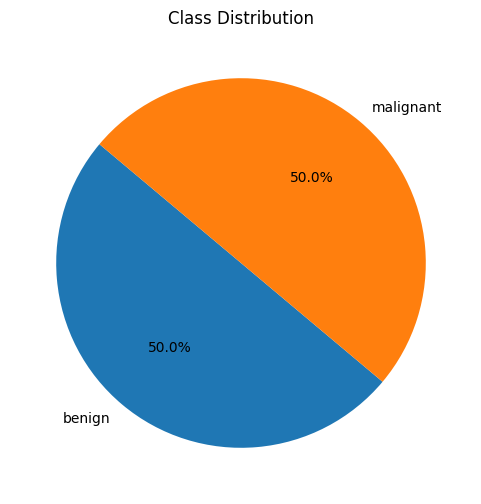

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 89.3MB/s]


Epoch 1/25
----------


100%|██████████| 90/90 [00:18<00:00,  4.96it/s]


train Loss: 0.3945 Acc: 0.8160


100%|██████████| 23/23 [00:01<00:00, 12.26it/s]


val Loss: 0.3377 Acc: 0.8389

Epoch 2/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


train Loss: 0.3555 Acc: 0.8351


100%|██████████| 23/23 [00:01<00:00, 12.58it/s]


val Loss: 0.3427 Acc: 0.8306

Epoch 3/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


train Loss: 0.3241 Acc: 0.8476


100%|██████████| 23/23 [00:02<00:00, 11.41it/s]


val Loss: 0.3274 Acc: 0.8333

Epoch 4/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.07it/s]


train Loss: 0.3137 Acc: 0.8601


100%|██████████| 23/23 [00:01<00:00, 12.90it/s]


val Loss: 0.3193 Acc: 0.8458

Epoch 5/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.07it/s]


train Loss: 0.3088 Acc: 0.8615


100%|██████████| 23/23 [00:01<00:00, 13.03it/s]


val Loss: 0.3285 Acc: 0.8458

Epoch 6/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


train Loss: 0.2922 Acc: 0.8677


100%|██████████| 23/23 [00:01<00:00, 12.58it/s]


val Loss: 0.3788 Acc: 0.8292

Epoch 7/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.04it/s]


train Loss: 0.2905 Acc: 0.8708


100%|██████████| 23/23 [00:01<00:00, 12.78it/s]


val Loss: 0.2937 Acc: 0.8611

Epoch 8/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.06it/s]


train Loss: 0.2418 Acc: 0.8934


100%|██████████| 23/23 [00:01<00:00, 13.02it/s]


val Loss: 0.2864 Acc: 0.8653

Epoch 9/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


train Loss: 0.2241 Acc: 0.8986


100%|██████████| 23/23 [00:01<00:00, 12.91it/s]


val Loss: 0.2936 Acc: 0.8667

Epoch 10/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.07it/s]


train Loss: 0.2113 Acc: 0.9111


100%|██████████| 23/23 [00:01<00:00, 12.81it/s]


val Loss: 0.2860 Acc: 0.8792

Epoch 11/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


train Loss: 0.1952 Acc: 0.9188


100%|██████████| 23/23 [00:01<00:00, 12.92it/s]


val Loss: 0.3010 Acc: 0.8736

Epoch 12/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.07it/s]


train Loss: 0.2062 Acc: 0.9122


100%|██████████| 23/23 [00:01<00:00, 12.91it/s]


val Loss: 0.3074 Acc: 0.8806

Epoch 13/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.06it/s]


train Loss: 0.1941 Acc: 0.9125


100%|██████████| 23/23 [00:01<00:00, 12.98it/s]


val Loss: 0.3149 Acc: 0.8778

Epoch 14/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.07it/s]


train Loss: 0.1908 Acc: 0.9153


100%|██████████| 23/23 [00:01<00:00, 12.98it/s]


val Loss: 0.3046 Acc: 0.8736

Epoch 15/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.07it/s]


train Loss: 0.1675 Acc: 0.9299


100%|██████████| 23/23 [00:01<00:00, 13.08it/s]


val Loss: 0.3006 Acc: 0.8792

Epoch 16/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.07it/s]


train Loss: 0.1834 Acc: 0.9219


100%|██████████| 23/23 [00:01<00:00, 12.66it/s]


val Loss: 0.2973 Acc: 0.8736

Epoch 17/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.06it/s]


train Loss: 0.1720 Acc: 0.9247


100%|██████████| 23/23 [00:01<00:00, 12.97it/s]


val Loss: 0.3115 Acc: 0.8764

Epoch 18/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


train Loss: 0.1722 Acc: 0.9219


100%|██████████| 23/23 [00:01<00:00, 13.02it/s]


val Loss: 0.3056 Acc: 0.8764

Epoch 19/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


train Loss: 0.1835 Acc: 0.9215


100%|██████████| 23/23 [00:01<00:00, 13.04it/s]


val Loss: 0.3128 Acc: 0.8750

Epoch 20/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


train Loss: 0.1712 Acc: 0.9247


100%|██████████| 23/23 [00:01<00:00, 13.04it/s]


val Loss: 0.3109 Acc: 0.8792

Epoch 21/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


train Loss: 0.1774 Acc: 0.9264


100%|██████████| 23/23 [00:01<00:00, 12.15it/s]


val Loss: 0.3109 Acc: 0.8750

Epoch 22/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


train Loss: 0.1714 Acc: 0.9233


100%|██████████| 23/23 [00:01<00:00, 13.22it/s]


val Loss: 0.3101 Acc: 0.8792

Epoch 23/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.07it/s]


train Loss: 0.1672 Acc: 0.9267


100%|██████████| 23/23 [00:01<00:00, 13.13it/s]


val Loss: 0.3105 Acc: 0.8736

Epoch 24/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


train Loss: 0.1661 Acc: 0.9285


100%|██████████| 23/23 [00:01<00:00, 13.04it/s]


val Loss: 0.3100 Acc: 0.8778

Epoch 25/25
----------


100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


train Loss: 0.1767 Acc: 0.9194


100%|██████████| 23/23 [00:01<00:00, 12.75it/s]


val Loss: 0.3096 Acc: 0.8792

Training complete in 8m 10s
Best Val Acc: 0.8806


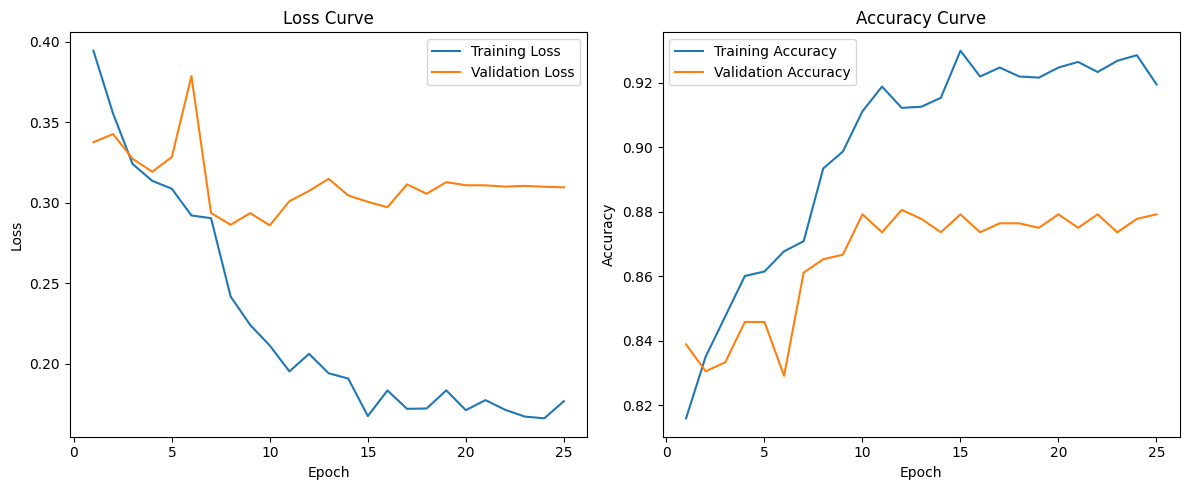

100%|██████████| 23/23 [00:01<00:00, 12.98it/s]


Classification Report:
              precision    recall  f1-score   support

      benign       0.89      0.87      0.88       360
   malignant       0.87      0.89      0.88       360

    accuracy                           0.88       720
   macro avg       0.88      0.88      0.88       720
weighted avg       0.88      0.88      0.88       720



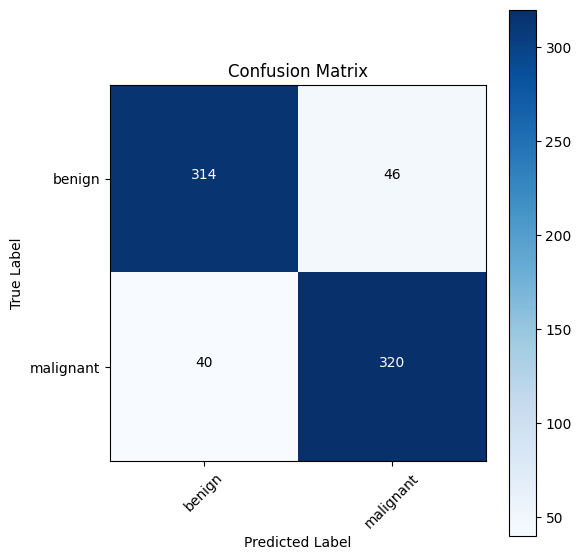

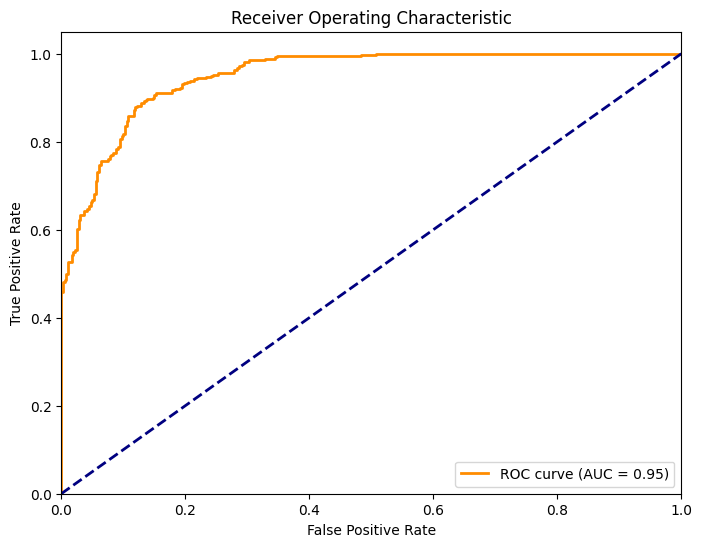

In [6]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm

# ===============================
# 1. Reproducibility & Device Setup
# ===============================
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===============================
# 2. Data Preparation & Augmentation
# ===============================
# Adjust these paths as per your dataset structure.
data_dir = '/kaggle/input/k-means-cyclegan/k-means segmented_data(cycleGAN)'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Data augmentation for training and simple transforms for testing.
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets using ImageFolder (ensure your folder names match)
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# -------------------------------
# Visualization 1: Pie Chart of Class Distribution
# -------------------------------
def plot_class_distribution(dataset):
    class_names = dataset.classes
    class_counts = {class_name: 0 for class_name in class_names}
    for _, label in dataset.imgs:
        class_counts[class_names[label]] += 1
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Class Distribution')
    plt.show()

plot_class_distribution(train_dataset)

# Create DataLoaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# ===============================
# 3. Model Initialization & Fine-Tuning
# ===============================
# Load pre-trained ResNet50 and modify the final layer for 2 classes.
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# ===============================
# 4. Training Function
# ===============================
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store training history for visualization.
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set to training mode.
                dataloader = train_loader
            else:
                model.eval()   # Set to evaluation mode.
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            # Deep copy the model if performance improves.
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Val Acc: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    return model, history

# Train the model (adjust the number of epochs as needed)
num_epochs = 25
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

# -------------------------------
# Visualization 2: Accuracy & Loss Curves
# -------------------------------
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12,5))
    
    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

# ===============================
# 5. Model Evaluation on Test Set
# ===============================
model_ft.eval()
all_preds = []
all_probs = []  # Store probabilities for the positive class (malignant)
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Probability for class 1
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# -------------------------------
# Visualization 3: Classification Report
# -------------------------------
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# -------------------------------
# Visualization 4: Confusion Matrix
# -------------------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.classes))
plt.xticks(tick_marks, train_dataset.classes, rotation=45)
plt.yticks(tick_marks, train_dataset.classes)

thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# -------------------------------
# Visualization 5: ROC Curve and AUC
# -------------------------------
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Restnet50

Using device: cuda:0
Train Set Distribution:


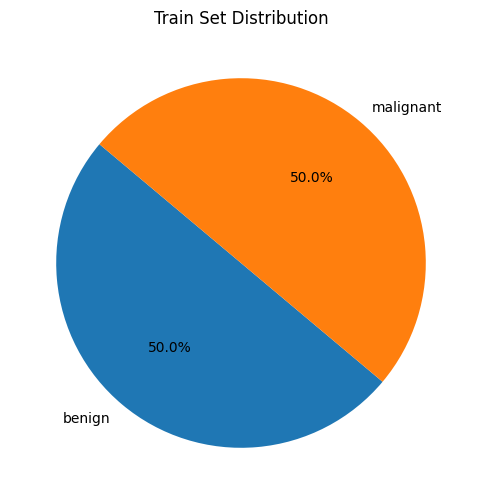

Test Set Distribution:


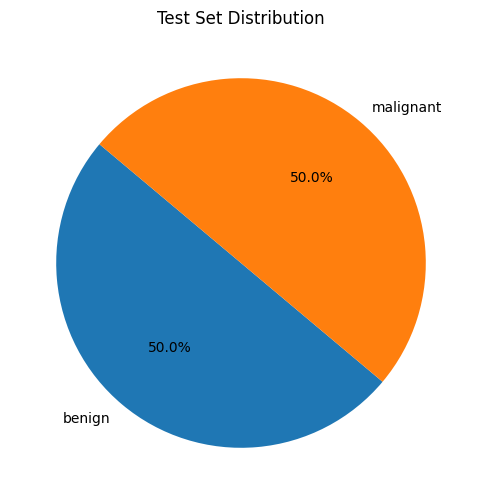

==================== Fold 1/5 ====================


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.05it/s]


Train Loss: 0.4095 Acc: 0.7904


val: 100%|██████████| 18/18 [00:01<00:00, 12.02it/s]


Val Loss: 0.3291 Acc: 0.8368

Epoch 2/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.06it/s]


Train Loss: 0.3425 Acc: 0.8372


val: 100%|██████████| 18/18 [00:01<00:00, 11.90it/s]


Val Loss: 0.3575 Acc: 0.8229

Epoch 3/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.05it/s]


Train Loss: 0.3259 Acc: 0.8472


val: 100%|██████████| 18/18 [00:01<00:00, 11.91it/s]


Val Loss: 0.3601 Acc: 0.8264

Epoch 4/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.06it/s]


Train Loss: 0.3050 Acc: 0.8633


val: 100%|██████████| 18/18 [00:01<00:00, 11.86it/s]


Val Loss: 0.4044 Acc: 0.8264

Epoch 5/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.06it/s]


Train Loss: 0.2925 Acc: 0.8624


val: 100%|██████████| 18/18 [00:01<00:00, 11.92it/s]


Val Loss: 0.3403 Acc: 0.8403

Epoch 6/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.05it/s]


Train Loss: 0.2908 Acc: 0.8685


val: 100%|██████████| 18/18 [00:01<00:00, 11.94it/s]


Val Loss: 0.3638 Acc: 0.8247

Epoch 7/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.05it/s]


Train Loss: 0.2704 Acc: 0.8824


val: 100%|██████████| 18/18 [00:01<00:00, 11.84it/s]


Val Loss: 0.3603 Acc: 0.8316

Epoch 8/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.2497 Acc: 0.8924


val: 100%|██████████| 18/18 [00:01<00:00, 11.63it/s]


Val Loss: 0.3093 Acc: 0.8542

Epoch 9/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.2195 Acc: 0.9028


val: 100%|██████████| 18/18 [00:01<00:00, 11.49it/s]


Val Loss: 0.3295 Acc: 0.8420

Epoch 10/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.05it/s]


Train Loss: 0.2095 Acc: 0.9076


val: 100%|██████████| 18/18 [00:01<00:00, 11.50it/s]


Val Loss: 0.3342 Acc: 0.8594

Epoch 11/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1985 Acc: 0.9110


val: 100%|██████████| 18/18 [00:01<00:00, 11.71it/s]


Val Loss: 0.3288 Acc: 0.8472

Epoch 12/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1923 Acc: 0.9141


val: 100%|██████████| 18/18 [00:01<00:00, 11.73it/s]


Val Loss: 0.3891 Acc: 0.8507

Epoch 13/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1810 Acc: 0.9227


val: 100%|██████████| 18/18 [00:01<00:00, 11.95it/s]


Val Loss: 0.3812 Acc: 0.8455

Epoch 14/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1945 Acc: 0.9128


val: 100%|██████████| 18/18 [00:01<00:00, 11.84it/s]


Val Loss: 0.3647 Acc: 0.8472

Epoch 15/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.05it/s]


Train Loss: 0.1772 Acc: 0.9245


val: 100%|██████████| 18/18 [00:01<00:00, 11.87it/s]


Val Loss: 0.3619 Acc: 0.8559

Epoch 16/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.05it/s]


Train Loss: 0.1725 Acc: 0.9227


val: 100%|██████████| 18/18 [00:01<00:00, 11.83it/s]


Val Loss: 0.3821 Acc: 0.8472

Epoch 17/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1734 Acc: 0.9284


val: 100%|██████████| 18/18 [00:01<00:00, 12.10it/s]


Val Loss: 0.3691 Acc: 0.8490

Epoch 18/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.05it/s]


Train Loss: 0.1735 Acc: 0.9214


val: 100%|██████████| 18/18 [00:01<00:00, 11.88it/s]


Val Loss: 0.3467 Acc: 0.8576

Epoch 19/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.05it/s]


Train Loss: 0.1709 Acc: 0.9275


val: 100%|██████████| 18/18 [00:01<00:00, 11.95it/s]


Val Loss: 0.3730 Acc: 0.8455

Epoch 20/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.1553 Acc: 0.9323


val: 100%|██████████| 18/18 [00:01<00:00, 11.94it/s]


Val Loss: 0.3295 Acc: 0.8559

Epoch 21/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.05it/s]


Train Loss: 0.1584 Acc: 0.9375


val: 100%|██████████| 18/18 [00:01<00:00, 11.73it/s]


Val Loss: 0.3659 Acc: 0.8542

Epoch 22/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.05it/s]


Train Loss: 0.1765 Acc: 0.9214


val: 100%|██████████| 18/18 [00:01<00:00, 11.83it/s]


Val Loss: 0.3556 Acc: 0.8646

Epoch 23/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1687 Acc: 0.9280


val: 100%|██████████| 18/18 [00:01<00:00, 11.72it/s]


Val Loss: 0.3763 Acc: 0.8524

Epoch 24/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.05it/s]


Train Loss: 0.1729 Acc: 0.9223


val: 100%|██████████| 18/18 [00:01<00:00, 11.98it/s]


Val Loss: 0.3769 Acc: 0.8646

Epoch 25/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.06it/s]


Train Loss: 0.1648 Acc: 0.9301


val: 100%|██████████| 18/18 [00:01<00:00, 12.06it/s]


Val Loss: 0.3697 Acc: 0.8542

Training complete in 6m 35s
Best Val Acc: 0.8646
Fold 1 best Val Acc: 0.8646
==================== Fold 2/5 ====================
Epoch 1/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.4277 Acc: 0.7969


val: 100%|██████████| 18/18 [00:01<00:00, 11.79it/s]


Val Loss: 0.3378 Acc: 0.8420

Epoch 2/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.05it/s]


Train Loss: 0.3590 Acc: 0.8225


val: 100%|██████████| 18/18 [00:01<00:00, 11.75it/s]


Val Loss: 0.2944 Acc: 0.8559

Epoch 3/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.3273 Acc: 0.8429


val: 100%|██████████| 18/18 [00:01<00:00, 11.76it/s]


Val Loss: 0.3170 Acc: 0.8628

Epoch 4/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.3148 Acc: 0.8537


val: 100%|██████████| 18/18 [00:01<00:00, 11.67it/s]


Val Loss: 0.3864 Acc: 0.8594

Epoch 5/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.02it/s]


Train Loss: 0.3354 Acc: 0.8485


val: 100%|██████████| 18/18 [00:01<00:00, 11.64it/s]


Val Loss: 0.2915 Acc: 0.8576

Epoch 6/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.3064 Acc: 0.8529


val: 100%|██████████| 18/18 [00:01<00:00, 11.36it/s]


Val Loss: 0.2860 Acc: 0.8611

Epoch 7/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.02it/s]


Train Loss: 0.3015 Acc: 0.8663


val: 100%|██████████| 18/18 [00:01<00:00, 11.79it/s]


Val Loss: 0.2933 Acc: 0.8455

Epoch 8/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.2536 Acc: 0.8880


val: 100%|██████████| 18/18 [00:01<00:00, 11.64it/s]


Val Loss: 0.2483 Acc: 0.8802

Epoch 9/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.2400 Acc: 0.8954


val: 100%|██████████| 18/18 [00:01<00:00, 11.71it/s]


Val Loss: 0.2693 Acc: 0.8594

Epoch 10/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.2335 Acc: 0.8889


val: 100%|██████████| 18/18 [00:01<00:00, 11.64it/s]


Val Loss: 0.2922 Acc: 0.8663

Epoch 11/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.2138 Acc: 0.9067


val: 100%|██████████| 18/18 [00:01<00:00, 11.69it/s]


Val Loss: 0.2729 Acc: 0.8872

Epoch 12/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.1999 Acc: 0.9041


val: 100%|██████████| 18/18 [00:01<00:00, 11.65it/s]


Val Loss: 0.2843 Acc: 0.8767

Epoch 13/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.2118 Acc: 0.9062


val: 100%|██████████| 18/18 [00:01<00:00, 11.60it/s]


Val Loss: 0.2603 Acc: 0.8767

Epoch 14/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1983 Acc: 0.9141


val: 100%|██████████| 18/18 [00:01<00:00, 11.68it/s]


Val Loss: 0.2676 Acc: 0.8698

Epoch 15/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1946 Acc: 0.9162


val: 100%|██████████| 18/18 [00:01<00:00, 11.75it/s]


Val Loss: 0.2593 Acc: 0.8802

Epoch 16/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.05it/s]


Train Loss: 0.1879 Acc: 0.9188


val: 100%|██████████| 18/18 [00:01<00:00, 11.71it/s]


Val Loss: 0.2466 Acc: 0.8941

Epoch 17/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.1907 Acc: 0.9171


val: 100%|██████████| 18/18 [00:01<00:00, 11.79it/s]


Val Loss: 0.2489 Acc: 0.8906

Epoch 18/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1864 Acc: 0.9149


val: 100%|██████████| 18/18 [00:01<00:00, 11.70it/s]


Val Loss: 0.2857 Acc: 0.8854

Epoch 19/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1850 Acc: 0.9184


val: 100%|██████████| 18/18 [00:01<00:00, 11.82it/s]


Val Loss: 0.2712 Acc: 0.8819

Epoch 20/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1878 Acc: 0.9132


val: 100%|██████████| 18/18 [00:01<00:00, 11.41it/s]


Val Loss: 0.2578 Acc: 0.8837

Epoch 21/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.02it/s]


Train Loss: 0.1834 Acc: 0.9253


val: 100%|██████████| 18/18 [00:01<00:00, 11.67it/s]


Val Loss: 0.3214 Acc: 0.8733

Epoch 22/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.1894 Acc: 0.9115


val: 100%|██████████| 18/18 [00:01<00:00, 11.65it/s]


Val Loss: 0.2629 Acc: 0.8715

Epoch 23/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.1950 Acc: 0.9093


val: 100%|██████████| 18/18 [00:01<00:00, 11.58it/s]


Val Loss: 0.2766 Acc: 0.8802

Epoch 24/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1783 Acc: 0.9154


val: 100%|██████████| 18/18 [00:01<00:00, 11.69it/s]


Val Loss: 0.2825 Acc: 0.8802

Epoch 25/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1842 Acc: 0.9232


val: 100%|██████████| 18/18 [00:01<00:00, 11.40it/s]


Val Loss: 0.2746 Acc: 0.8715

Training complete in 6m 37s
Best Val Acc: 0.8941
Fold 2 best Val Acc: 0.8941
==================== Fold 3/5 ====================
Epoch 1/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.3991 Acc: 0.8047


val: 100%|██████████| 18/18 [00:01<00:00, 11.71it/s]


Val Loss: 0.3630 Acc: 0.8403

Epoch 2/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.3406 Acc: 0.8429


val: 100%|██████████| 18/18 [00:01<00:00, 11.53it/s]


Val Loss: 0.3788 Acc: 0.8212

Epoch 3/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.3220 Acc: 0.8451


val: 100%|██████████| 18/18 [00:01<00:00, 11.63it/s]


Val Loss: 0.3615 Acc: 0.8316

Epoch 4/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.02it/s]


Train Loss: 0.3017 Acc: 0.8624


val: 100%|██████████| 18/18 [00:01<00:00, 11.74it/s]


Val Loss: 0.3976 Acc: 0.8125

Epoch 5/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.2900 Acc: 0.8646


val: 100%|██████████| 18/18 [00:01<00:00, 11.41it/s]


Val Loss: 0.3652 Acc: 0.8177

Epoch 6/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.2935 Acc: 0.8694


val: 100%|██████████| 18/18 [00:01<00:00, 11.78it/s]


Val Loss: 0.4162 Acc: 0.8472

Epoch 7/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.2827 Acc: 0.8681


val: 100%|██████████| 18/18 [00:01<00:00, 11.79it/s]


Val Loss: 0.3378 Acc: 0.8420

Epoch 8/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.2457 Acc: 0.8867


val: 100%|██████████| 18/18 [00:01<00:00, 11.86it/s]


Val Loss: 0.3468 Acc: 0.8368

Epoch 9/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.2204 Acc: 0.9041


val: 100%|██████████| 18/18 [00:01<00:00, 11.88it/s]


Val Loss: 0.3229 Acc: 0.8594

Epoch 10/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.02it/s]


Train Loss: 0.2197 Acc: 0.9045


val: 100%|██████████| 18/18 [00:01<00:00, 11.67it/s]


Val Loss: 0.3423 Acc: 0.8368

Epoch 11/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.05it/s]


Train Loss: 0.2072 Acc: 0.9023


val: 100%|██████████| 18/18 [00:01<00:00, 11.80it/s]


Val Loss: 0.3326 Acc: 0.8542

Epoch 12/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1942 Acc: 0.9119


val: 100%|██████████| 18/18 [00:01<00:00, 11.62it/s]


Val Loss: 0.3149 Acc: 0.8663

Epoch 13/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1898 Acc: 0.9123


val: 100%|██████████| 18/18 [00:01<00:00, 11.67it/s]


Val Loss: 0.3187 Acc: 0.8611

Epoch 14/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1881 Acc: 0.9128


val: 100%|██████████| 18/18 [00:01<00:00, 11.92it/s]


Val Loss: 0.3554 Acc: 0.8420

Epoch 15/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1748 Acc: 0.9197


val: 100%|██████████| 18/18 [00:01<00:00, 11.67it/s]


Val Loss: 0.3428 Acc: 0.8490

Epoch 16/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.02it/s]


Train Loss: 0.1670 Acc: 0.9262


val: 100%|██████████| 18/18 [00:01<00:00, 11.83it/s]


Val Loss: 0.3202 Acc: 0.8507

Epoch 17/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1760 Acc: 0.9240


val: 100%|██████████| 18/18 [00:01<00:00, 11.44it/s]


Val Loss: 0.3096 Acc: 0.8854

Epoch 18/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1735 Acc: 0.9210


val: 100%|██████████| 18/18 [00:01<00:00, 11.71it/s]


Val Loss: 0.3409 Acc: 0.8594

Epoch 19/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1722 Acc: 0.9232


val: 100%|██████████| 18/18 [00:01<00:00, 11.80it/s]


Val Loss: 0.3186 Acc: 0.8490

Epoch 20/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1632 Acc: 0.9306


val: 100%|██████████| 18/18 [00:01<00:00, 11.81it/s]


Val Loss: 0.3435 Acc: 0.8559

Epoch 21/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.05it/s]


Train Loss: 0.1625 Acc: 0.9253


val: 100%|██████████| 18/18 [00:01<00:00, 11.53it/s]


Val Loss: 0.3305 Acc: 0.8576

Epoch 22/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.1730 Acc: 0.9214


val: 100%|██████████| 18/18 [00:01<00:00, 11.67it/s]


Val Loss: 0.3475 Acc: 0.8628

Epoch 23/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1709 Acc: 0.9240


val: 100%|██████████| 18/18 [00:01<00:00, 11.78it/s]


Val Loss: 0.3270 Acc: 0.8524

Epoch 24/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.02it/s]


Train Loss: 0.1746 Acc: 0.9145


val: 100%|██████████| 18/18 [00:01<00:00, 11.78it/s]


Val Loss: 0.3495 Acc: 0.8507

Epoch 25/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1908 Acc: 0.9110


val: 100%|██████████| 18/18 [00:01<00:00, 11.76it/s]


Val Loss: 0.3195 Acc: 0.8663

Training complete in 6m 37s
Best Val Acc: 0.8854
Fold 3 best Val Acc: 0.8854
==================== Fold 4/5 ====================
Epoch 1/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.4343 Acc: 0.7882


val: 100%|██████████| 18/18 [00:01<00:00, 11.74it/s]


Val Loss: 0.3172 Acc: 0.8524

Epoch 2/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.3561 Acc: 0.8255


val: 100%|██████████| 18/18 [00:01<00:00, 11.59it/s]


Val Loss: 0.3194 Acc: 0.8316

Epoch 3/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.02it/s]


Train Loss: 0.3590 Acc: 0.8338


val: 100%|██████████| 18/18 [00:01<00:00, 11.77it/s]


Val Loss: 0.3083 Acc: 0.8472

Epoch 4/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.3282 Acc: 0.8407


val: 100%|██████████| 18/18 [00:01<00:00, 11.95it/s]


Val Loss: 0.3154 Acc: 0.8455

Epoch 5/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.3115 Acc: 0.8581


val: 100%|██████████| 18/18 [00:01<00:00, 11.71it/s]


Val Loss: 0.3206 Acc: 0.8472

Epoch 6/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.2921 Acc: 0.8685


val: 100%|██████████| 18/18 [00:01<00:00, 11.73it/s]


Val Loss: 0.3066 Acc: 0.8698

Epoch 7/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.2938 Acc: 0.8624


val: 100%|██████████| 18/18 [00:01<00:00, 11.68it/s]


Val Loss: 0.3042 Acc: 0.8681

Epoch 8/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.2356 Acc: 0.8889


val: 100%|██████████| 18/18 [00:01<00:00, 11.85it/s]


Val Loss: 0.2948 Acc: 0.8542

Epoch 9/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.2321 Acc: 0.8941


val: 100%|██████████| 18/18 [00:01<00:00, 11.56it/s]


Val Loss: 0.2939 Acc: 0.8490

Epoch 10/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.2202 Acc: 0.9006


val: 100%|██████████| 18/18 [00:01<00:00, 11.71it/s]


Val Loss: 0.2874 Acc: 0.8628

Epoch 11/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.2135 Acc: 0.8980


val: 100%|██████████| 18/18 [00:01<00:00, 11.58it/s]


Val Loss: 0.2949 Acc: 0.8628

Epoch 12/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.2004 Acc: 0.9102


val: 100%|██████████| 18/18 [00:01<00:00, 11.59it/s]


Val Loss: 0.2938 Acc: 0.8663

Epoch 13/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.1997 Acc: 0.9102


val: 100%|██████████| 18/18 [00:01<00:00, 11.87it/s]


Val Loss: 0.2951 Acc: 0.8542

Epoch 14/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.05it/s]


Train Loss: 0.1784 Acc: 0.9136


val: 100%|██████████| 18/18 [00:01<00:00, 11.73it/s]


Val Loss: 0.3222 Acc: 0.8646

Epoch 15/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1899 Acc: 0.9158


val: 100%|██████████| 18/18 [00:01<00:00, 11.80it/s]


Val Loss: 0.3100 Acc: 0.8438

Epoch 16/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1921 Acc: 0.9175


val: 100%|██████████| 18/18 [00:01<00:00, 11.87it/s]


Val Loss: 0.3110 Acc: 0.8542

Epoch 17/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.05it/s]


Train Loss: 0.1938 Acc: 0.9171


val: 100%|██████████| 18/18 [00:01<00:00, 11.90it/s]


Val Loss: 0.2737 Acc: 0.8785

Epoch 18/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.05it/s]


Train Loss: 0.1821 Acc: 0.9258


val: 100%|██████████| 18/18 [00:01<00:00, 11.99it/s]


Val Loss: 0.3003 Acc: 0.8750

Epoch 19/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.1864 Acc: 0.9110


val: 100%|██████████| 18/18 [00:01<00:00, 11.74it/s]


Val Loss: 0.2753 Acc: 0.8733

Epoch 20/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.1951 Acc: 0.9162


val: 100%|██████████| 18/18 [00:01<00:00, 11.71it/s]


Val Loss: 0.2610 Acc: 0.8733

Epoch 21/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.1760 Acc: 0.9206


val: 100%|██████████| 18/18 [00:01<00:00, 11.94it/s]


Val Loss: 0.3049 Acc: 0.8681

Epoch 22/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.06it/s]


Train Loss: 0.1759 Acc: 0.9236


val: 100%|██████████| 18/18 [00:01<00:00, 11.86it/s]


Val Loss: 0.3113 Acc: 0.8594

Epoch 23/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.02it/s]


Train Loss: 0.1814 Acc: 0.9253


val: 100%|██████████| 18/18 [00:01<00:00, 11.68it/s]


Val Loss: 0.2865 Acc: 0.8663

Epoch 24/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.1807 Acc: 0.9214


val: 100%|██████████| 18/18 [00:01<00:00, 11.71it/s]


Val Loss: 0.2797 Acc: 0.8733

Epoch 25/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.1761 Acc: 0.9206


val: 100%|██████████| 18/18 [00:01<00:00, 11.90it/s]


Val Loss: 0.2881 Acc: 0.8663

Training complete in 6m 36s
Best Val Acc: 0.8785
Fold 4 best Val Acc: 0.8785
==================== Fold 5/5 ====================
Epoch 1/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.4270 Acc: 0.7995


val: 100%|██████████| 18/18 [00:01<00:00, 11.47it/s]


Val Loss: 0.3223 Acc: 0.8559

Epoch 2/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.02it/s]


Train Loss: 0.3625 Acc: 0.8355


val: 100%|██████████| 18/18 [00:01<00:00, 11.74it/s]


Val Loss: 0.3315 Acc: 0.8403

Epoch 3/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.3434 Acc: 0.8490


val: 100%|██████████| 18/18 [00:01<00:00, 11.71it/s]


Val Loss: 0.3114 Acc: 0.8524

Epoch 4/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.3221 Acc: 0.8442


val: 100%|██████████| 18/18 [00:01<00:00, 11.75it/s]


Val Loss: 0.3303 Acc: 0.8264

Epoch 5/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.02it/s]


Train Loss: 0.3056 Acc: 0.8563


val: 100%|██████████| 18/18 [00:01<00:00, 11.60it/s]


Val Loss: 0.3468 Acc: 0.8524

Epoch 6/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.02it/s]


Train Loss: 0.2978 Acc: 0.8581


val: 100%|██████████| 18/18 [00:01<00:00, 11.51it/s]


Val Loss: 0.3267 Acc: 0.8594

Epoch 7/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.2894 Acc: 0.8681


val: 100%|██████████| 18/18 [00:01<00:00, 11.64it/s]


Val Loss: 0.3000 Acc: 0.8785

Epoch 8/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.02it/s]


Train Loss: 0.2574 Acc: 0.8850


val: 100%|██████████| 18/18 [00:01<00:00, 11.66it/s]


Val Loss: 0.2896 Acc: 0.8611

Epoch 9/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.2230 Acc: 0.8976


val: 100%|██████████| 18/18 [00:01<00:00, 11.62it/s]


Val Loss: 0.2886 Acc: 0.8819

Epoch 10/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.2139 Acc: 0.8997


val: 100%|██████████| 18/18 [00:01<00:00, 11.40it/s]


Val Loss: 0.2862 Acc: 0.8733

Epoch 11/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.2157 Acc: 0.9006


val: 100%|██████████| 18/18 [00:01<00:00, 11.64it/s]


Val Loss: 0.2863 Acc: 0.8802

Epoch 12/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.2104 Acc: 0.9041


val: 100%|██████████| 18/18 [00:01<00:00, 11.73it/s]


Val Loss: 0.3031 Acc: 0.8611

Epoch 13/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.2090 Acc: 0.9067


val: 100%|██████████| 18/18 [00:01<00:00, 11.77it/s]


Val Loss: 0.2900 Acc: 0.8906

Epoch 14/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.02it/s]


Train Loss: 0.2023 Acc: 0.9045


val: 100%|██████████| 18/18 [00:01<00:00, 11.67it/s]


Val Loss: 0.3200 Acc: 0.8681

Epoch 15/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.2044 Acc: 0.9106


val: 100%|██████████| 18/18 [00:01<00:00, 11.65it/s]


Val Loss: 0.2965 Acc: 0.8733

Epoch 16/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.1900 Acc: 0.9141


val: 100%|██████████| 18/18 [00:01<00:00, 11.64it/s]


Val Loss: 0.3003 Acc: 0.8715

Epoch 17/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.02it/s]


Train Loss: 0.1912 Acc: 0.9093


val: 100%|██████████| 18/18 [00:01<00:00, 11.63it/s]


Val Loss: 0.2964 Acc: 0.8767

Epoch 18/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.1731 Acc: 0.9253


val: 100%|██████████| 18/18 [00:01<00:00, 11.45it/s]


Val Loss: 0.2988 Acc: 0.8819

Epoch 19/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.1891 Acc: 0.9119


val: 100%|██████████| 18/18 [00:01<00:00, 11.69it/s]


Val Loss: 0.3043 Acc: 0.8698

Epoch 20/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


Train Loss: 0.1867 Acc: 0.9162


val: 100%|██████████| 18/18 [00:01<00:00, 11.85it/s]


Val Loss: 0.3053 Acc: 0.8663

Epoch 21/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1928 Acc: 0.9102


val: 100%|██████████| 18/18 [00:01<00:00, 11.92it/s]


Val Loss: 0.3081 Acc: 0.8750

Epoch 22/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1736 Acc: 0.9193


val: 100%|██████████| 18/18 [00:01<00:00, 11.70it/s]


Val Loss: 0.3234 Acc: 0.8646

Epoch 23/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1904 Acc: 0.9123


val: 100%|██████████| 18/18 [00:01<00:00, 11.69it/s]


Val Loss: 0.2954 Acc: 0.8819

Epoch 24/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.02it/s]


Train Loss: 0.1896 Acc: 0.9136


val: 100%|██████████| 18/18 [00:01<00:00, 11.77it/s]


Val Loss: 0.3165 Acc: 0.8767

Epoch 25/25
----------


train: 100%|██████████| 72/72 [00:14<00:00,  5.04it/s]


Train Loss: 0.1846 Acc: 0.9201


val: 100%|██████████| 18/18 [00:01<00:00, 11.84it/s]


Val Loss: 0.3150 Acc: 0.8663

Training complete in 6m 37s
Best Val Acc: 0.8906
Fold 5 best Val Acc: 0.8906

Overall Best Fold Val Acc: 0.8941


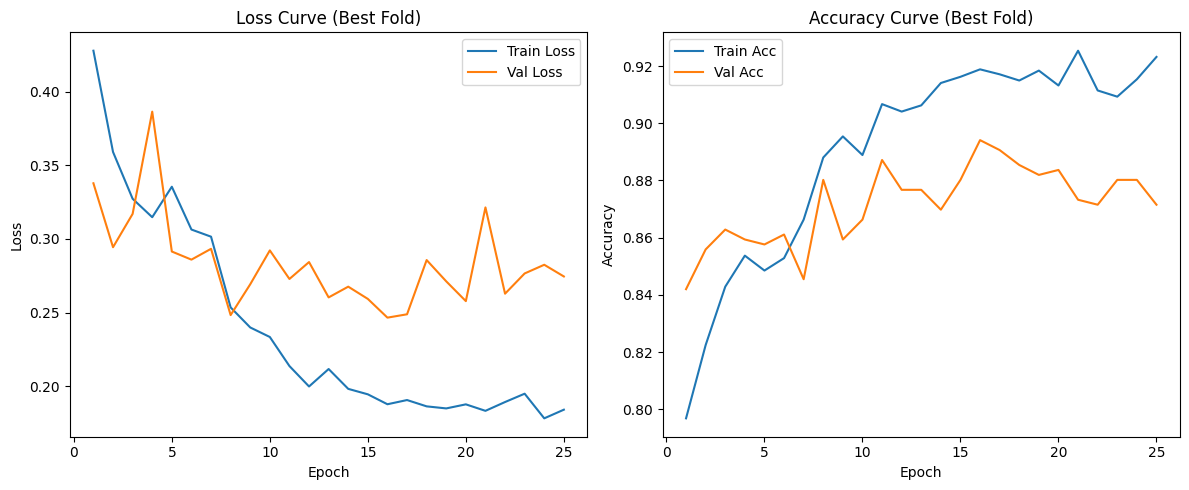

Testing: 100%|██████████| 23/23 [00:01<00:00, 12.77it/s]


Classification Report:
              precision    recall  f1-score   support

      benign       0.86      0.86      0.86       360
   malignant       0.86      0.86      0.86       360

    accuracy                           0.86       720
   macro avg       0.86      0.86      0.86       720
weighted avg       0.86      0.86      0.86       720



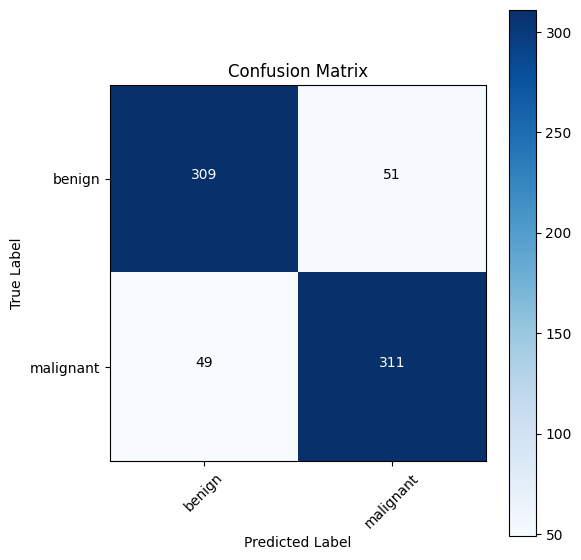

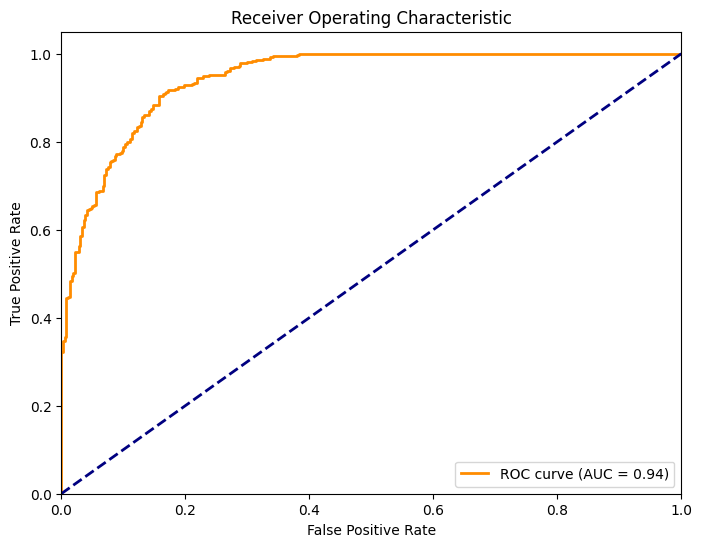

In [11]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

########################################
# 1. Reproducibility & Device Setup
########################################
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

########################################
# 2. Data Preparation & Augmentation
########################################
# Adjust these paths to your dataset location
data_dir = '/kaggle/input/k-means-cyclegan/k-means segmented_data(cycleGAN)'
train_dir = os.path.join(data_dir, 'train')
test_dir  = os.path.join(data_dir, 'test')

# Data augmentation for training and simple transforms for testing.
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets using ImageFolder (structure: train/benign, train/malignant)
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transforms)

########################################
# 3. Visualization: Class Distribution
########################################
def plot_class_distribution(dataset, title="Class Distribution"):
    # Works for ImageFolder datasets
    class_names = dataset.classes
    class_counts = {name: 0 for name in class_names}
    for _, label in dataset.samples:
        class_counts[class_names[label]] += 1
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

print("Train Set Distribution:")
plot_class_distribution(train_dataset, "Train Set Distribution")

print("Test Set Distribution:")
plot_class_distribution(test_dataset, "Test Set Distribution")

########################################
# 4. Define Training Function for One Fold
########################################
def train_model_fold(model, criterion, optimizer, scheduler, 
                     train_loader, val_loader, num_epochs=25):
    """
    Train a model on a single fold using the provided train and validation loaders.
    Returns the best model (state_dict loaded) and training history.
    """
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store training history
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 10)
        # Each epoch has training and validation phases
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in tqdm(loader, desc=f"{phase}"):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                total_samples += inputs.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc  = running_corrects / total_samples

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
                scheduler.step()  # Step the scheduler every epoch in training phase
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                # Deep copy model if improved on validation
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    
        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Val Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    return model, history

########################################
# 5. K-Fold Cross Validation Training
########################################
# Use StratifiedKFold on training dataset indices
num_folds = 5
batch_size = 32
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Extract targets from ImageFolder (list of labels)
targets = [s[1] for s in train_dataset.samples]

fold_histories = []
best_fold_model = None
best_fold_val_acc = 0.0

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f"==================== Fold {fold+1}/{num_folds} ====================")
    
    # Create subsets for current fold
    from torch.utils.data import Subset
    train_subset = Subset(train_dataset, train_idx)
    val_subset   = Subset(train_dataset, val_idx)
    
    # Create DataLoaders for current fold
    train_loader_fold = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader_fold   = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # Initialize a fresh pre-trained ResNet50 model with dropout in final layer
    model_fold = models.resnet50(pretrained=True)
    num_ftrs = model_fold.fc.in_features
    model_fold.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, 2)
    )
    model_fold = model_fold.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer_fold = optim.Adam(model_fold.parameters(), lr=1e-4)
    scheduler_fold = lr_scheduler.StepLR(optimizer_fold, step_size=7, gamma=0.1)
    
    # Train on current fold
    model_fold, history = train_model_fold(model_fold, criterion, optimizer_fold, scheduler_fold,
                                           train_loader_fold, val_loader_fold, num_epochs=25)
    fold_histories.append(history)
    
    # Record best fold based on highest validation accuracy from this fold's history
    current_best = max(history['val_acc'])
    print(f"Fold {fold+1} best Val Acc: {current_best:.4f}")
    if current_best > best_fold_val_acc:
        best_fold_val_acc = current_best
        best_fold_model = model_fold  # save the model from best fold

print(f"\nOverall Best Fold Val Acc: {best_fold_val_acc:.4f}")

########################################
# 6. Plot Training Curves (from best fold)
########################################
# Plot loss and accuracy curves for the best fold
best_history = fold_histories[np.argmax([max(h['val_acc']) for h in fold_histories])]
epochs = range(1, len(best_history['train_loss']) + 1)
plt.figure(figsize=(12,5))
# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs, best_history['train_loss'], label='Train Loss')
plt.plot(epochs, best_history['val_loss'], label='Val Loss')
plt.title('Loss Curve (Best Fold)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, best_history['train_acc'], label='Train Acc')
plt.plot(epochs, best_history['val_acc'], label='Val Acc')
plt.title('Accuracy Curve (Best Fold)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

########################################
# 7. Final Evaluation on Test Set
########################################
best_fold_model.eval()
all_preds = []
all_probs = []  # store probability for class "malignant" (class index 1)
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4),
                               desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = best_fold_model(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # probability for class 1
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# -------------------------------
# Visualization: Classification Report
# -------------------------------
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# -------------------------------
# Visualization: Confusion Matrix
# -------------------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.classes))
plt.xticks(tick_marks, train_dataset.classes, rotation=45)
plt.yticks(tick_marks, train_dataset.classes)
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# -------------------------------
# Visualization: ROC Curve & AUC
# -------------------------------
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# DenseNet201

Using device: cuda:0
Train Set Distribution:


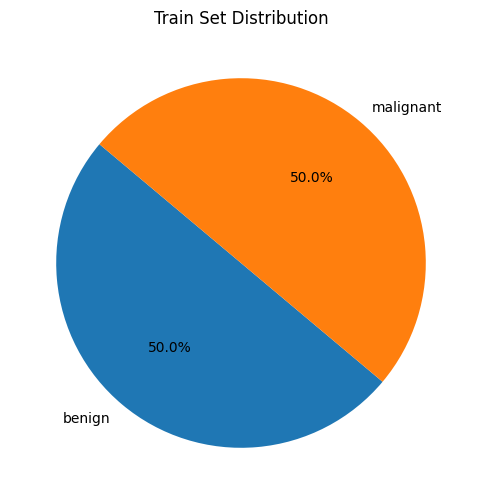

Test Set Distribution:


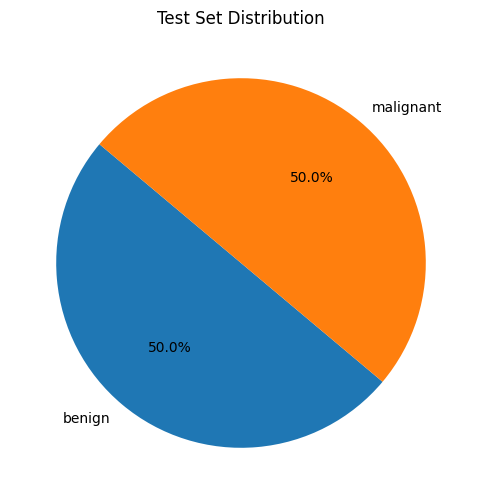

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 179MB/s] 


Epoch 1/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.57it/s]


Train Loss: 0.4721 Acc: 0.7722


val: 100%|██████████| 45/45 [00:04<00:00, 10.75it/s]


Val Loss: 0.3627 Acc: 0.8264

Epoch 2/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.67it/s]


Train Loss: 0.4065 Acc: 0.7927


val: 100%|██████████| 45/45 [00:04<00:00, 10.50it/s]


Val Loss: 0.3531 Acc: 0.8250

Epoch 3/25
----------


train: 100%|██████████| 180/180 [00:49<00:00,  3.65it/s]


Train Loss: 0.3913 Acc: 0.8122


val: 100%|██████████| 45/45 [00:04<00:00, 10.57it/s]


Val Loss: 0.3578 Acc: 0.8472

Epoch 4/25
----------


train: 100%|██████████| 180/180 [00:49<00:00,  3.65it/s]


Train Loss: 0.3843 Acc: 0.8226


val: 100%|██████████| 45/45 [00:04<00:00, 10.60it/s]


Val Loss: 0.3176 Acc: 0.8431

Epoch 5/25
----------


train: 100%|██████████| 180/180 [00:49<00:00,  3.66it/s]


Train Loss: 0.3772 Acc: 0.8219


val: 100%|██████████| 45/45 [00:04<00:00, 10.64it/s]


Val Loss: 0.3416 Acc: 0.8556

Epoch 6/25
----------


train: 100%|██████████| 180/180 [00:49<00:00,  3.66it/s]


Train Loss: 0.3541 Acc: 0.8396


val: 100%|██████████| 45/45 [00:04<00:00, 10.57it/s]


Val Loss: 0.3711 Acc: 0.8319

Epoch 7/25
----------


train: 100%|██████████| 180/180 [00:49<00:00,  3.64it/s]


Train Loss: 0.3402 Acc: 0.8326


val: 100%|██████████| 45/45 [00:04<00:00, 10.61it/s]


Val Loss: 0.3398 Acc: 0.8222

Epoch 8/25
----------


train: 100%|██████████| 180/180 [00:49<00:00,  3.65it/s]


Train Loss: 0.3158 Acc: 0.8542


val: 100%|██████████| 45/45 [00:04<00:00, 10.60it/s]


Val Loss: 0.2949 Acc: 0.8556

Epoch 9/25
----------


train: 100%|██████████| 180/180 [00:49<00:00,  3.66it/s]


Train Loss: 0.2842 Acc: 0.8684


val: 100%|██████████| 45/45 [00:04<00:00, 10.63it/s]


Val Loss: 0.2986 Acc: 0.8556

Epoch 10/25
----------


train: 100%|██████████| 180/180 [00:49<00:00,  3.66it/s]


Train Loss: 0.2882 Acc: 0.8688


val: 100%|██████████| 45/45 [00:04<00:00, 10.61it/s]


Val Loss: 0.2923 Acc: 0.8667

Epoch 11/25
----------


train: 100%|██████████| 180/180 [00:49<00:00,  3.66it/s]


Train Loss: 0.2785 Acc: 0.8701


val: 100%|██████████| 45/45 [00:04<00:00, 10.63it/s]


Val Loss: 0.2886 Acc: 0.8667

Epoch 12/25
----------


train: 100%|██████████| 180/180 [00:49<00:00,  3.66it/s]


Train Loss: 0.2649 Acc: 0.8753


val: 100%|██████████| 45/45 [00:04<00:00, 10.61it/s]


Val Loss: 0.2908 Acc: 0.8597

Epoch 13/25
----------


train: 100%|██████████| 180/180 [00:49<00:00,  3.65it/s]


Train Loss: 0.2708 Acc: 0.8767


val: 100%|██████████| 45/45 [00:04<00:00, 10.54it/s]


Val Loss: 0.2967 Acc: 0.8597

Epoch 14/25
----------


train: 100%|██████████| 180/180 [00:49<00:00,  3.64it/s]


Train Loss: 0.2522 Acc: 0.8788


val: 100%|██████████| 45/45 [00:04<00:00, 10.50it/s]


Val Loss: 0.3051 Acc: 0.8597

Epoch 15/25
----------


train: 100%|██████████| 180/180 [00:49<00:00,  3.65it/s]


Train Loss: 0.2489 Acc: 0.8906


val: 100%|██████████| 45/45 [00:04<00:00, 10.56it/s]


Val Loss: 0.3068 Acc: 0.8597

Epoch 16/25
----------


train: 100%|██████████| 180/180 [00:49<00:00,  3.65it/s]


Train Loss: 0.2489 Acc: 0.8840


val: 100%|██████████| 45/45 [00:04<00:00, 10.55it/s]


Val Loss: 0.3036 Acc: 0.8625

Epoch 17/25
----------


train: 100%|██████████| 180/180 [00:49<00:00,  3.64it/s]


Train Loss: 0.2531 Acc: 0.8903


val: 100%|██████████| 45/45 [00:04<00:00, 10.59it/s]


Val Loss: 0.3009 Acc: 0.8625

Epoch 18/25
----------


train: 100%|██████████| 180/180 [00:49<00:00,  3.65it/s]


Train Loss: 0.2572 Acc: 0.8812


val: 100%|██████████| 45/45 [00:04<00:00, 10.58it/s]


Val Loss: 0.3044 Acc: 0.8597

Epoch 19/25
----------


train: 100%|██████████| 180/180 [00:49<00:00,  3.65it/s]


Train Loss: 0.2370 Acc: 0.8910


val: 100%|██████████| 45/45 [00:04<00:00, 10.52it/s]


Val Loss: 0.2977 Acc: 0.8611

Epoch 20/25
----------


train: 100%|██████████| 180/180 [00:49<00:00,  3.66it/s]


Train Loss: 0.2530 Acc: 0.8823


val: 100%|██████████| 45/45 [00:04<00:00, 10.58it/s]


Val Loss: 0.3011 Acc: 0.8611

Epoch 21/25
----------


train: 100%|██████████| 180/180 [00:49<00:00,  3.65it/s]


Train Loss: 0.2387 Acc: 0.8927


val: 100%|██████████| 45/45 [00:04<00:00, 10.59it/s]


Val Loss: 0.2962 Acc: 0.8569

Epoch 22/25
----------


train: 100%|██████████| 180/180 [00:49<00:00,  3.64it/s]


Train Loss: 0.2463 Acc: 0.8910


val: 100%|██████████| 45/45 [00:04<00:00, 10.38it/s]


Val Loss: 0.2996 Acc: 0.8611

Epoch 23/25
----------


train: 100%|██████████| 180/180 [00:49<00:00,  3.65it/s]


Train Loss: 0.2410 Acc: 0.8917


val: 100%|██████████| 45/45 [00:04<00:00, 10.59it/s]


Val Loss: 0.2998 Acc: 0.8597

Epoch 24/25
----------


train: 100%|██████████| 180/180 [00:49<00:00,  3.66it/s]


Train Loss: 0.2513 Acc: 0.8823


val: 100%|██████████| 45/45 [00:04<00:00, 10.60it/s]


Val Loss: 0.2981 Acc: 0.8611

Epoch 25/25
----------


train: 100%|██████████| 180/180 [00:49<00:00,  3.66it/s]


Train Loss: 0.2451 Acc: 0.8931


val: 100%|██████████| 45/45 [00:04<00:00, 10.60it/s]


Val Loss: 0.3003 Acc: 0.8639

Training complete in 22m 20s
Best Validation Acc: 0.8667


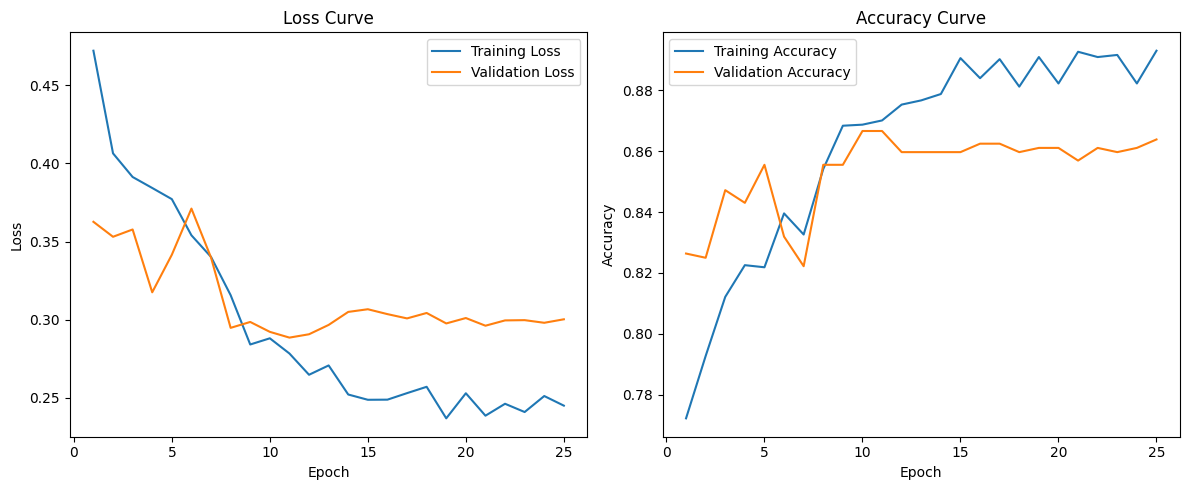

Testing: 100%|██████████| 45/45 [00:17<00:00,  2.54it/s]


Classification Report:
              precision    recall  f1-score   support

      benign       0.88      0.85      0.86       360
   malignant       0.85      0.88      0.87       360

    accuracy                           0.87       720
   macro avg       0.87      0.87      0.87       720
weighted avg       0.87      0.87      0.87       720



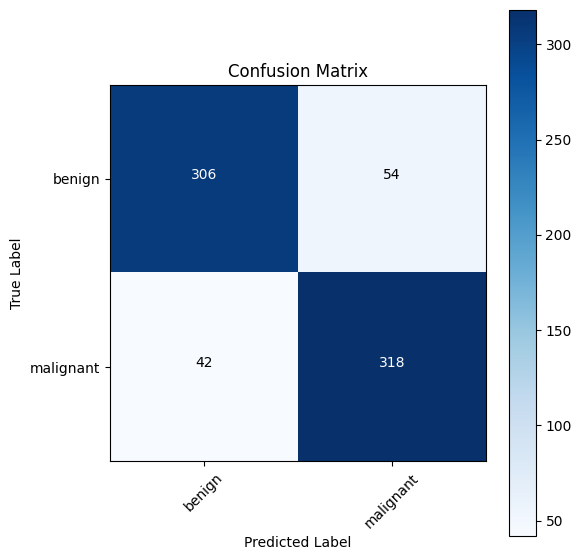

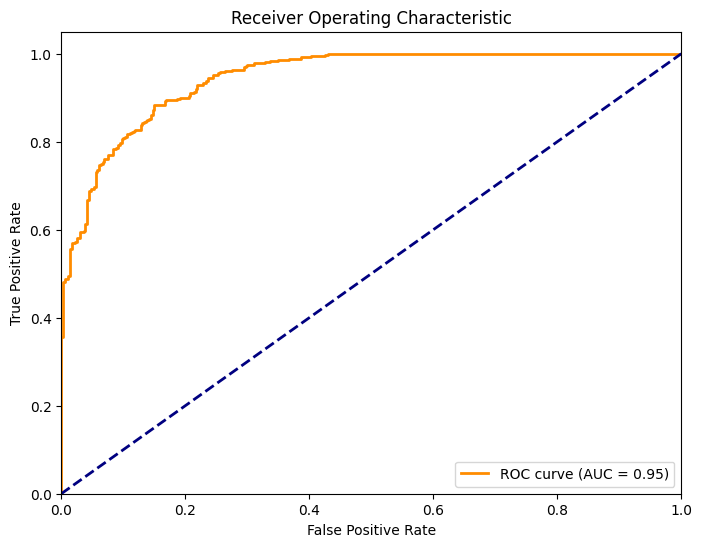

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm

########################################
# 1. Reproducibility & Device Setup
########################################
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

########################################
# 2. Data Preparation & Augmentation
########################################
# Update this path to your dataset directory
data_dir = '/kaggle/input/k-means-cyclegan/k-means segmented_data(cycleGAN)'
train_dir = os.path.join(data_dir, 'train')
test_dir  = os.path.join(data_dir, 'test')

# Define strong augmentation for training and standard transforms for testing.
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transforms)

########################################
# 3. Visualization 1: Dataset Class Distribution (Pie Chart)
########################################
def plot_class_distribution(dataset, title="Class Distribution"):
    class_names = dataset.classes
    class_counts = {name: 0 for name in class_names}
    for _, label in dataset.samples:
        class_counts[class_names[label]] += 1
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

print("Train Set Distribution:")
plot_class_distribution(train_dataset, "Train Set Distribution")
print("Test Set Distribution:")
plot_class_distribution(test_dataset, "Test Set Distribution")

########################################
# 4. DataLoaders
########################################
# Create DataLoaders (adjust batch_size as needed)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

########################################
# 5. Model Initialization & Fine-Tuning (DenseNet201)
########################################
# Load DenseNet201 with pretrained ImageNet weights.
model_dense = models.densenet201(pretrained=True)
# DenseNet201's classifier is a single linear layer stored in model_dense.classifier.
in_features = model_dense.classifier.in_features
# Replace classifier with dropout + linear layer for 2 classes.
model_dense.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, 2)
)
model_dense = model_dense.to(device)

########################################
# 6. Training Function
########################################
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        # Each epoch has a training and validation phase.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                total_samples += inputs.size(0)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Validation Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    return model, history

########################################
# 7. Set Loss Function, Optimizer, and Scheduler
########################################
criterion = nn.CrossEntropyLoss()
optimizer_dense = optim.Adam(model_dense.parameters(), lr=1e-4)
scheduler_dense = lr_scheduler.StepLR(optimizer_dense, step_size=7, gamma=0.1)

########################################
# 8. Train the Model
########################################
num_epochs = 25
model_dense, history = train_model(model_dense, criterion, optimizer_dense, scheduler_dense, num_epochs=num_epochs)

########################################
# 9. Visualization 2: Training Curves (Accuracy & Loss)
########################################
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12,5))
    
    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

########################################
# 10. Model Evaluation on Test Set
########################################
model_dense.eval()
all_preds = []
all_probs = []  # Probabilities for malignant (class index 1)
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_dense(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Class 1 probability
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

########################################
# 11. Visualization 3: Classification Report
########################################
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

########################################
# 12. Visualization 4: Confusion Matrix
########################################
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.classes))
plt.xticks(tick_marks, train_dataset.classes, rotation=45)
plt.yticks(tick_marks, train_dataset.classes)
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

########################################
# 13. Visualization 5: ROC Curve & AUC
########################################
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Xception via TIMM

Using device: cuda:0
Train Set Distribution:


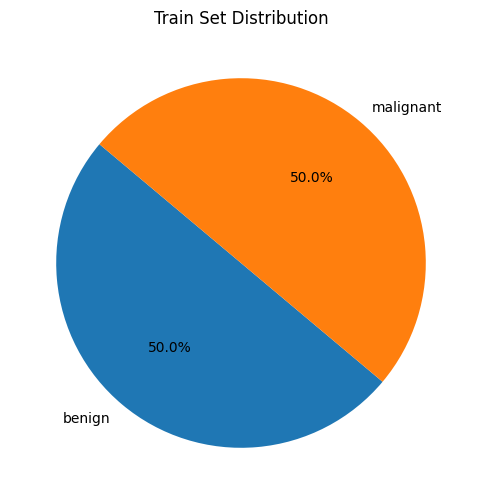

Test Set Distribution:


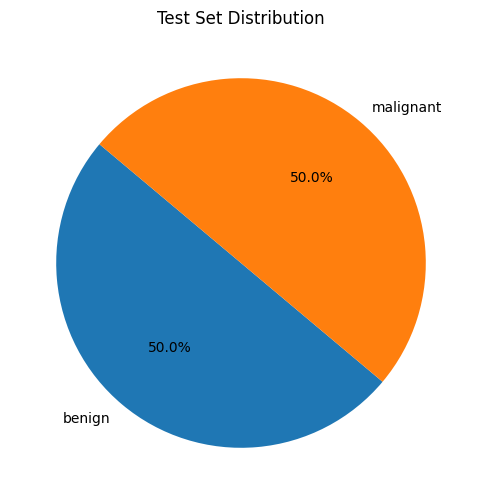

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
<ipython-input-4-b47122d1a503>:119: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/25
----------


train:   0%|          | 0/180 [00:00<?, ?it/s]<ipython-input-4-b47122d1a503>:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
train: 100%|██████████| 180/180 [00:20<00:00,  8.59it/s]


Train Loss: 0.4844 Acc: 0.7590


val: 100%|██████████| 45/45 [00:01<00:00, 23.20it/s]


Val Loss: 0.4368 Acc: 0.8111

Epoch 2/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.01it/s]


Train Loss: 0.4180 Acc: 0.8052


val: 100%|██████████| 45/45 [00:01<00:00, 23.85it/s]


Val Loss: 0.3652 Acc: 0.8389

Epoch 3/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.17it/s]


Train Loss: 0.3815 Acc: 0.8174


val: 100%|██████████| 45/45 [00:01<00:00, 23.93it/s]


Val Loss: 0.3434 Acc: 0.8375

Epoch 4/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.17it/s]


Train Loss: 0.3524 Acc: 0.8396


val: 100%|██████████| 45/45 [00:01<00:00, 23.85it/s]


Val Loss: 0.3292 Acc: 0.8639

Epoch 5/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.03it/s]


Train Loss: 0.3479 Acc: 0.8410


val: 100%|██████████| 45/45 [00:01<00:00, 23.75it/s]


Val Loss: 0.3472 Acc: 0.8444

Epoch 6/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.03it/s]


Train Loss: 0.3156 Acc: 0.8503


val: 100%|██████████| 45/45 [00:01<00:00, 23.82it/s]


Val Loss: 0.3487 Acc: 0.8514

Epoch 7/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.11it/s]


Train Loss: 0.3145 Acc: 0.8594


val: 100%|██████████| 45/45 [00:01<00:00, 23.89it/s]


Val Loss: 0.3721 Acc: 0.8542

Epoch 8/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.12it/s]


Train Loss: 0.2896 Acc: 0.8660


val: 100%|██████████| 45/45 [00:01<00:00, 23.82it/s]


Val Loss: 0.3350 Acc: 0.8708

Epoch 9/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.10it/s]


Train Loss: 0.2517 Acc: 0.8819


val: 100%|██████████| 45/45 [00:01<00:00, 23.86it/s]


Val Loss: 0.3272 Acc: 0.8625

Epoch 10/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.09it/s]


Train Loss: 0.2621 Acc: 0.8878


val: 100%|██████████| 45/45 [00:01<00:00, 24.02it/s]


Val Loss: 0.3221 Acc: 0.8708

Epoch 11/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.09it/s]


Train Loss: 0.2466 Acc: 0.8931


val: 100%|██████████| 45/45 [00:01<00:00, 23.84it/s]


Val Loss: 0.3329 Acc: 0.8694

Epoch 12/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.06it/s]


Train Loss: 0.2531 Acc: 0.8830


val: 100%|██████████| 45/45 [00:01<00:00, 23.79it/s]


Val Loss: 0.3401 Acc: 0.8583

Epoch 13/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.08it/s]


Train Loss: 0.2477 Acc: 0.8986


val: 100%|██████████| 45/45 [00:01<00:00, 23.80it/s]


Val Loss: 0.3403 Acc: 0.8653

Epoch 14/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.09it/s]


Train Loss: 0.2213 Acc: 0.9066


val: 100%|██████████| 45/45 [00:01<00:00, 23.80it/s]


Val Loss: 0.3334 Acc: 0.8750

Epoch 15/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.09it/s]


Train Loss: 0.2335 Acc: 0.8958


val: 100%|██████████| 45/45 [00:01<00:00, 23.57it/s]


Val Loss: 0.3317 Acc: 0.8792

Epoch 16/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.10it/s]


Train Loss: 0.2333 Acc: 0.8941


val: 100%|██████████| 45/45 [00:01<00:00, 23.78it/s]


Val Loss: 0.3403 Acc: 0.8736

Epoch 17/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.09it/s]


Train Loss: 0.2180 Acc: 0.9014


val: 100%|██████████| 45/45 [00:01<00:00, 23.52it/s]


Val Loss: 0.3375 Acc: 0.8708

Epoch 18/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.00it/s]


Train Loss: 0.2390 Acc: 0.8903


val: 100%|██████████| 45/45 [00:01<00:00, 23.86it/s]


Val Loss: 0.3253 Acc: 0.8736

Epoch 19/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.09it/s]


Train Loss: 0.2291 Acc: 0.9000


val: 100%|██████████| 45/45 [00:01<00:00, 24.01it/s]


Val Loss: 0.3313 Acc: 0.8708

Epoch 20/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.09it/s]


Train Loss: 0.2281 Acc: 0.8958


val: 100%|██████████| 45/45 [00:02<00:00, 22.02it/s]


Val Loss: 0.3435 Acc: 0.8653

Epoch 21/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.01it/s]


Train Loss: 0.2317 Acc: 0.8976


val: 100%|██████████| 45/45 [00:01<00:00, 23.67it/s]


Val Loss: 0.3391 Acc: 0.8708

Epoch 22/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.07it/s]


Train Loss: 0.2239 Acc: 0.9049


val: 100%|██████████| 45/45 [00:01<00:00, 23.92it/s]


Val Loss: 0.3368 Acc: 0.8736

Epoch 23/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.07it/s]


Train Loss: 0.2295 Acc: 0.8924


val: 100%|██████████| 45/45 [00:01<00:00, 23.14it/s]


Val Loss: 0.3313 Acc: 0.8667

Epoch 24/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.09it/s]


Train Loss: 0.2242 Acc: 0.8958


val: 100%|██████████| 45/45 [00:01<00:00, 23.89it/s]


Val Loss: 0.3382 Acc: 0.8694

Epoch 25/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.06it/s]


Train Loss: 0.2372 Acc: 0.8955


val: 100%|██████████| 45/45 [00:01<00:00, 23.75it/s]


Val Loss: 0.3376 Acc: 0.8722

Training complete in 9m 5s
Best Validation Acc: 0.8792


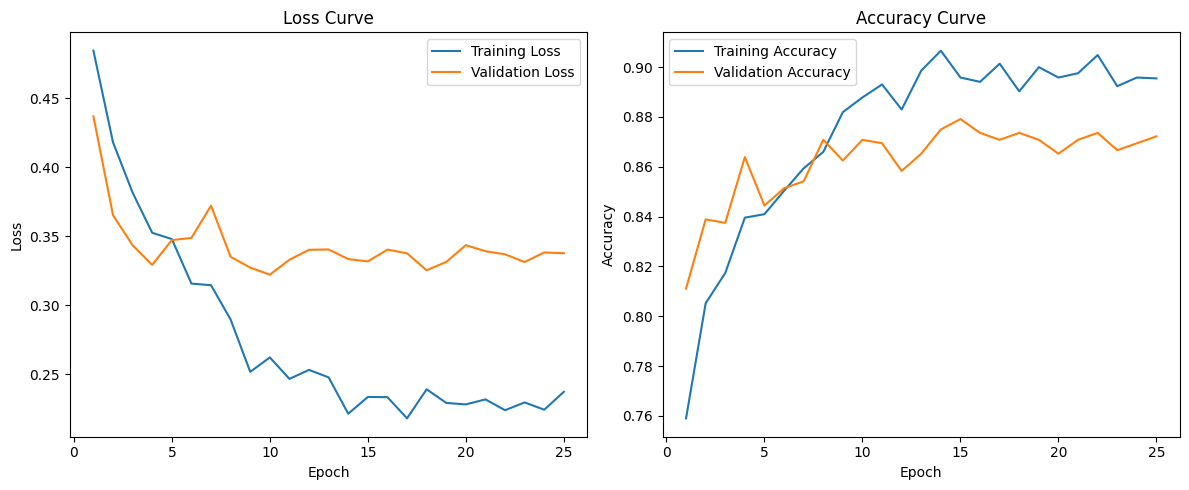

Testing: 100%|██████████| 45/45 [00:03<00:00, 12.78it/s]


Classification Report:
              precision    recall  f1-score   support

      benign       0.88      0.88      0.88       360
   malignant       0.88      0.88      0.88       360

    accuracy                           0.88       720
   macro avg       0.88      0.88      0.88       720
weighted avg       0.88      0.88      0.88       720



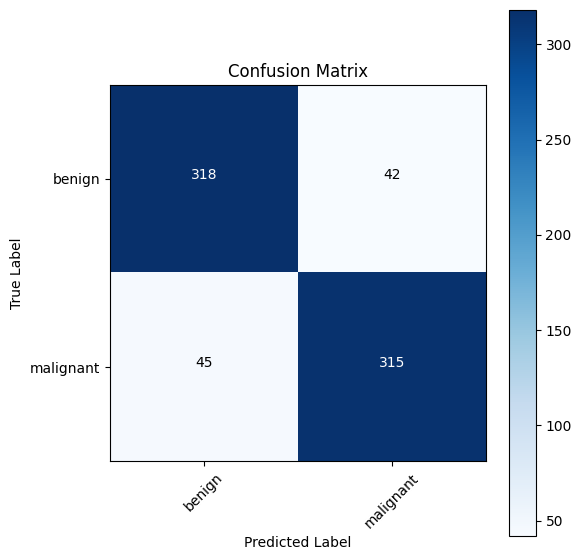

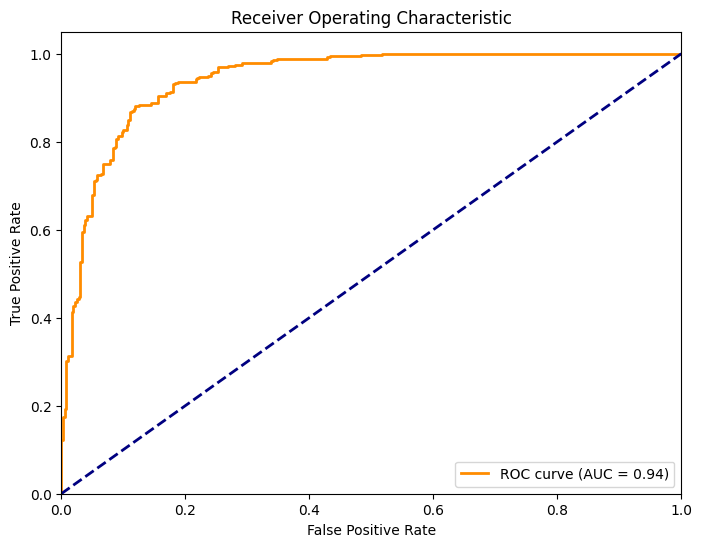

In [4]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm
import timm  # PyTorch Image Models

########################################
# 1. Reproducibility & Device Setup
########################################
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

########################################
# 2. Data Preparation & Augmentation
########################################
# Dataset folder structure:
# data/
#   train/
#     benign/
#     malignant/
#   test/
#     benign/
#     malignant/

data_dir = '/kaggle/input/k-means-cyclegan/k-means segmented_data(cycleGAN)'  # Update this path as needed
train_dir = os.path.join(data_dir, 'train')
test_dir  = os.path.join(data_dir, 'test')

# Define strong augmentations for training and standard transforms for testing.
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets using ImageFolder.
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transforms)

########################################
# 3. Visualization 1: Dataset Class Distribution (Pie Chart)
########################################
def plot_class_distribution(dataset, title="Class Distribution"):
    class_names = dataset.classes
    class_counts = {name: 0 for name in class_names}
    for _, label in dataset.samples:
        class_counts[class_names[label]] += 1
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

print("Train Set Distribution:")
plot_class_distribution(train_dataset, "Train Set Distribution")
print("Test Set Distribution:")
plot_class_distribution(test_dataset, "Test Set Distribution")

########################################
# 4. DataLoaders
########################################
# Adjust batch_size as needed (lower if encountering memory issues)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

########################################
# 5. Model Initialization & Fine-Tuning (Xception)
########################################
# Using TIMM to create the Xception model. Ensure timm is installed (pip install timm)
model_xception = timm.create_model('xception', pretrained=True, num_classes=2)
model_xception = model_xception.to(device)

########################################
# 6. Training Function
########################################
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # History lists for visualization.
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    # Optionally use AMP for mixed precision training to speed up training and reduce memory
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                total_samples += inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Validation Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    return model, history

########################################
# 7. Set Loss Function, Optimizer, and Scheduler
########################################
criterion = nn.CrossEntropyLoss()
optimizer_xception = optim.Adam(model_xception.parameters(), lr=1e-4)
scheduler_xception = lr_scheduler.StepLR(optimizer_xception, step_size=7, gamma=0.1)

########################################
# 8. Train the Model
########################################
num_epochs = 25
model_xception, history = train_model(model_xception, criterion, optimizer_xception, scheduler_xception, num_epochs=num_epochs)

########################################
# 9. Visualization 2: Training Curves (Accuracy & Loss)
########################################
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12,5))
    
    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

########################################
# 10. Model Evaluation on Test Set
########################################
model_xception.eval()
all_preds = []
all_probs = []  # Probabilities for malignant (class index 1)
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_xception(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Probability for class 1
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

########################################
# 11. Visualization 3: Classification Report
########################################
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

########################################
# 12. Visualization 4: Confusion Matrix
########################################
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.classes))
plt.xticks(tick_marks, train_dataset.classes, rotation=45)
plt.yticks(tick_marks, train_dataset.classes)
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

########################################
# 13. Visualization 5: ROC Curve & AUC
########################################
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# InceptionV3 

Using device: cuda:0
Train Set Distribution:


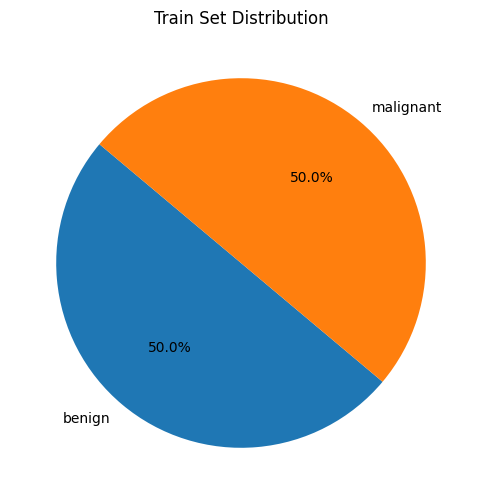

Test Set Distribution:


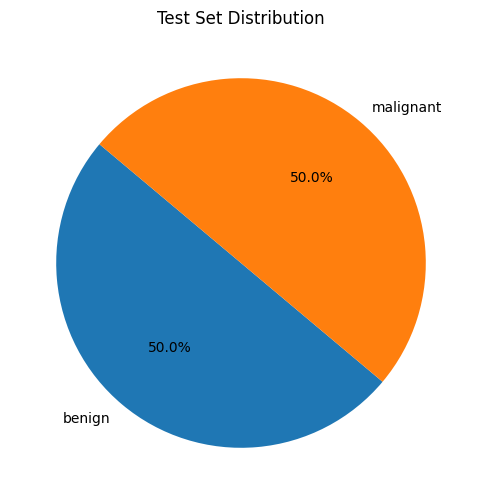

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 207MB/s]  


Epoch 1/25
----------


train: 100%|██████████| 180/180 [00:51<00:00,  3.49it/s]


Train Loss: 0.4772 Acc: 0.7646


val: 100%|██████████| 45/45 [00:03<00:00, 12.65it/s]


Val Loss: 0.4115 Acc: 0.8056

Epoch 2/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.59it/s]


Train Loss: 0.4042 Acc: 0.8042


val: 100%|██████████| 45/45 [00:03<00:00, 12.51it/s]


Val Loss: 0.3682 Acc: 0.8319

Epoch 3/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]


Train Loss: 0.3778 Acc: 0.8253


val: 100%|██████████| 45/45 [00:03<00:00, 12.64it/s]


Val Loss: 0.3391 Acc: 0.8458

Epoch 4/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]


Train Loss: 0.3796 Acc: 0.8306


val: 100%|██████████| 45/45 [00:03<00:00, 12.63it/s]


Val Loss: 0.3929 Acc: 0.8208

Epoch 5/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.57it/s]


Train Loss: 0.3526 Acc: 0.8365


val: 100%|██████████| 45/45 [00:03<00:00, 12.60it/s]


Val Loss: 0.3592 Acc: 0.8292

Epoch 6/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]


Train Loss: 0.3550 Acc: 0.8358


val: 100%|██████████| 45/45 [00:03<00:00, 12.54it/s]


Val Loss: 0.3305 Acc: 0.8472

Epoch 7/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]


Train Loss: 0.3481 Acc: 0.8413


val: 100%|██████████| 45/45 [00:03<00:00, 12.51it/s]


Val Loss: 0.3514 Acc: 0.8375

Epoch 8/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]


Train Loss: 0.3019 Acc: 0.8580


val: 100%|██████████| 45/45 [00:03<00:00, 12.61it/s]


Val Loss: 0.3218 Acc: 0.8583

Epoch 9/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]


Train Loss: 0.2890 Acc: 0.8663


val: 100%|██████████| 45/45 [00:03<00:00, 12.62it/s]


Val Loss: 0.3205 Acc: 0.8556

Epoch 10/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]


Train Loss: 0.2776 Acc: 0.8726


val: 100%|██████████| 45/45 [00:03<00:00, 12.63it/s]


Val Loss: 0.3126 Acc: 0.8583

Epoch 11/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]


Train Loss: 0.2693 Acc: 0.8743


val: 100%|██████████| 45/45 [00:03<00:00, 12.67it/s]


Val Loss: 0.3195 Acc: 0.8611

Epoch 12/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]


Train Loss: 0.2594 Acc: 0.8896


val: 100%|██████████| 45/45 [00:03<00:00, 12.63it/s]


Val Loss: 0.3092 Acc: 0.8667

Epoch 13/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]


Train Loss: 0.2650 Acc: 0.8809


val: 100%|██████████| 45/45 [00:03<00:00, 12.62it/s]


Val Loss: 0.3131 Acc: 0.8639

Epoch 14/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]


Train Loss: 0.2505 Acc: 0.8906


val: 100%|██████████| 45/45 [00:03<00:00, 12.68it/s]


Val Loss: 0.3027 Acc: 0.8694

Epoch 15/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]


Train Loss: 0.2492 Acc: 0.8868


val: 100%|██████████| 45/45 [00:03<00:00, 12.59it/s]


Val Loss: 0.3036 Acc: 0.8667

Epoch 16/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]


Train Loss: 0.2468 Acc: 0.8872


val: 100%|██████████| 45/45 [00:03<00:00, 12.49it/s]


Val Loss: 0.3059 Acc: 0.8681

Epoch 17/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]


Train Loss: 0.2374 Acc: 0.8951


val: 100%|██████████| 45/45 [00:03<00:00, 12.41it/s]


Val Loss: 0.2991 Acc: 0.8681

Epoch 18/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]


Train Loss: 0.2275 Acc: 0.9017


val: 100%|██████████| 45/45 [00:03<00:00, 12.50it/s]


Val Loss: 0.3105 Acc: 0.8639

Epoch 19/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]


Train Loss: 0.2549 Acc: 0.8844


val: 100%|██████████| 45/45 [00:03<00:00, 12.58it/s]


Val Loss: 0.3056 Acc: 0.8681

Epoch 20/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.57it/s]


Train Loss: 0.2440 Acc: 0.8899


val: 100%|██████████| 45/45 [00:03<00:00, 12.11it/s]


Val Loss: 0.3047 Acc: 0.8694

Epoch 21/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.59it/s]


Train Loss: 0.2409 Acc: 0.8951


val: 100%|██████████| 45/45 [00:03<00:00, 12.40it/s]


Val Loss: 0.3072 Acc: 0.8667

Epoch 22/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.57it/s]


Train Loss: 0.2343 Acc: 0.8955


val: 100%|██████████| 45/45 [00:03<00:00, 12.58it/s]


Val Loss: 0.3102 Acc: 0.8653

Epoch 23/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]


Train Loss: 0.2375 Acc: 0.8986


val: 100%|██████████| 45/45 [00:03<00:00, 12.45it/s]


Val Loss: 0.3141 Acc: 0.8653

Epoch 24/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]


Train Loss: 0.2397 Acc: 0.8948


val: 100%|██████████| 45/45 [00:03<00:00, 12.52it/s]


Val Loss: 0.3067 Acc: 0.8722

Epoch 25/25
----------


train: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]


Train Loss: 0.2329 Acc: 0.8993


val: 100%|██████████| 45/45 [00:03<00:00, 12.47it/s]


Val Loss: 0.3169 Acc: 0.8625

Training complete in 22m 29s
Best Validation Acc: 0.8722


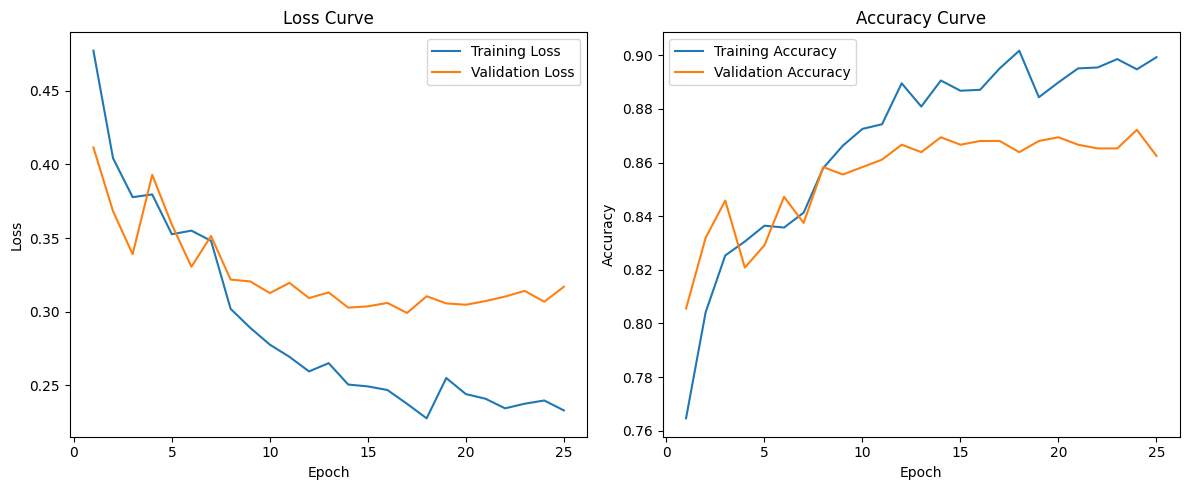

Testing: 100%|██████████| 45/45 [00:03<00:00, 12.51it/s]


Classification Report:
              precision    recall  f1-score   support

      benign       0.87      0.88      0.87       360
   malignant       0.87      0.87      0.87       360

    accuracy                           0.87       720
   macro avg       0.87      0.87      0.87       720
weighted avg       0.87      0.87      0.87       720



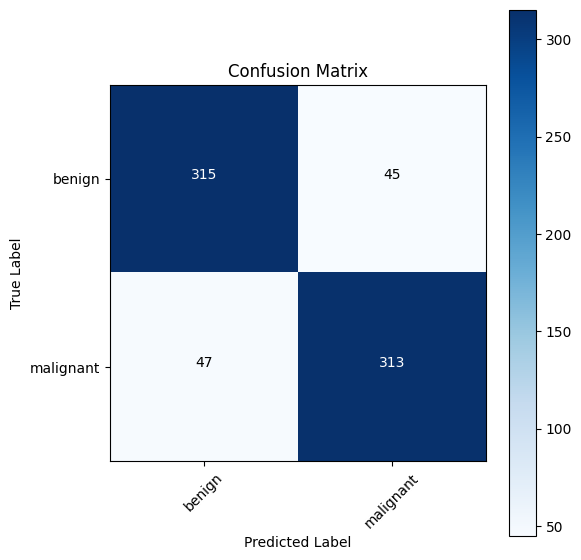

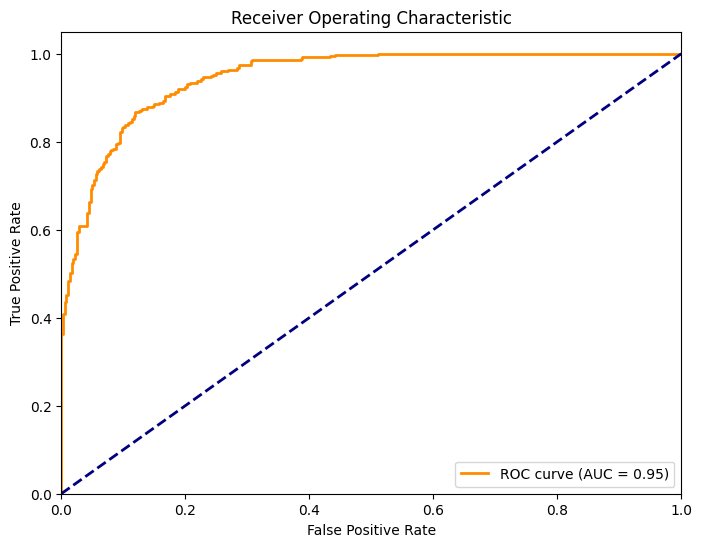

In [6]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm

########################################
# 1. Reproducibility & Device Setup
########################################
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

########################################
# 2. Data Preparation & Augmentation
########################################
# Dataset directory structure:
# data/
#   ..train/
#     benign/
#     malignant/
#   test/
#     benign/
#     malignant/
data_dir = '/kaggle/input/k-means-cyclegan/k-means segmented_data(cycleGAN)'  # Update as needed
train_dir = os.path.join(data_dir, 'train')
test_dir  = os.path.join(data_dir, 'test')

# InceptionV3 expects 299x299 images.
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize(320),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transforms)

########################################
# 3. Visualization 1: Dataset Class Distribution (Pie Chart)
########################################
def plot_class_distribution(dataset, title="Class Distribution"):
    class_names = dataset.classes
    class_counts = {name: 0 for name in class_names}
    for _, label in dataset.samples:
        class_counts[class_names[label]] += 1
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

print("Train Set Distribution:")
plot_class_distribution(train_dataset, "Train Set Distribution")
print("Test Set Distribution:")
plot_class_distribution(test_dataset, "Test Set Distribution")

########################################
# 4. DataLoaders
########################################
batch_size = 16  # Adjust if needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

########################################
# 5. Model Initialization & Fine-Tuning (InceptionV3)
########################################
# Using the new weights API. Note: When using pretrained weights, aux_logits must be True.
from torchvision.models import inception_v3, Inception_V3_Weights
weights = Inception_V3_Weights.IMAGENET1K_V1
model_inception = inception_v3(weights=weights, aux_logits=True)
# Replace the final fully connected layer. The default fc has in_features = 2048.
in_features = model_inception.fc.in_features
model_inception.fc = nn.Linear(in_features, 2)
model_inception = model_inception.to(device)

########################################
# 6. Training Function
########################################
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        
        # Each epoch has training and validation phases.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # If outputs is a tuple (Inception returns (main, aux) when aux_logits=True), take only the primary output.
                    if isinstance(outputs, tuple):
                        outputs = outputs[0]
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                total_samples += inputs.size(0)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Validation Acc: {best_acc:.4f}")
    
    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    return model, history

########################################
# 7. Set Loss Function, Optimizer, and Scheduler
########################################
criterion = nn.CrossEntropyLoss()
optimizer_inception = optim.Adam(model_inception.parameters(), lr=1e-4)
scheduler_inception = lr_scheduler.StepLR(optimizer_inception, step_size=7, gamma=0.1)

########################################
# 8. Train the Model
########################################
num_epochs = 25
model_inception, history = train_model(model_inception, criterion, optimizer_inception, scheduler_inception, num_epochs=num_epochs)

########################################
# 9. Visualization 2: Training Curves (Accuracy & Loss)
########################################
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12,5))
    
    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

########################################
# 10. Model Evaluation on Test Set
########################################
model_inception.eval()
all_preds = []
all_probs = []  # Probabilities for malignant (class index 1)
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_inception(inputs)
        # Use only the primary output
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Probability for class 1
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

########################################
# 11. Visualization 3: Classification Report
########################################
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

########################################
# 12. Visualization 4: Confusion Matrix
########################################
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.classes))
plt.xticks(tick_marks, train_dataset.classes, rotation=45)
plt.yticks(tick_marks, train_dataset.classes)
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

########################################
# 13. Visualization 5: ROC Curve & AUC
########################################
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


#  Ablation study (without segmentatioon)


**Restnet 50**

Using device: cuda:0


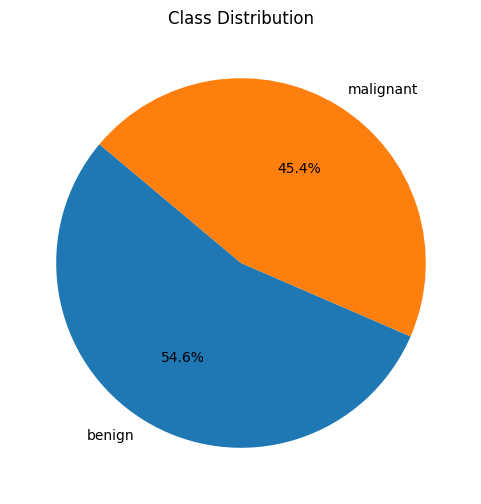

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 214MB/s]


Epoch 1/25
----------


100%|██████████| 83/83 [00:17<00:00,  4.76it/s]


train Loss: 0.4223 Acc: 0.7922


100%|██████████| 21/21 [00:01<00:00, 12.75it/s]


val Loss: 0.3996 Acc: 0.8227

Epoch 2/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.12it/s]


train Loss: 0.3746 Acc: 0.8271


100%|██████████| 21/21 [00:01<00:00, 13.13it/s]


val Loss: 0.3628 Acc: 0.8318

Epoch 3/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.14it/s]


train Loss: 0.3683 Acc: 0.8214


100%|██████████| 21/21 [00:01<00:00, 13.20it/s]


val Loss: 0.3574 Acc: 0.8212

Epoch 4/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.13it/s]


train Loss: 0.3468 Acc: 0.8407


100%|██████████| 21/21 [00:01<00:00, 13.26it/s]


val Loss: 0.3589 Acc: 0.8136

Epoch 5/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.12it/s]


train Loss: 0.3100 Acc: 0.8570


100%|██████████| 21/21 [00:01<00:00, 13.16it/s]


val Loss: 0.3825 Acc: 0.8303

Epoch 6/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.13it/s]


train Loss: 0.3220 Acc: 0.8506


100%|██████████| 21/21 [00:01<00:00, 13.32it/s]


val Loss: 0.3649 Acc: 0.8409

Epoch 7/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.13it/s]


train Loss: 0.3055 Acc: 0.8567


100%|██████████| 21/21 [00:01<00:00, 13.13it/s]


val Loss: 0.3205 Acc: 0.8485

Epoch 8/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.10it/s]


train Loss: 0.2816 Acc: 0.8786


100%|██████████| 21/21 [00:01<00:00, 12.92it/s]


val Loss: 0.3049 Acc: 0.8576

Epoch 9/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.04it/s]


train Loss: 0.2467 Acc: 0.8878


100%|██████████| 21/21 [00:01<00:00, 13.10it/s]


val Loss: 0.3158 Acc: 0.8455

Epoch 10/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.13it/s]


train Loss: 0.2443 Acc: 0.8859


100%|██████████| 21/21 [00:01<00:00, 13.11it/s]


val Loss: 0.3218 Acc: 0.8500

Epoch 11/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.13it/s]


train Loss: 0.2254 Acc: 0.8991


100%|██████████| 21/21 [00:01<00:00, 13.05it/s]


val Loss: 0.3231 Acc: 0.8424

Epoch 12/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.13it/s]


train Loss: 0.2352 Acc: 0.8847


100%|██████████| 21/21 [00:01<00:00, 13.22it/s]


val Loss: 0.3266 Acc: 0.8485

Epoch 13/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.13it/s]


train Loss: 0.2155 Acc: 0.9056


100%|██████████| 21/21 [00:01<00:00, 13.15it/s]


val Loss: 0.3277 Acc: 0.8606

Epoch 14/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.13it/s]


train Loss: 0.2003 Acc: 0.9086


100%|██████████| 21/21 [00:01<00:00, 13.30it/s]


val Loss: 0.3369 Acc: 0.8545

Epoch 15/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.13it/s]


train Loss: 0.2043 Acc: 0.9018


100%|██████████| 21/21 [00:01<00:00, 13.32it/s]


val Loss: 0.3330 Acc: 0.8530

Epoch 16/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.14it/s]


train Loss: 0.1868 Acc: 0.9128


100%|██████████| 21/21 [00:01<00:00, 12.77it/s]


val Loss: 0.3315 Acc: 0.8561

Epoch 17/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.11it/s]


train Loss: 0.1978 Acc: 0.9120


100%|██████████| 21/21 [00:01<00:00, 13.26it/s]


val Loss: 0.3382 Acc: 0.8530

Epoch 18/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.14it/s]


train Loss: 0.1994 Acc: 0.9056


100%|██████████| 21/21 [00:01<00:00, 13.28it/s]


val Loss: 0.3334 Acc: 0.8545

Epoch 19/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.15it/s]


train Loss: 0.1953 Acc: 0.9041


100%|██████████| 21/21 [00:01<00:00, 13.24it/s]


val Loss: 0.3345 Acc: 0.8606

Epoch 20/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.13it/s]


train Loss: 0.1831 Acc: 0.9196


100%|██████████| 21/21 [00:01<00:00, 13.20it/s]


val Loss: 0.3493 Acc: 0.8576

Epoch 21/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.14it/s]


train Loss: 0.1860 Acc: 0.9143


100%|██████████| 21/21 [00:01<00:00, 13.27it/s]


val Loss: 0.3456 Acc: 0.8515

Epoch 22/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.14it/s]


train Loss: 0.1899 Acc: 0.9135


100%|██████████| 21/21 [00:01<00:00, 13.27it/s]


val Loss: 0.3389 Acc: 0.8530

Epoch 23/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.14it/s]


train Loss: 0.1840 Acc: 0.9196


100%|██████████| 21/21 [00:01<00:00, 13.16it/s]


val Loss: 0.3346 Acc: 0.8606

Epoch 24/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.13it/s]


train Loss: 0.1969 Acc: 0.9090


100%|██████████| 21/21 [00:01<00:00, 13.24it/s]


val Loss: 0.3395 Acc: 0.8561

Epoch 25/25
----------


100%|██████████| 83/83 [00:16<00:00,  5.14it/s]


train Loss: 0.1976 Acc: 0.9063


100%|██████████| 21/21 [00:01<00:00, 12.75it/s]


val Loss: 0.3423 Acc: 0.8500

Training complete in 7m 26s
Best Val Acc: 0.8606


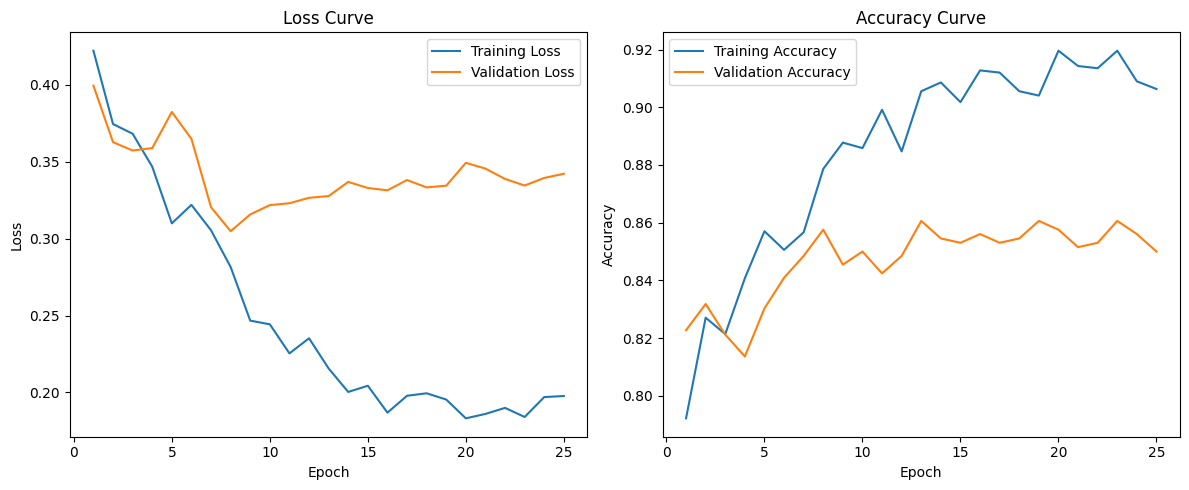

100%|██████████| 21/21 [00:01<00:00, 13.25it/s]


Classification Report:
              precision    recall  f1-score   support

      benign       0.88      0.87      0.87       360
   malignant       0.84      0.85      0.85       300

    accuracy                           0.86       660
   macro avg       0.86      0.86      0.86       660
weighted avg       0.86      0.86      0.86       660



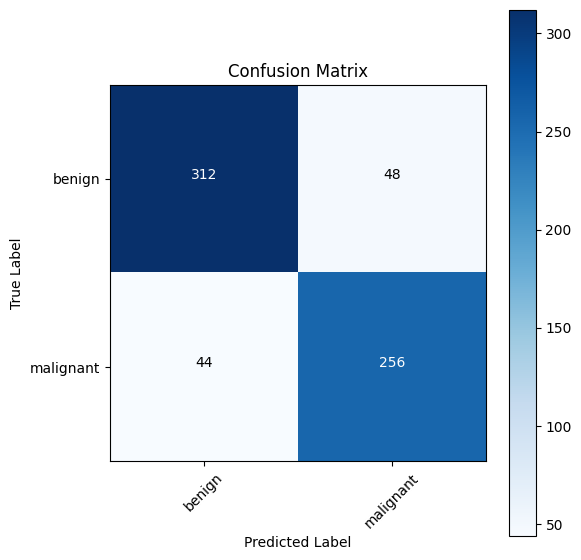

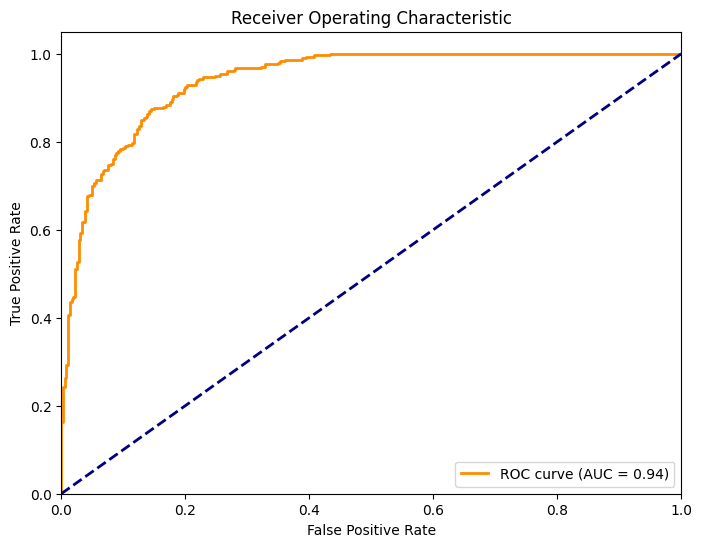

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm

# ===============================
# 1. Reproducibility & Device Setup
# ===============================
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===============================
# 2. Data Preparation & Augmentation
# ===============================
# Adjust these paths as per your dataset structure.
data_dir = '/kaggle/input/k-mean-clustering/segmented_data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Data augmentation for training and simple transforms for testing.
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets using ImageFolder (ensure your folder names match)
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# -------------------------------
# Visualization 1: Pie Chart of Class Distribution
# -------------------------------
def plot_class_distribution(dataset):
    class_names = dataset.classes
    class_counts = {class_name: 0 for class_name in class_names}
    for _, label in dataset.imgs:
        class_counts[class_names[label]] += 1
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Class Distribution')
    plt.show()

plot_class_distribution(train_dataset)

# Create DataLoaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# ===============================
# 3. Model Initialization & Fine-Tuning
# ===============================
# Load pre-trained ResNet50 and modify the final layer for 2 classes.
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# ===============================
# 4. Training Function
# ===============================
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store training history for visualization.
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set to training mode.
                dataloader = train_loader
            else:
                model.eval()   # Set to evaluation mode.
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            # Deep copy the model if performance improves.
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Val Acc: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    return model, history

# Train the model (adjust the number of epochs as needed)
num_epochs = 25
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

# -------------------------------
# Visualization 2: Accuracy & Loss Curves
# -------------------------------
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12,5))
    
    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

# ===============================
# 5. Model Evaluation on Test Set
# ===============================
model_ft.eval()
all_preds = []
all_probs = []  # Store probabilities for the positive class (malignant)
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Probability for class 1
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# -------------------------------
# Visualization 3: Classification Report
# -------------------------------
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# -------------------------------
# Visualization 4: Confusion Matrix
# -------------------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.classes))
plt.xticks(tick_marks, train_dataset.classes, rotation=45)
plt.yticks(tick_marks, train_dataset.classes)

thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# -------------------------------
# Visualization 5: ROC Curve and AUC
# -------------------------------
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


**DenseNet201**

Using device: cuda:0
Train Set Distribution:


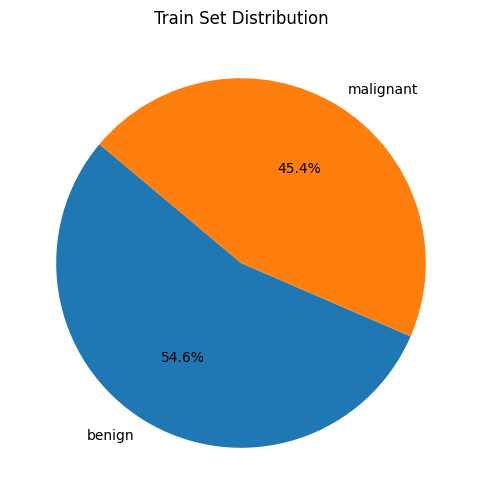

Test Set Distribution:


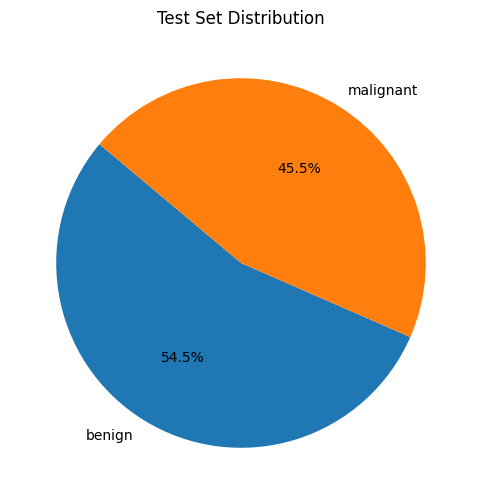

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 222MB/s]


Epoch 1/25
----------


train: 100%|██████████| 165/165 [00:30<00:00,  5.50it/s]


Train Loss: 0.5082 Acc: 0.7516


val: 100%|██████████| 42/42 [00:02<00:00, 14.08it/s]


Val Loss: 0.3772 Acc: 0.8121

Epoch 2/25
----------


train: 100%|██████████| 165/165 [00:29<00:00,  5.54it/s]


Train Loss: 0.4339 Acc: 0.7952


val: 100%|██████████| 42/42 [00:02<00:00, 14.58it/s]


Val Loss: 0.3744 Acc: 0.8303

Epoch 3/25
----------


train: 100%|██████████| 165/165 [00:29<00:00,  5.51it/s]


Train Loss: 0.4199 Acc: 0.8002


val: 100%|██████████| 42/42 [00:02<00:00, 14.56it/s]


Val Loss: 0.3317 Acc: 0.8439

Epoch 4/25
----------


train: 100%|██████████| 165/165 [00:29<00:00,  5.56it/s]


Train Loss: 0.4053 Acc: 0.8074


val: 100%|██████████| 42/42 [00:02<00:00, 14.61it/s]


Val Loss: 0.3689 Acc: 0.8242

Epoch 5/25
----------


train: 100%|██████████| 165/165 [00:29<00:00,  5.55it/s]


Train Loss: 0.3908 Acc: 0.8180


val: 100%|██████████| 42/42 [00:02<00:00, 14.48it/s]


Val Loss: 0.3660 Acc: 0.8136

Epoch 6/25
----------


train: 100%|██████████| 165/165 [00:29<00:00,  5.52it/s]


Train Loss: 0.3656 Acc: 0.8252


val: 100%|██████████| 42/42 [00:02<00:00, 14.47it/s]


Val Loss: 0.3651 Acc: 0.8439

Epoch 7/25
----------


train: 100%|██████████| 165/165 [00:29<00:00,  5.55it/s]


Train Loss: 0.3830 Acc: 0.8210


val: 100%|██████████| 42/42 [00:02<00:00, 14.53it/s]


Val Loss: 0.3179 Acc: 0.8364

Epoch 8/25
----------


train: 100%|██████████| 165/165 [00:29<00:00,  5.55it/s]


Train Loss: 0.3376 Acc: 0.8495


val: 100%|██████████| 42/42 [00:02<00:00, 14.17it/s]


Val Loss: 0.3061 Acc: 0.8515

Epoch 9/25
----------


train: 100%|██████████| 165/165 [00:29<00:00,  5.55it/s]


Train Loss: 0.3167 Acc: 0.8593


val: 100%|██████████| 42/42 [00:02<00:00, 14.50it/s]


Val Loss: 0.3022 Acc: 0.8636

Epoch 10/25
----------


train: 100%|██████████| 165/165 [00:29<00:00,  5.54it/s]


Train Loss: 0.3049 Acc: 0.8699


val: 100%|██████████| 42/42 [00:02<00:00, 14.60it/s]


Val Loss: 0.3081 Acc: 0.8576

Epoch 11/25
----------


train: 100%|██████████| 165/165 [00:30<00:00,  5.50it/s]


Train Loss: 0.2896 Acc: 0.8695


val: 100%|██████████| 42/42 [00:03<00:00, 13.94it/s]


Val Loss: 0.3025 Acc: 0.8621

Epoch 12/25
----------


train: 100%|██████████| 165/165 [00:29<00:00,  5.53it/s]


Train Loss: 0.2764 Acc: 0.8760


val: 100%|██████████| 42/42 [00:02<00:00, 14.55it/s]


Val Loss: 0.3027 Acc: 0.8727

Epoch 13/25
----------


train: 100%|██████████| 165/165 [00:29<00:00,  5.55it/s]


Train Loss: 0.2757 Acc: 0.8779


val: 100%|██████████| 42/42 [00:02<00:00, 14.54it/s]


Val Loss: 0.3073 Acc: 0.8606

Epoch 14/25
----------


train: 100%|██████████| 165/165 [00:29<00:00,  5.54it/s]


Train Loss: 0.2667 Acc: 0.8843


val: 100%|██████████| 42/42 [00:02<00:00, 14.51it/s]


Val Loss: 0.2979 Acc: 0.8727

Epoch 15/25
----------


train: 100%|██████████| 165/165 [00:29<00:00,  5.54it/s]


Train Loss: 0.2778 Acc: 0.8756


val: 100%|██████████| 42/42 [00:02<00:00, 14.54it/s]


Val Loss: 0.2986 Acc: 0.8773

Epoch 16/25
----------


train: 100%|██████████| 165/165 [00:29<00:00,  5.55it/s]


Train Loss: 0.2654 Acc: 0.8752


val: 100%|██████████| 42/42 [00:02<00:00, 14.54it/s]


Val Loss: 0.3016 Acc: 0.8636

Epoch 17/25
----------


train: 100%|██████████| 165/165 [00:29<00:00,  5.56it/s]


Train Loss: 0.2651 Acc: 0.8828


val: 100%|██████████| 42/42 [00:02<00:00, 14.53it/s]


Val Loss: 0.2992 Acc: 0.8758

Epoch 18/25
----------


train: 100%|██████████| 165/165 [00:29<00:00,  5.51it/s]


Train Loss: 0.2560 Acc: 0.8859


val: 100%|██████████| 42/42 [00:02<00:00, 14.53it/s]


Val Loss: 0.2982 Acc: 0.8727

Epoch 19/25
----------


train: 100%|██████████| 165/165 [00:29<00:00,  5.55it/s]


Train Loss: 0.2585 Acc: 0.8847


val: 100%|██████████| 42/42 [00:02<00:00, 14.51it/s]


Val Loss: 0.2994 Acc: 0.8758

Epoch 20/25
----------


train: 100%|██████████| 165/165 [00:29<00:00,  5.55it/s]


Train Loss: 0.2578 Acc: 0.8859


val: 100%|██████████| 42/42 [00:02<00:00, 14.53it/s]


Val Loss: 0.2967 Acc: 0.8727

Epoch 21/25
----------


train: 100%|██████████| 165/165 [00:29<00:00,  5.55it/s]


Train Loss: 0.2609 Acc: 0.8805


val: 100%|██████████| 42/42 [00:02<00:00, 14.55it/s]


Val Loss: 0.2980 Acc: 0.8712

Epoch 22/25
----------


train: 100%|██████████| 165/165 [00:29<00:00,  5.55it/s]


Train Loss: 0.2725 Acc: 0.8768


val: 100%|██████████| 42/42 [00:02<00:00, 14.54it/s]


Val Loss: 0.2973 Acc: 0.8773

Epoch 23/25
----------


train: 100%|██████████| 165/165 [00:29<00:00,  5.55it/s]


Train Loss: 0.2518 Acc: 0.8832


val: 100%|██████████| 42/42 [00:02<00:00, 14.58it/s]


Val Loss: 0.2982 Acc: 0.8636

Epoch 24/25
----------


train: 100%|██████████| 165/165 [00:29<00:00,  5.55it/s]


Train Loss: 0.2653 Acc: 0.8752


val: 100%|██████████| 42/42 [00:02<00:00, 14.66it/s]


Val Loss: 0.2984 Acc: 0.8636

Epoch 25/25
----------


train: 100%|██████████| 165/165 [00:29<00:00,  5.55it/s]


Train Loss: 0.2650 Acc: 0.8805


val: 100%|██████████| 42/42 [00:02<00:00, 14.51it/s]


Val Loss: 0.2959 Acc: 0.8742

Training complete in 13m 38s
Best Validation Acc: 0.8773


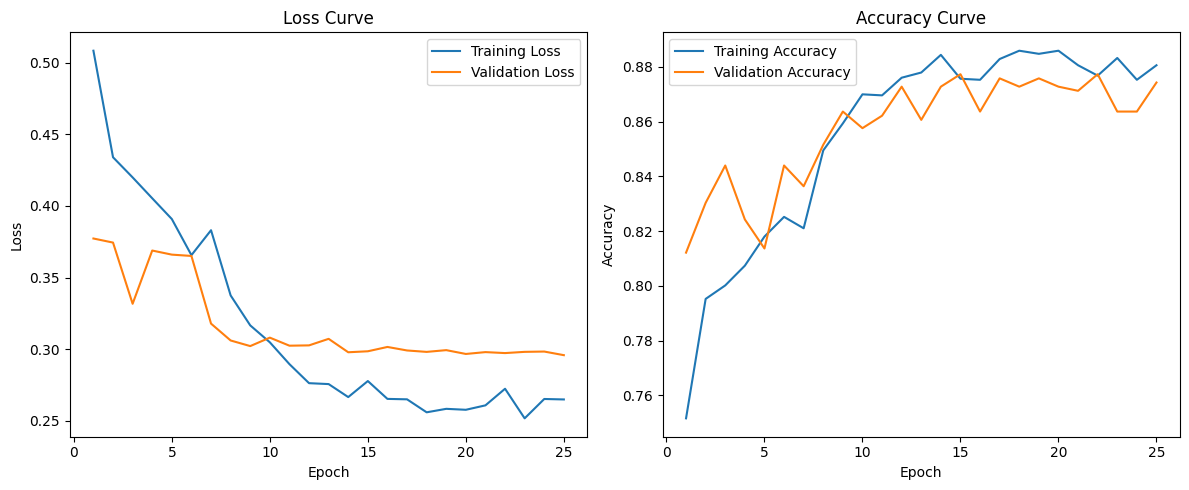

Testing: 100%|██████████| 42/42 [00:02<00:00, 14.62it/s]


Classification Report:
              precision    recall  f1-score   support

      benign       0.89      0.89      0.89       360
   malignant       0.87      0.86      0.86       300

    accuracy                           0.88       660
   macro avg       0.88      0.88      0.88       660
weighted avg       0.88      0.88      0.88       660



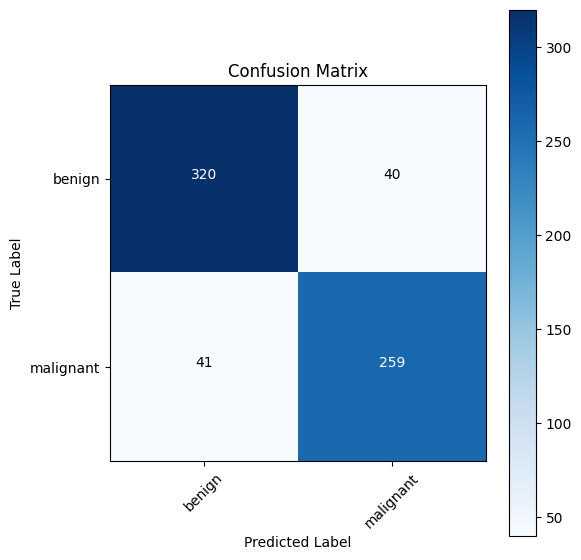

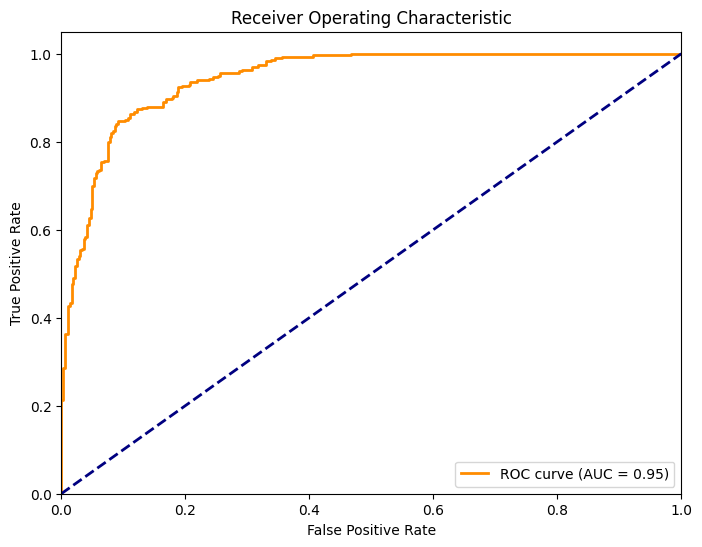

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm

########################################
# 1. Reproducibility & Device Setup
########################################
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

########################################
# 2. Data Preparation & Augmentation
########################################
# Update this path to your dataset directory
data_dir = '/kaggle/input/k-mean-clustering/segmented_data'
train_dir = os.path.join(data_dir, 'train')
test_dir  = os.path.join(data_dir, 'test')

# Define strong augmentation for training and standard transforms for testing.
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transforms)

########################################
# 3. Visualization 1: Dataset Class Distribution (Pie Chart)
########################################
def plot_class_distribution(dataset, title="Class Distribution"):
    class_names = dataset.classes
    class_counts = {name: 0 for name in class_names}
    for _, label in dataset.samples:
        class_counts[class_names[label]] += 1
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

print("Train Set Distribution:")
plot_class_distribution(train_dataset, "Train Set Distribution")
print("Test Set Distribution:")
plot_class_distribution(test_dataset, "Test Set Distribution")

########################################
# 4. DataLoaders
########################################
# Create DataLoaders (adjust batch_size as needed)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

########################################
# 5. Model Initialization & Fine-Tuning (DenseNet201)
########################################
# Load DenseNet201 with pretrained ImageNet weights.
model_dense = models.densenet201(pretrained=True)
# DenseNet201's classifier is a single linear layer stored in model_dense.classifier.
in_features = model_dense.classifier.in_features
# Replace classifier with dropout + linear layer for 2 classes.
model_dense.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, 2)
)
model_dense = model_dense.to(device)

########################################
# 6. Training Function
########################################
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        # Each epoch has a training and validation phase.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                total_samples += inputs.size(0)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Validation Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    return model, history

########################################
# 7. Set Loss Function, Optimizer, and Scheduler
########################################
criterion = nn.CrossEntropyLoss()
optimizer_dense = optim.Adam(model_dense.parameters(), lr=1e-4)
scheduler_dense = lr_scheduler.StepLR(optimizer_dense, step_size=7, gamma=0.1)

########################################
# 8. Train the Model
########################################
num_epochs = 25
model_dense, history = train_model(model_dense, criterion, optimizer_dense, scheduler_dense, num_epochs=num_epochs)

########################################
# 9. Visualization 2: Training Curves (Accuracy & Loss)
########################################
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12,5))
    
    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

########################################
# 10. Model Evaluation on Test Set
########################################
model_dense.eval()
all_preds = []
all_probs = []  # Probabilities for malignant (class index 1)
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_dense(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Class 1 probability
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

########################################
# 11. Visualization 3: Classification Report
########################################
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

########################################
# 12. Visualization 4: Confusion Matrix
########################################
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.classes))
plt.xticks(tick_marks, train_dataset.classes, rotation=45)
plt.yticks(tick_marks, train_dataset.classes)
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

########################################
# 13. Visualization 5: ROC Curve & AUC
########################################
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


**Xception via TIMM**

Using device: cuda:0
Train Set Distribution:


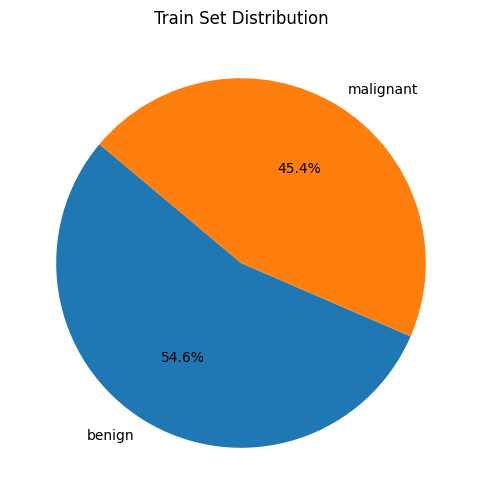

Test Set Distribution:


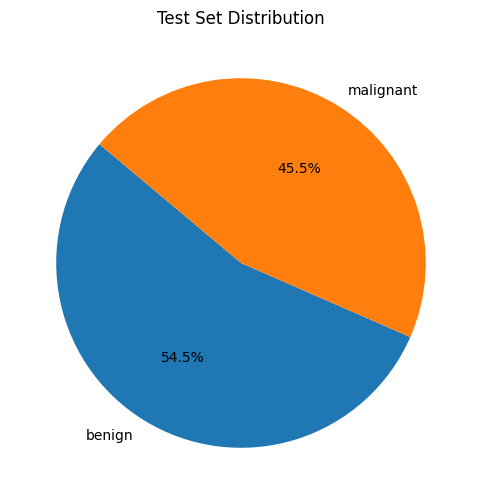

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
<ipython-input-3-04627512dee3>:119: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/25
----------


train:   0%|          | 0/165 [00:00<?, ?it/s]<ipython-input-3-04627512dee3>:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
train: 100%|██████████| 165/165 [00:26<00:00,  6.31it/s]


Train Loss: 0.4901 Acc: 0.7490


val: 100%|██████████| 42/42 [00:02<00:00, 20.05it/s]


Val Loss: 0.4107 Acc: 0.7879

Epoch 2/25
----------


train: 100%|██████████| 165/165 [00:25<00:00,  6.36it/s]


Train Loss: 0.4177 Acc: 0.7952


val: 100%|██████████| 42/42 [00:02<00:00, 20.06it/s]


Val Loss: nan Acc: 0.8136

Epoch 3/25
----------


train: 100%|██████████| 165/165 [00:25<00:00,  6.37it/s]


Train Loss: 0.4136 Acc: 0.8062


val: 100%|██████████| 42/42 [00:02<00:00, 20.12it/s]


Val Loss: 0.3695 Acc: 0.8394

Epoch 4/25
----------


train: 100%|██████████| 165/165 [00:25<00:00,  6.36it/s]


Train Loss: 0.3669 Acc: 0.8286


val: 100%|██████████| 42/42 [00:02<00:00, 20.12it/s]


Val Loss: 0.3377 Acc: 0.8485

Epoch 5/25
----------


train: 100%|██████████| 165/165 [00:25<00:00,  6.36it/s]


Train Loss: 0.3615 Acc: 0.8309


val: 100%|██████████| 42/42 [00:02<00:00, 20.16it/s]


Val Loss: 0.3789 Acc: 0.8152

Epoch 6/25
----------


train: 100%|██████████| 165/165 [00:25<00:00,  6.35it/s]


Train Loss: 0.3395 Acc: 0.8464


val: 100%|██████████| 42/42 [00:02<00:00, 19.78it/s]


Val Loss: 0.3788 Acc: 0.8121

Epoch 7/25
----------


train: 100%|██████████| 165/165 [00:26<00:00,  6.34it/s]


Train Loss: 0.3336 Acc: 0.8366


val: 100%|██████████| 42/42 [00:02<00:00, 20.09it/s]


Val Loss: 0.3343 Acc: 0.8515

Epoch 8/25
----------


train: 100%|██████████| 165/165 [00:25<00:00,  6.35it/s]


Train Loss: 0.2932 Acc: 0.8756


val: 100%|██████████| 42/42 [00:02<00:00, 20.05it/s]


Val Loss: 0.3211 Acc: 0.8576

Epoch 9/25
----------


train: 100%|██████████| 165/165 [00:26<00:00,  6.33it/s]


Train Loss: 0.2828 Acc: 0.8752


val: 100%|██████████| 42/42 [00:02<00:00, 19.70it/s]


Val Loss: 0.3245 Acc: 0.8591

Epoch 10/25
----------


train: 100%|██████████| 165/165 [00:26<00:00,  6.33it/s]


Train Loss: 0.2582 Acc: 0.8836


val: 100%|██████████| 42/42 [00:02<00:00, 19.39it/s]


Val Loss: 0.3182 Acc: 0.8561

Epoch 11/25
----------


train: 100%|██████████| 165/165 [00:26<00:00,  6.34it/s]


Train Loss: 0.2496 Acc: 0.8915


val: 100%|██████████| 42/42 [00:02<00:00, 20.06it/s]


Val Loss: 0.3112 Acc: 0.8561

Epoch 12/25
----------


train: 100%|██████████| 165/165 [00:26<00:00,  6.35it/s]


Train Loss: 0.2600 Acc: 0.8866


val: 100%|██████████| 42/42 [00:02<00:00, 19.86it/s]


Val Loss: 0.3273 Acc: 0.8576

Epoch 13/25
----------


train: 100%|██████████| 165/165 [00:26<00:00,  6.33it/s]


Train Loss: 0.2478 Acc: 0.8889


val: 100%|██████████| 42/42 [00:02<00:00, 17.69it/s]


Val Loss: 0.3121 Acc: 0.8621

Epoch 14/25
----------


train: 100%|██████████| 165/165 [00:26<00:00,  6.30it/s]


Train Loss: 0.2443 Acc: 0.8904


val: 100%|██████████| 42/42 [00:02<00:00, 19.13it/s]


Val Loss: 0.3289 Acc: 0.8591

Epoch 15/25
----------


train: 100%|██████████| 165/165 [00:26<00:00,  6.33it/s]


Train Loss: 0.2400 Acc: 0.8900


val: 100%|██████████| 42/42 [00:02<00:00, 19.78it/s]


Val Loss: 0.3242 Acc: 0.8667

Epoch 16/25
----------


train: 100%|██████████| 165/165 [00:26<00:00,  6.34it/s]


Train Loss: 0.2373 Acc: 0.8942


val: 100%|██████████| 42/42 [00:02<00:00, 19.91it/s]


Val Loss: 0.3163 Acc: 0.8591

Epoch 17/25
----------


train: 100%|██████████| 165/165 [00:26<00:00,  6.34it/s]


Train Loss: 0.2485 Acc: 0.8881


val: 100%|██████████| 42/42 [00:02<00:00, 19.88it/s]


Val Loss: 0.3235 Acc: 0.8530

Epoch 18/25
----------


train: 100%|██████████| 165/165 [00:26<00:00,  6.33it/s]


Train Loss: 0.2358 Acc: 0.8953


val: 100%|██████████| 42/42 [00:02<00:00, 19.64it/s]


Val Loss: 0.3217 Acc: 0.8576

Epoch 19/25
----------


train: 100%|██████████| 165/165 [00:26<00:00,  6.33it/s]


Train Loss: 0.2348 Acc: 0.8991


val: 100%|██████████| 42/42 [00:02<00:00, 19.94it/s]


Val Loss: 0.3152 Acc: 0.8621

Epoch 20/25
----------


train: 100%|██████████| 165/165 [00:26<00:00,  6.33it/s]


Train Loss: 0.2296 Acc: 0.9033


val: 100%|██████████| 42/42 [00:02<00:00, 19.52it/s]


Val Loss: 0.3245 Acc: 0.8576

Epoch 21/25
----------


train: 100%|██████████| 165/165 [00:26<00:00,  6.33it/s]


Train Loss: 0.2255 Acc: 0.8980


val: 100%|██████████| 42/42 [00:02<00:00, 19.79it/s]


Val Loss: 0.3232 Acc: 0.8591

Epoch 22/25
----------


train: 100%|██████████| 165/165 [00:26<00:00,  6.34it/s]


Train Loss: 0.2348 Acc: 0.8976


val: 100%|██████████| 42/42 [00:02<00:00, 19.90it/s]


Val Loss: 0.3231 Acc: 0.8636

Epoch 23/25
----------


train: 100%|██████████| 165/165 [00:26<00:00,  6.34it/s]


Train Loss: 0.2407 Acc: 0.8950


val: 100%|██████████| 42/42 [00:02<00:00, 19.78it/s]


Val Loss: 0.3237 Acc: 0.8606

Epoch 24/25
----------


train: 100%|██████████| 165/165 [00:26<00:00,  6.31it/s]


Train Loss: 0.2314 Acc: 0.9006


val: 100%|██████████| 42/42 [00:02<00:00, 19.85it/s]


Val Loss: 0.3155 Acc: 0.8636

Epoch 25/25
----------


train: 100%|██████████| 165/165 [00:26<00:00,  6.33it/s]


Train Loss: 0.2349 Acc: 0.8972


val: 100%|██████████| 42/42 [00:02<00:00, 19.81it/s]


Val Loss: 0.3168 Acc: 0.8576

Training complete in 11m 45s
Best Validation Acc: 0.8667


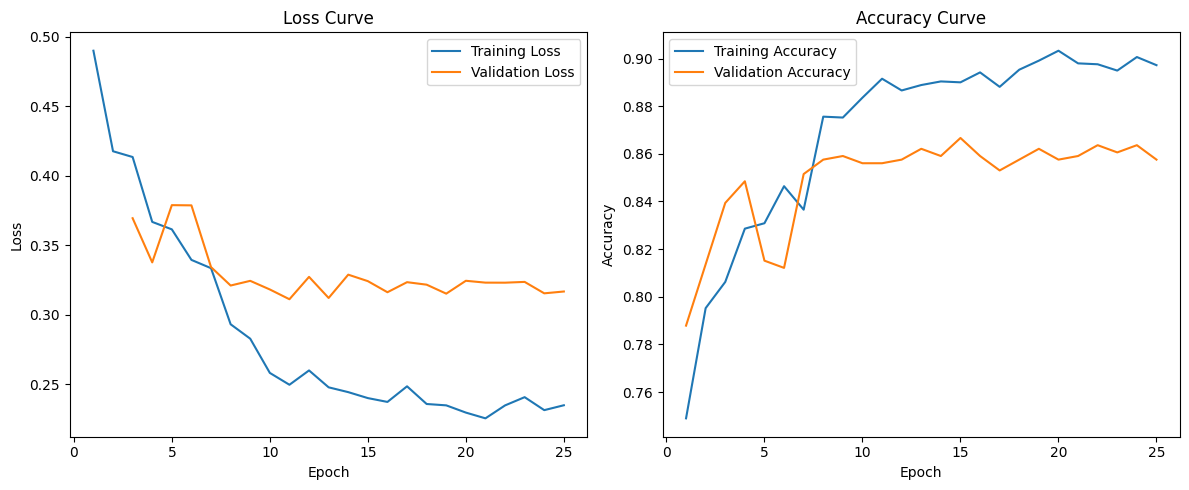

Testing: 100%|██████████| 42/42 [00:02<00:00, 18.81it/s]


Classification Report:
              precision    recall  f1-score   support

      benign       0.90      0.85      0.87       360
   malignant       0.83      0.89      0.86       300

    accuracy                           0.87       660
   macro avg       0.86      0.87      0.86       660
weighted avg       0.87      0.87      0.87       660



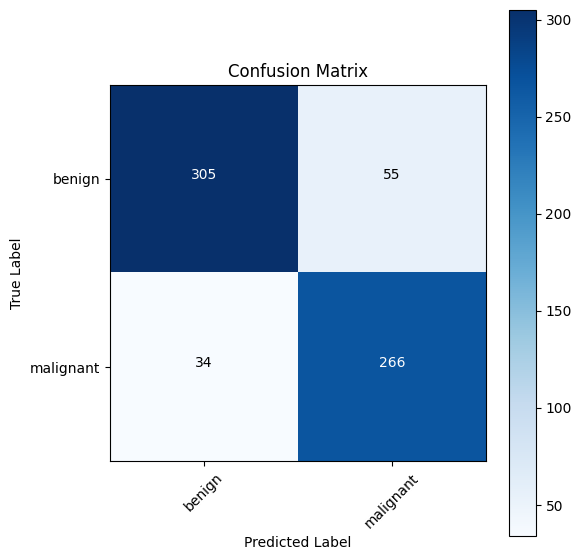

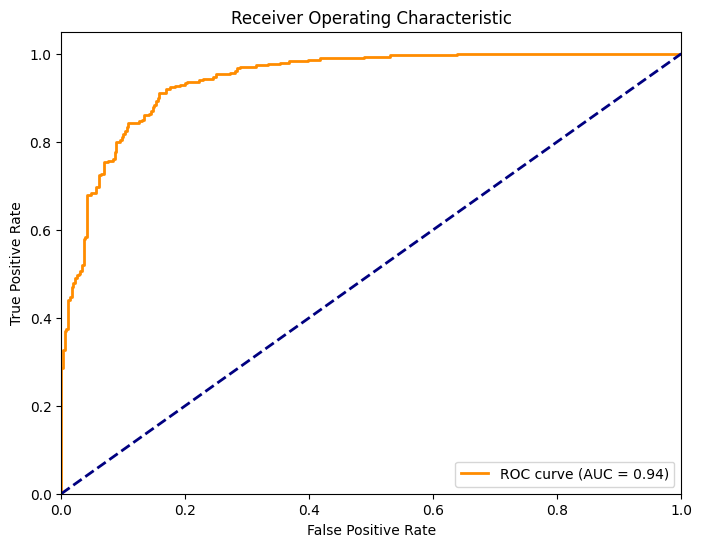

In [3]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm
import timm  # PyTorch Image Models

########################################
# 1. Reproducibility & Device Setup
########################################
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

########################################
# 2. Data Preparation & Augmentation
########################################
# Dataset folder structure:
# data/
#   train/
#     benign/
#     malignant/
#   test/
#     benign/
#     malignant/

data_dir = '/kaggle/input/k-mean-clustering/segmented_data'  # Update this path as needed
train_dir = os.path.join(data_dir, 'train')
test_dir  = os.path.join(data_dir, 'test')

# Define strong augmentations for training and standard transforms for testing.
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets using ImageFolder.
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transforms)

########################################
# 3. Visualization 1: Dataset Class Distribution (Pie Chart)
########################################
def plot_class_distribution(dataset, title="Class Distribution"):
    class_names = dataset.classes
    class_counts = {name: 0 for name in class_names}
    for _, label in dataset.samples:
        class_counts[class_names[label]] += 1
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

print("Train Set Distribution:")
plot_class_distribution(train_dataset, "Train Set Distribution")
print("Test Set Distribution:")
plot_class_distribution(test_dataset, "Test Set Distribution")

########################################
# 4. DataLoaders
########################################
# Adjust batch_size as needed (lower if encountering memory issues)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

########################################
# 5. Model Initialization & Fine-Tuning (Xception)
########################################
# Using TIMM to create the Xception model. Ensure timm is installed (pip install timm)
model_xception = timm.create_model('xception', pretrained=True, num_classes=2)
model_xception = model_xception.to(device)

########################################
# 6. Training Function
########################################
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # History lists for visualization.
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    # Optionally use AMP for mixed precision training to speed up training and reduce memory
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                total_samples += inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Validation Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    return model, history

########################################
# 7. Set Loss Function, Optimizer, and Scheduler
########################################
criterion = nn.CrossEntropyLoss()
optimizer_xception = optim.Adam(model_xception.parameters(), lr=1e-4)
scheduler_xception = lr_scheduler.StepLR(optimizer_xception, step_size=7, gamma=0.1)

########################################
# 8. Train the Model
########################################
num_epochs = 25
model_xception, history = train_model(model_xception, criterion, optimizer_xception, scheduler_xception, num_epochs=num_epochs)

########################################
# 9. Visualization 2: Training Curves (Accuracy & Loss)
########################################
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12,5))
    
    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

########################################
# 10. Model Evaluation on Test Set
########################################
model_xception.eval()
all_preds = []
all_probs = []  # Probabilities for malignant (class index 1)
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_xception(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Probability for class 1
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

########################################
# 11. Visualization 3: Classification Report
########################################
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

########################################
# 12. Visualization 4: Confusion Matrix
########################################
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.classes))
plt.xticks(tick_marks, train_dataset.classes, rotation=45)
plt.yticks(tick_marks, train_dataset.classes)
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

########################################
# 13. Visualization 5: ROC Curve & AUC
########################################
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


**InceptionV3**

Using device: cuda:0
Train Set Distribution:


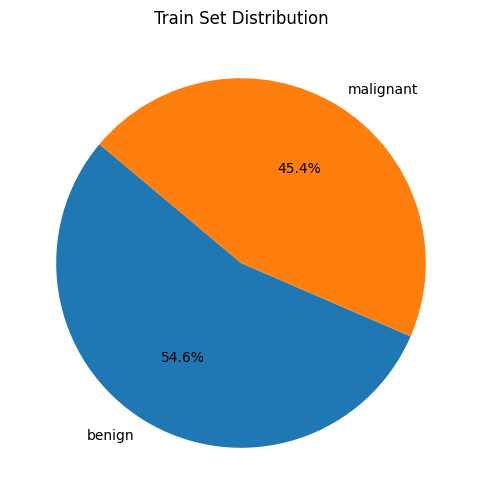

Test Set Distribution:


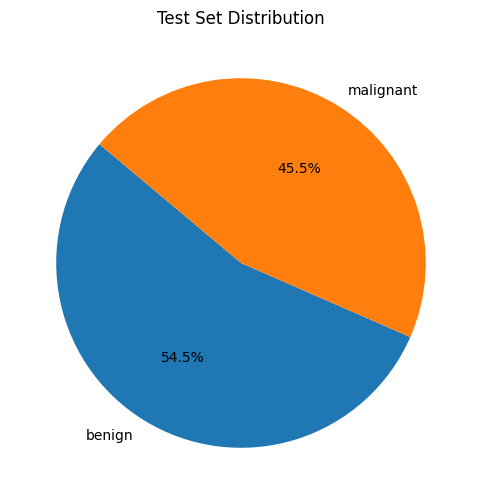

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 168MB/s]  


Epoch 1/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.72it/s]


Train Loss: 0.4995 Acc: 0.7596


val: 100%|██████████| 42/42 [00:02<00:00, 16.92it/s]


Val Loss: 0.3934 Acc: 0.8121

Epoch 2/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.75it/s]


Train Loss: 0.4326 Acc: 0.7990


val: 100%|██████████| 42/42 [00:02<00:00, 16.36it/s]


Val Loss: 0.3913 Acc: 0.8197

Epoch 3/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.75it/s]


Train Loss: 0.4108 Acc: 0.8020


val: 100%|██████████| 42/42 [00:02<00:00, 17.61it/s]


Val Loss: 0.3547 Acc: 0.8364

Epoch 4/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.75it/s]


Train Loss: 0.3895 Acc: 0.8142


val: 100%|██████████| 42/42 [00:02<00:00, 16.75it/s]


Val Loss: 0.4135 Acc: 0.8242

Epoch 5/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.75it/s]


Train Loss: 0.3723 Acc: 0.8350


val: 100%|██████████| 42/42 [00:02<00:00, 17.52it/s]


Val Loss: 0.3798 Acc: 0.8439

Epoch 6/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.75it/s]


Train Loss: 0.3768 Acc: 0.8237


val: 100%|██████████| 42/42 [00:02<00:00, 17.32it/s]


Val Loss: 0.3564 Acc: 0.8409

Epoch 7/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.75it/s]


Train Loss: 0.3400 Acc: 0.8536


val: 100%|██████████| 42/42 [00:02<00:00, 16.87it/s]


Val Loss: 0.3472 Acc: 0.8424

Epoch 8/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.75it/s]


Train Loss: 0.3174 Acc: 0.8593


val: 100%|██████████| 42/42 [00:02<00:00, 17.48it/s]


Val Loss: 0.3327 Acc: 0.8485

Epoch 9/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.76it/s]


Train Loss: 0.3029 Acc: 0.8578


val: 100%|██████████| 42/42 [00:02<00:00, 17.63it/s]


Val Loss: 0.3270 Acc: 0.8485

Epoch 10/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.73it/s]


Train Loss: 0.2835 Acc: 0.8684


val: 100%|██████████| 42/42 [00:02<00:00, 17.51it/s]


Val Loss: 0.3236 Acc: 0.8545

Epoch 11/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.75it/s]


Train Loss: 0.2959 Acc: 0.8669


val: 100%|██████████| 42/42 [00:02<00:00, 17.51it/s]


Val Loss: 0.3238 Acc: 0.8530

Epoch 12/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.73it/s]


Train Loss: 0.2565 Acc: 0.8832


val: 100%|██████████| 42/42 [00:02<00:00, 17.36it/s]


Val Loss: 0.3214 Acc: 0.8682

Epoch 13/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.74it/s]


Train Loss: 0.2735 Acc: 0.8703


val: 100%|██████████| 42/42 [00:02<00:00, 16.80it/s]


Val Loss: 0.3220 Acc: 0.8591

Epoch 14/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.73it/s]


Train Loss: 0.2457 Acc: 0.8874


val: 100%|██████████| 42/42 [00:02<00:00, 17.48it/s]


Val Loss: 0.3441 Acc: 0.8545

Epoch 15/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.74it/s]


Train Loss: 0.2570 Acc: 0.8896


val: 100%|██████████| 42/42 [00:02<00:00, 17.50it/s]


Val Loss: 0.3439 Acc: 0.8576

Epoch 16/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.76it/s]


Train Loss: 0.2601 Acc: 0.8900


val: 100%|██████████| 42/42 [00:02<00:00, 17.56it/s]


Val Loss: 0.3320 Acc: 0.8591

Epoch 17/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.76it/s]


Train Loss: 0.2717 Acc: 0.8779


val: 100%|██████████| 42/42 [00:02<00:00, 17.54it/s]


Val Loss: 0.3346 Acc: 0.8591

Epoch 18/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.75it/s]


Train Loss: 0.2544 Acc: 0.8862


val: 100%|██████████| 42/42 [00:02<00:00, 17.64it/s]


Val Loss: 0.3358 Acc: 0.8515

Epoch 19/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.75it/s]


Train Loss: 0.2478 Acc: 0.8938


val: 100%|██████████| 42/42 [00:02<00:00, 17.71it/s]


Val Loss: 0.3306 Acc: 0.8561

Epoch 20/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.75it/s]


Train Loss: 0.2487 Acc: 0.8889


val: 100%|██████████| 42/42 [00:02<00:00, 17.66it/s]


Val Loss: 0.3336 Acc: 0.8591

Epoch 21/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.74it/s]


Train Loss: 0.2587 Acc: 0.8836


val: 100%|██████████| 42/42 [00:02<00:00, 17.51it/s]


Val Loss: 0.3313 Acc: 0.8576

Epoch 22/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.74it/s]


Train Loss: 0.2531 Acc: 0.8938


val: 100%|██████████| 42/42 [00:02<00:00, 16.67it/s]


Val Loss: 0.3288 Acc: 0.8561

Epoch 23/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.76it/s]


Train Loss: 0.2358 Acc: 0.8953


val: 100%|██████████| 42/42 [00:02<00:00, 16.24it/s]


Val Loss: 0.3241 Acc: 0.8621

Epoch 24/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.75it/s]


Train Loss: 0.2487 Acc: 0.8885


val: 100%|██████████| 42/42 [00:02<00:00, 15.69it/s]


Val Loss: 0.3347 Acc: 0.8591

Epoch 25/25
----------


train: 100%|██████████| 165/165 [00:28<00:00,  5.76it/s]


Train Loss: 0.2516 Acc: 0.8904


val: 100%|██████████| 42/42 [00:02<00:00, 17.11it/s]


Val Loss: 0.3310 Acc: 0.8576

Training complete in 12m 60s
Best Validation Acc: 0.8682


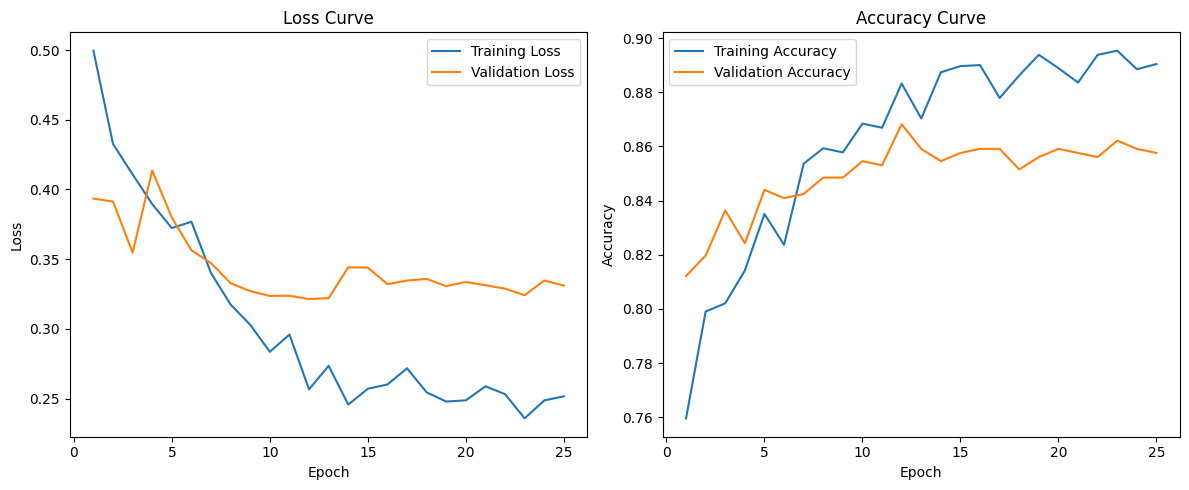

Testing: 100%|██████████| 42/42 [00:02<00:00, 16.81it/s]


Classification Report:
              precision    recall  f1-score   support

      benign       0.89      0.87      0.88       360
   malignant       0.84      0.87      0.86       300

    accuracy                           0.87       660
   macro avg       0.87      0.87      0.87       660
weighted avg       0.87      0.87      0.87       660



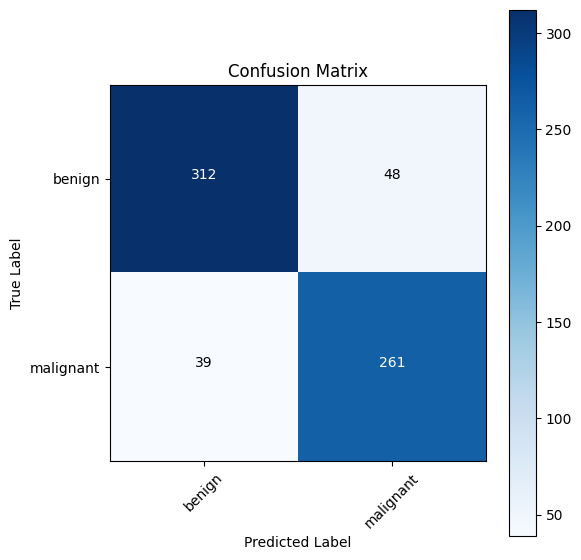

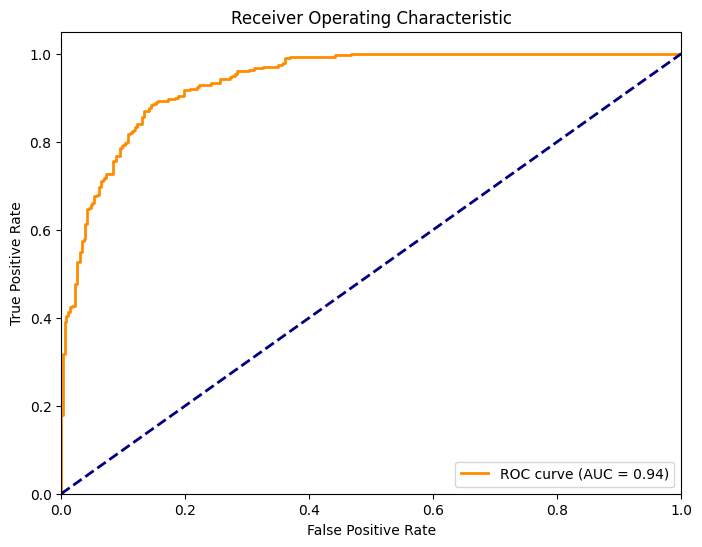

In [4]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm

########################################
# 1. Reproducibility & Device Setup
########################################
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

########################################
# 2. Data Preparation & Augmentation
########################################
# Dataset directory structure:
# data/
#   ..train/
#     benign/
#     malignant/
#   test/
#     benign/
#     malignant/
data_dir = '/kaggle/input/k-mean-clustering/segmented_data'  # Update as needed
train_dir = os.path.join(data_dir, 'train')
test_dir  = os.path.join(data_dir, 'test')

# InceptionV3 expects 299x299 images.
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize(320),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transforms)

########################################
# 3. Visualization 1: Dataset Class Distribution (Pie Chart)
########################################
def plot_class_distribution(dataset, title="Class Distribution"):
    class_names = dataset.classes
    class_counts = {name: 0 for name in class_names}
    for _, label in dataset.samples:
        class_counts[class_names[label]] += 1
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

print("Train Set Distribution:")
plot_class_distribution(train_dataset, "Train Set Distribution")
print("Test Set Distribution:")
plot_class_distribution(test_dataset, "Test Set Distribution")

########################################
# 4. DataLoaders
########################################
batch_size = 16  # Adjust if needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

########################################
# 5. Model Initialization & Fine-Tuning (InceptionV3)
########################################
# Using the new weights API. Note: When using pretrained weights, aux_logits must be True.
from torchvision.models import inception_v3, Inception_V3_Weights
weights = Inception_V3_Weights.IMAGENET1K_V1
model_inception = inception_v3(weights=weights, aux_logits=True)
# Replace the final fully connected layer. The default fc has in_features = 2048.
in_features = model_inception.fc.in_features
model_inception.fc = nn.Linear(in_features, 2)
model_inception = model_inception.to(device)

########################################
# 6. Training Function
########################################
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        
        # Each epoch has training and validation phases.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # If outputs is a tuple (Inception returns (main, aux) when aux_logits=True), take only the primary output.
                    if isinstance(outputs, tuple):
                        outputs = outputs[0]
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                total_samples += inputs.size(0)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Validation Acc: {best_acc:.4f}")
    
    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    return model, history

########################################
# 7. Set Loss Function, Optimizer, and Scheduler
########################################
criterion = nn.CrossEntropyLoss()
optimizer_inception = optim.Adam(model_inception.parameters(), lr=1e-4)
scheduler_inception = lr_scheduler.StepLR(optimizer_inception, step_size=7, gamma=0.1)

########################################
# 8. Train the Model
########################################
num_epochs = 25
model_inception, history = train_model(model_inception, criterion, optimizer_inception, scheduler_inception, num_epochs=num_epochs)

########################################
# 9. Visualization 2: Training Curves (Accuracy & Loss)
########################################
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12,5))
    
    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

########################################
# 10. Model Evaluation on Test Set
########################################
model_inception.eval()
all_preds = []
all_probs = []  # Probabilities for malignant (class index 1)
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_inception(inputs)
        # Use only the primary output
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Probability for class 1
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

########################################
# 11. Visualization 3: Classification Report
########################################
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

########################################
# 12. Visualization 4: Confusion Matrix
########################################
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.classes))
plt.xticks(tick_marks, train_dataset.classes, rotation=45)
plt.yticks(tick_marks, train_dataset.classes)
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

########################################
# 13. Visualization 5: ROC Curve & AUC
########################################
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# EfficientNetV2‑L 

In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


Using device: cuda:0
Train Set Distribution:


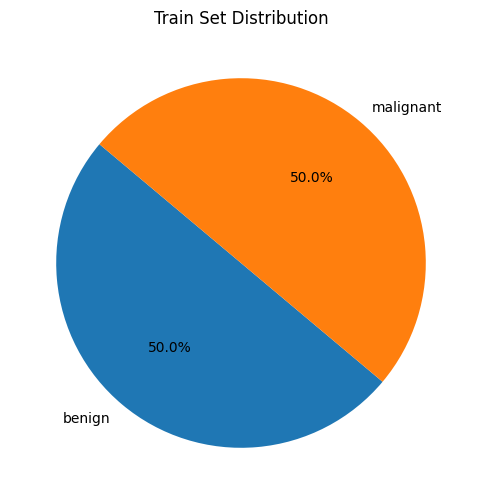

Test Set Distribution:


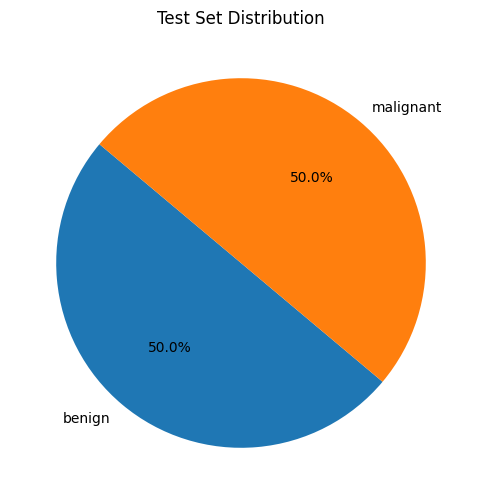

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:08<00:00, 59.0MB/s] 


==================== Fold 1/5 ====================


<ipython-input-1-ea2fae48a96a>:116: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/25
----------


train:   0%|          | 0/360 [00:00<?, ?it/s]<ipython-input-1-ea2fae48a96a>:140: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
train: 100%|██████████| 360/360 [01:53<00:00,  3.18it/s]


Train Loss: 0.5118 Acc: 0.7462


val: 100%|██████████| 90/90 [00:06<00:00, 13.31it/s]


Val Loss: 0.4095 Acc: 0.7986

Epoch 2/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.25it/s]


Train Loss: 0.4807 Acc: 0.7590


val: 100%|██████████| 90/90 [00:06<00:00, 13.16it/s]


Val Loss: 0.3361 Acc: 0.8361

Epoch 3/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.26it/s]


Train Loss: 0.4491 Acc: 0.7833


val: 100%|██████████| 90/90 [00:06<00:00, 13.28it/s]


Val Loss: 0.3494 Acc: 0.8250

Epoch 4/25
----------


train: 100%|██████████| 360/360 [01:51<00:00,  3.24it/s]


Train Loss: 0.4282 Acc: 0.7934


val: 100%|██████████| 90/90 [00:06<00:00, 13.16it/s]


Val Loss: 0.3463 Acc: 0.8486

Epoch 5/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.27it/s]


Train Loss: 0.4033 Acc: 0.8010


val: 100%|██████████| 90/90 [00:06<00:00, 13.34it/s]


Val Loss: 0.3218 Acc: 0.8625

Epoch 6/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.25it/s]


Train Loss: 0.3879 Acc: 0.8174


val: 100%|██████████| 90/90 [00:06<00:00, 13.16it/s]


Val Loss: 0.3714 Acc: 0.8181

Epoch 7/25
----------


train: 100%|██████████| 360/360 [01:51<00:00,  3.24it/s]


Train Loss: 0.3889 Acc: 0.8219


val: 100%|██████████| 90/90 [00:06<00:00, 13.23it/s]


Val Loss: 0.3172 Acc: 0.8569

Epoch 8/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.25it/s]


Train Loss: 0.3367 Acc: 0.8490


val: 100%|██████████| 90/90 [00:06<00:00, 13.01it/s]


Val Loss: 0.3267 Acc: 0.8583

Epoch 9/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.26it/s]


Train Loss: 0.3199 Acc: 0.8479


val: 100%|██████████| 90/90 [00:06<00:00, 13.16it/s]


Val Loss: 0.2957 Acc: 0.8639

Epoch 10/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.25it/s]


Train Loss: 0.3136 Acc: 0.8490


val: 100%|██████████| 90/90 [00:06<00:00, 13.16it/s]


Val Loss: 0.3017 Acc: 0.8667

Epoch 11/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.25it/s]


Train Loss: 0.3078 Acc: 0.8712


val: 100%|██████████| 90/90 [00:06<00:00, 13.21it/s]


Val Loss: 0.2846 Acc: 0.8778

Epoch 12/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.25it/s]


Train Loss: 0.2962 Acc: 0.8618


val: 100%|██████████| 90/90 [00:06<00:00, 13.19it/s]


Val Loss: 0.2936 Acc: 0.8694

Epoch 13/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.25it/s]


Train Loss: 0.2952 Acc: 0.8681


val: 100%|██████████| 90/90 [00:06<00:00, 13.21it/s]


Val Loss: 0.2841 Acc: 0.8736

Epoch 14/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.26it/s]


Train Loss: 0.2823 Acc: 0.8715


val: 100%|██████████| 90/90 [00:06<00:00, 13.26it/s]


Val Loss: 0.2801 Acc: 0.8750

Epoch 15/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.26it/s]


Train Loss: 0.2705 Acc: 0.8778


val: 100%|██████████| 90/90 [00:06<00:00, 13.28it/s]


Val Loss: 0.2819 Acc: 0.8681

Epoch 16/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.24it/s]


Train Loss: 0.2849 Acc: 0.8701


val: 100%|██████████| 90/90 [00:06<00:00, 13.09it/s]


Val Loss: 0.2860 Acc: 0.8736

Epoch 17/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.25it/s]


Train Loss: 0.2695 Acc: 0.8771


val: 100%|██████████| 90/90 [00:06<00:00, 13.14it/s]


Val Loss: 0.2826 Acc: 0.8722

Epoch 18/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.26it/s]


Train Loss: 0.2754 Acc: 0.8764


val: 100%|██████████| 90/90 [00:06<00:00, 13.35it/s]


Val Loss: 0.2876 Acc: 0.8681

Epoch 19/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.25it/s]


Train Loss: 0.2677 Acc: 0.8809


val: 100%|██████████| 90/90 [00:06<00:00, 13.26it/s]


Val Loss: 0.2872 Acc: 0.8694

Epoch 20/25
----------


train: 100%|██████████| 360/360 [01:51<00:00,  3.24it/s]


Train Loss: 0.2777 Acc: 0.8851


val: 100%|██████████| 90/90 [00:06<00:00, 13.18it/s]


Val Loss: 0.2881 Acc: 0.8653

Epoch 21/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.25it/s]


Train Loss: 0.2678 Acc: 0.8760


val: 100%|██████████| 90/90 [00:06<00:00, 13.19it/s]


Val Loss: 0.2923 Acc: 0.8611

Epoch 22/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.26it/s]


Train Loss: 0.2709 Acc: 0.8781


val: 100%|██████████| 90/90 [00:06<00:00, 13.30it/s]


Val Loss: 0.2931 Acc: 0.8667

Epoch 23/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.25it/s]


Train Loss: 0.2553 Acc: 0.8878


val: 100%|██████████| 90/90 [00:06<00:00, 13.28it/s]


Val Loss: 0.2874 Acc: 0.8653

Epoch 24/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.26it/s]


Train Loss: 0.2594 Acc: 0.8778


val: 100%|██████████| 90/90 [00:06<00:00, 13.17it/s]


Val Loss: 0.3006 Acc: 0.8597

Epoch 25/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.26it/s]


Train Loss: 0.2482 Acc: 0.8872


val: 100%|██████████| 90/90 [00:06<00:00, 13.18it/s]


Val Loss: 0.2851 Acc: 0.8750

Training complete in 49m 1s
Best Validation Acc: 0.8778
Fold 1 best Val Acc: 0.8778
==================== Fold 2/5 ====================
Epoch 1/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.25it/s]


Train Loss: 0.5417 Acc: 0.7312


val: 100%|██████████| 90/90 [00:06<00:00, 13.24it/s]


Val Loss: 0.4154 Acc: 0.7917

Epoch 2/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.26it/s]


Train Loss: 0.4797 Acc: 0.7632


val: 100%|██████████| 90/90 [00:06<00:00, 13.25it/s]


Val Loss: 0.3962 Acc: 0.8056

Epoch 3/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.26it/s]


Train Loss: 0.4594 Acc: 0.7729


val: 100%|██████████| 90/90 [00:06<00:00, 13.35it/s]


Val Loss: 0.3442 Acc: 0.8514

Epoch 4/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.25it/s]


Train Loss: 0.4144 Acc: 0.8031


val: 100%|██████████| 90/90 [00:06<00:00, 13.15it/s]


Val Loss: 0.3527 Acc: 0.8333

Epoch 5/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.26it/s]


Train Loss: 0.3979 Acc: 0.8243


val: 100%|██████████| 90/90 [00:06<00:00, 13.29it/s]


Val Loss: 0.3249 Acc: 0.8542

Epoch 6/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.26it/s]


Train Loss: 0.4000 Acc: 0.8080


val: 100%|██████████| 90/90 [00:06<00:00, 13.22it/s]


Val Loss: 0.3461 Acc: 0.8444

Epoch 7/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.25it/s]


Train Loss: 0.3779 Acc: 0.8212


val: 100%|██████████| 90/90 [00:06<00:00, 13.14it/s]


Val Loss: 0.3528 Acc: 0.8250

Epoch 8/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.26it/s]


Train Loss: 0.3531 Acc: 0.8469


val: 100%|██████████| 90/90 [00:06<00:00, 13.21it/s]


Val Loss: 0.2941 Acc: 0.8569

Epoch 9/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.27it/s]


Train Loss: 0.3284 Acc: 0.8583


val: 100%|██████████| 90/90 [00:06<00:00, 13.29it/s]


Val Loss: 0.2878 Acc: 0.8542

Epoch 10/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.26it/s]


Train Loss: 0.3128 Acc: 0.8576


val: 100%|██████████| 90/90 [00:06<00:00, 13.21it/s]


Val Loss: 0.2847 Acc: 0.8611

Epoch 11/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.27it/s]


Train Loss: 0.3123 Acc: 0.8628


val: 100%|██████████| 90/90 [00:06<00:00, 13.17it/s]


Val Loss: 0.2924 Acc: 0.8639

Epoch 12/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.26it/s]


Train Loss: 0.2871 Acc: 0.8701


val: 100%|██████████| 90/90 [00:06<00:00, 13.16it/s]


Val Loss: 0.2872 Acc: 0.8764

Epoch 13/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.26it/s]


Train Loss: 0.2786 Acc: 0.8760


val: 100%|██████████| 90/90 [00:06<00:00, 13.21it/s]


Val Loss: 0.2976 Acc: 0.8639

Epoch 14/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.25it/s]


Train Loss: 0.2786 Acc: 0.8705


val: 100%|██████████| 90/90 [00:06<00:00, 13.21it/s]


Val Loss: 0.2908 Acc: 0.8708

Epoch 15/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.25it/s]


Train Loss: 0.2748 Acc: 0.8729


val: 100%|██████████| 90/90 [00:06<00:00, 13.13it/s]


Val Loss: 0.2853 Acc: 0.8750

Epoch 16/25
----------


train: 100%|██████████| 360/360 [01:50<00:00,  3.26it/s]


Train Loss: 0.2623 Acc: 0.8823


val: 100%|██████████| 90/90 [00:06<00:00, 13.23it/s]


Val Loss: 0.2896 Acc: 0.8667

Epoch 17/25
----------


train:  91%|█████████ | 327/360 [01:40<00:09,  3.31it/s]

In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

########################################
# 1. Reproducibility & Device Setup
########################################
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

########################################
# 2. Data Preparation & Augmentation
########################################
# Adjust these paths to your dataset location
data_dir = '/kaggle/input/k-means-cyclegan/k-means segmented_data(cycleGAN)'
train_dir = os.path.join(data_dir, 'train')
test_dir  = os.path.join(data_dir, 'test')

# Data augmentation for training and standard transforms for testing.
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets using ImageFolder (expects subdirectories "benign" and "malignant")
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transforms)

########################################
# 3. Visualization: Dataset Class Distribution (Pie Chart)
########################################
def plot_class_distribution(dataset, title="Class Distribution"):
    class_names = dataset.classes
    class_counts = {name: 0 for name in class_names}
    for _, label in dataset.samples:
        class_counts[class_names[label]] += 1
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

print("Train Set Distribution:")
plot_class_distribution(train_dataset, "Train Set Distribution")
print("Test Set Distribution:")
plot_class_distribution(test_dataset, "Test Set Distribution")

########################################
# 4. DataLoaders
########################################
batch_size = 8  # Reduced batch size to save GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

########################################
# 5. Model Initialization & Fine-Tuning (EfficientNet_V2_L)
########################################
from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights
weights = EfficientNet_V2_L_Weights.IMAGENET1K_V1
model_ft = efficientnet_v2_l(weights=weights)
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 2)
)
model_ft = model_ft.to(device)

########################################
# 6. Training Function with Mixed Precision
########################################
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    
    # Initialize GradScaler for mixed precision training
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                total_samples += inputs.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
                scheduler.step()
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Validation Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    return model, history

########################################
# 7. K-Fold Cross Validation Training with EfficientNet_V2_L
########################################
num_folds = 5
batch_size = 8  # Use the same small batch size here
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
targets = [s[1] for s in train_dataset.samples]

fold_histories = []
best_fold_model = None
best_fold_val_acc = 0.0

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f"==================== Fold {fold+1}/{num_folds} ====================")
    from torch.utils.data import Subset
    train_subset = Subset(train_dataset, train_idx)
    val_subset   = Subset(train_dataset, val_idx)
    
    train_loader_fold = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader_fold   = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # Initialize a new EfficientNet_V2_L for the fold
    model_fold = efficientnet_v2_l(weights=weights)
    num_ftrs = model_fold.classifier[1].in_features
    model_fold.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, 2)
    )
    model_fold = model_fold.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer_fold = optim.Adam(model_fold.parameters(), lr=1e-4)
    scheduler_fold = lr_scheduler.StepLR(optimizer_fold, step_size=7, gamma=0.1)
    
    # Train on current fold
    model_fold, history = train_model(model_fold, criterion, optimizer_fold, scheduler_fold, num_epochs=25)
    fold_histories.append(history)
    
    current_best = max(history['val_acc'])
    print(f"Fold {fold+1} best Val Acc: {current_best:.4f}")
    if current_best > best_fold_val_acc:
        best_fold_val_acc = current_best
        best_fold_model = model_fold
        
    # Clear GPU memory after each fold
    del model_fold
    torch.cuda.empty_cache()

print(f"\nOverall Best Fold Val Acc: {best_fold_val_acc:.4f}")

########################################
# 8. Plot Training Curves (Best Fold)
########################################
best_history = fold_histories[np.argmax([max(h['val_acc']) for h in fold_histories])]
epochs = range(1, len(best_history['train_loss']) + 1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, best_history['train_loss'], label='Train Loss')
plt.plot(epochs, best_history['val_loss'], label='Val Loss')
plt.title('Loss Curve (Best Fold)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, best_history['train_acc'], label='Train Acc')
plt.plot(epochs, best_history['val_acc'], label='Val Acc')
plt.title('Accuracy Curve (Best Fold)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

########################################
# 9. Final Evaluation on Test Set
########################################
# Ensure the best_fold_model is available (reload if saved externally)
best_fold_model.eval()
all_preds = []
all_probs = []  # probabilities for malignant (class index 1)
all_labels = []

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = best_fold_model(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

########################################
# 10. Visualization: Classification Report
########################################
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

########################################
# 11. Visualization: Confusion Matrix
########################################
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.classes))
plt.xticks(tick_marks, train_dataset.classes, rotation=45)
plt.yticks(tick_marks, train_dataset.classes)
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

########################################
# 12. Visualization: ROC Curve & AUC
########################################
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])telegram web
telegram web

plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# EfficientNetV2‑M 

Using device: cuda:0
Train Set Distribution:


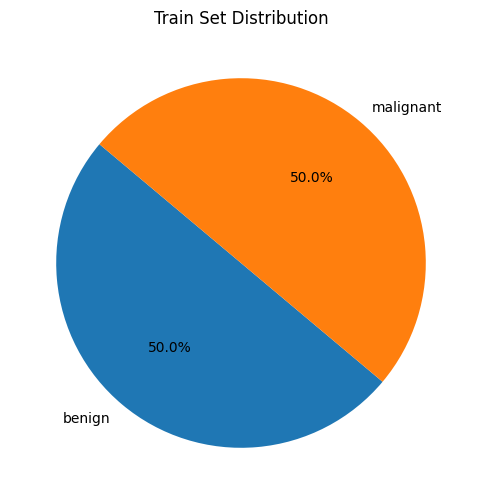

Test Set Distribution:


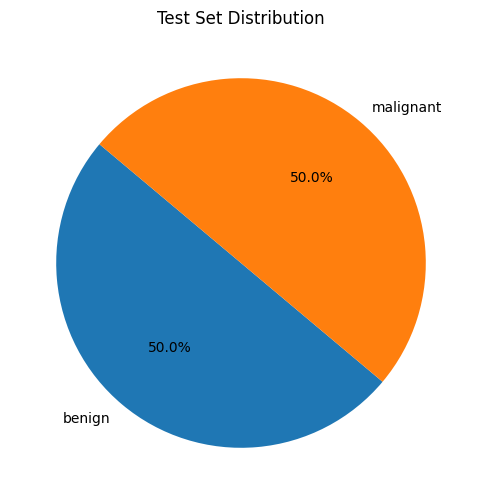

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:00<00:00, 221MB/s] 


Epoch 1/25
----------


train: 100%|██████████| 90/90 [00:40<00:00,  2.20it/s]


Train Loss: 0.4959 Acc: 0.7427


val: 100%|██████████| 23/23 [00:03<00:00,  7.55it/s]


Val Loss: 0.4238 Acc: 0.8097

Epoch 2/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Train Loss: 0.3853 Acc: 0.8135


val: 100%|██████████| 23/23 [00:03<00:00,  7.63it/s]


Val Loss: 0.3470 Acc: 0.8375

Epoch 3/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Train Loss: 0.3727 Acc: 0.8212


val: 100%|██████████| 23/23 [00:02<00:00,  7.74it/s]


Val Loss: 0.3366 Acc: 0.8361

Epoch 4/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Train Loss: 0.3614 Acc: 0.8306


val: 100%|██████████| 23/23 [00:02<00:00,  7.80it/s]


Val Loss: 0.3214 Acc: 0.8611

Epoch 5/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Train Loss: 0.3296 Acc: 0.8458


val: 100%|██████████| 23/23 [00:02<00:00,  7.71it/s]


Val Loss: 0.3370 Acc: 0.8569

Epoch 6/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Train Loss: 0.3291 Acc: 0.8351


val: 100%|██████████| 23/23 [00:02<00:00,  7.76it/s]


Val Loss: 0.3648 Acc: 0.8431

Epoch 7/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Train Loss: 0.2983 Acc: 0.8622


val: 100%|██████████| 23/23 [00:02<00:00,  7.76it/s]


Val Loss: 0.3493 Acc: 0.8403

Epoch 8/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.27it/s]


Train Loss: 0.2856 Acc: 0.8701


val: 100%|██████████| 23/23 [00:03<00:00,  7.26it/s]


Val Loss: 0.3028 Acc: 0.8681

Epoch 9/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Train Loss: 0.2596 Acc: 0.8740


val: 100%|██████████| 23/23 [00:02<00:00,  7.76it/s]


Val Loss: 0.3160 Acc: 0.8653

Epoch 10/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Train Loss: 0.2692 Acc: 0.8760


val: 100%|██████████| 23/23 [00:02<00:00,  7.78it/s]


Val Loss: 0.3170 Acc: 0.8639

Epoch 11/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Train Loss: 0.2657 Acc: 0.8740


val: 100%|██████████| 23/23 [00:03<00:00,  7.52it/s]


Val Loss: 0.3227 Acc: 0.8611

Epoch 12/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Train Loss: 0.2336 Acc: 0.8920


val: 100%|██████████| 23/23 [00:02<00:00,  7.75it/s]


Val Loss: 0.3273 Acc: 0.8681

Epoch 13/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Train Loss: 0.2314 Acc: 0.8917


val: 100%|██████████| 23/23 [00:02<00:00,  7.81it/s]


Val Loss: 0.3421 Acc: 0.8653

Epoch 14/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Train Loss: 0.2437 Acc: 0.8882


val: 100%|██████████| 23/23 [00:03<00:00,  7.57it/s]


Val Loss: 0.3249 Acc: 0.8708

Epoch 15/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Train Loss: 0.2262 Acc: 0.8990


val: 100%|██████████| 23/23 [00:02<00:00,  7.78it/s]


Val Loss: 0.3175 Acc: 0.8694

Epoch 16/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Train Loss: 0.2333 Acc: 0.8899


val: 100%|██████████| 23/23 [00:02<00:00,  7.75it/s]


Val Loss: 0.3213 Acc: 0.8708

Epoch 17/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Train Loss: 0.2325 Acc: 0.8899


val: 100%|██████████| 23/23 [00:03<00:00,  7.53it/s]


Val Loss: 0.3201 Acc: 0.8694

Epoch 18/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Train Loss: 0.2143 Acc: 0.8969


val: 100%|██████████| 23/23 [00:02<00:00,  7.80it/s]


Val Loss: 0.3227 Acc: 0.8681

Epoch 19/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Train Loss: 0.2245 Acc: 0.8931


val: 100%|██████████| 23/23 [00:02<00:00,  7.78it/s]


Val Loss: 0.3173 Acc: 0.8681

Epoch 20/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Train Loss: 0.2141 Acc: 0.9052


val: 100%|██████████| 23/23 [00:03<00:00,  7.52it/s]


Val Loss: 0.3189 Acc: 0.8667

Epoch 21/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Train Loss: 0.2221 Acc: 0.9035


val: 100%|██████████| 23/23 [00:02<00:00,  7.73it/s]


Val Loss: 0.3205 Acc: 0.8681

Epoch 22/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Train Loss: 0.2083 Acc: 0.9052


val: 100%|██████████| 23/23 [00:02<00:00,  7.82it/s]


Val Loss: 0.3249 Acc: 0.8667

Epoch 23/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Train Loss: 0.2299 Acc: 0.9000


val: 100%|██████████| 23/23 [00:03<00:00,  7.55it/s]


Val Loss: 0.3275 Acc: 0.8653

Epoch 24/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Train Loss: 0.2146 Acc: 0.9003


val: 100%|██████████| 23/23 [00:02<00:00,  7.81it/s]


Val Loss: 0.3300 Acc: 0.8639

Epoch 25/25
----------


train: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Train Loss: 0.2169 Acc: 0.9038


val: 100%|██████████| 23/23 [00:02<00:00,  7.72it/s]


Val Loss: 0.3275 Acc: 0.8681

Training complete in 17m 39s
Best Validation Acc: 0.8708


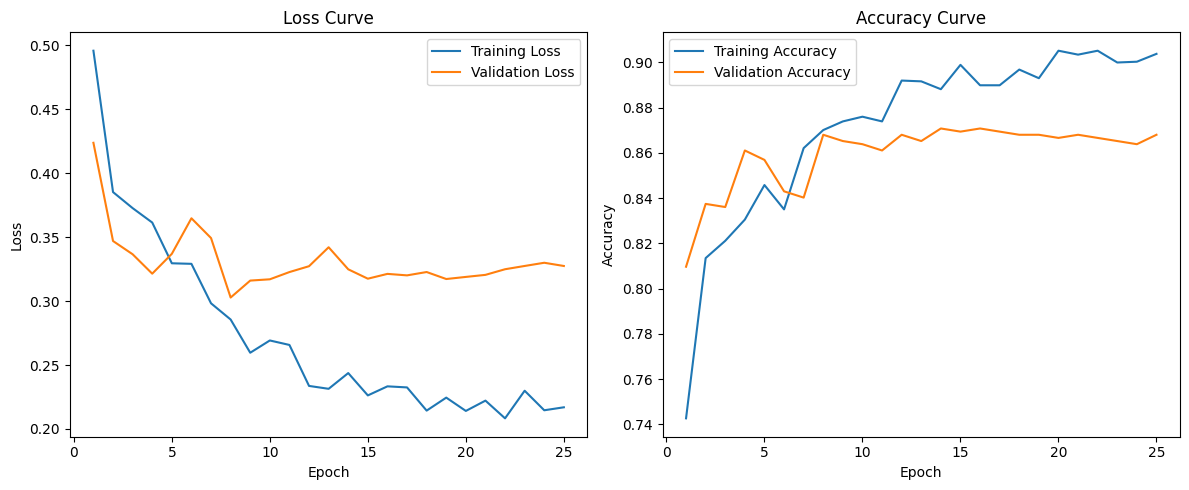

Testing: 100%|██████████| 23/23 [00:02<00:00,  7.88it/s]


Classification Report:
              precision    recall  f1-score   support

      benign       0.86      0.89      0.87       360
   malignant       0.88      0.85      0.87       360

    accuracy                           0.87       720
   macro avg       0.87      0.87      0.87       720
weighted avg       0.87      0.87      0.87       720



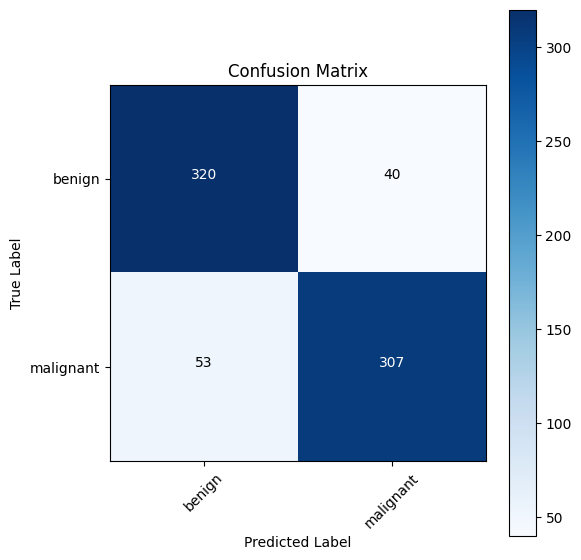

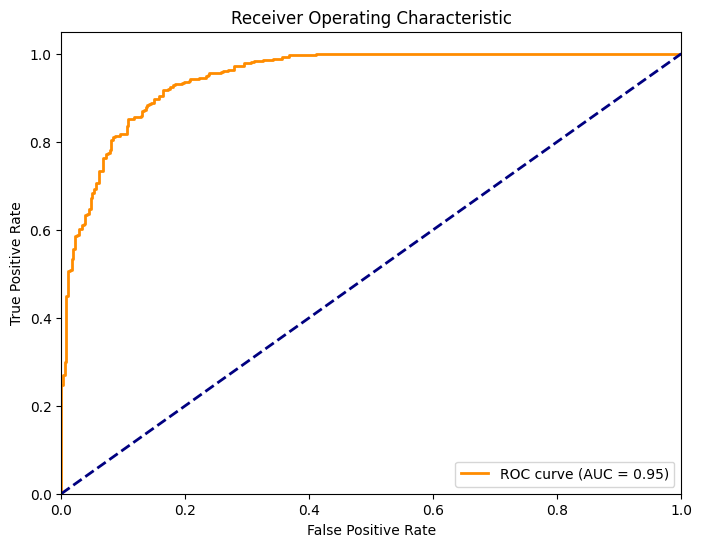

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm

########################################
# 1. Reproducibility & Device Setup
########################################
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

########################################
# 2. Data Preparation & Augmentation
########################################
# Update this path to your dataset directory
data_dir = '/kaggle/input/k-means-cyclegan/k-means segmented_data(cycleGAN)'
train_dir = os.path.join(data_dir, 'train')
test_dir  = os.path.join(data_dir, 'test')

# Strong augmentation for training; standard normalization for testing.
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transforms)

########################################
# 3. Visualization 1: Dataset Class Distribution (Pie Chart)
########################################
def plot_class_distribution(dataset, title="Class Distribution"):
    class_names = dataset.classes
    class_counts = {name: 0 for name in class_names}
    for _, label in dataset.samples:
        class_counts[class_names[label]] += 1
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

print("Train Set Distribution:")
plot_class_distribution(train_dataset, "Train Set Distribution")
print("Test Set Distribution:")
plot_class_distribution(test_dataset, "Test Set Distribution")

########################################
# 4. DataLoaders
########################################
batch_size = 32  # Adjust batch size if needed for memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

########################################
# 5. Model Initialization & Fine-Tuning (EfficientNetV2-M)
########################################
# We use EfficientNetV2-M (a smaller variant than V2-L) to help reduce memory usage.
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
weights = EfficientNet_V2_M_Weights.IMAGENET1K_V1  # or use DEFAULT for latest weights

model_ft = efficientnet_v2_m(weights=weights)
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 2)
)
model_ft = model_ft.to(device)

########################################
# 6. Training Function
########################################
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists for training history
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Each epoch: training and validation phases.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                total_samples += inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Validation Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    return model, history

########################################
# 7. Set Loss, Optimizer, and Scheduler
########################################
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-4)
scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

########################################
# 8. Train the Model
########################################
num_epochs = 25
model_ft, history = train_model(model_ft, criterion, optimizer_ft, scheduler_ft, num_epochs=num_epochs)

########################################
# 9. Visualization 2: Training Curves (Accuracy & Loss)
########################################
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12,5))
    
    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history)

########################################
# 10. Model Evaluation on Test Set
########################################
model_ft.eval()
all_preds = []
all_probs = []  # Probabilities for the malignant class (index 1)
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Class 1 probability
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

########################################
# 11. Visualization 3: Classification Report
########################################
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

########################################
# 12. Visualization 4: Confusion Matrix
########################################
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.classes))
plt.xticks(tick_marks, train_dataset.classes, rotation=45)
plt.yticks(tick_marks, train_dataset.classes)
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

########################################
# 13. Visualization 5: ROC Curve & AUC
########################################
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# ConvNeXt_Base

Using device: cuda:0
Train Set Distribution:


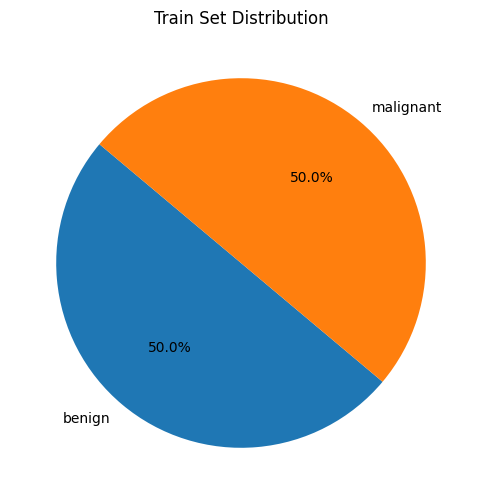

Test Set Distribution:


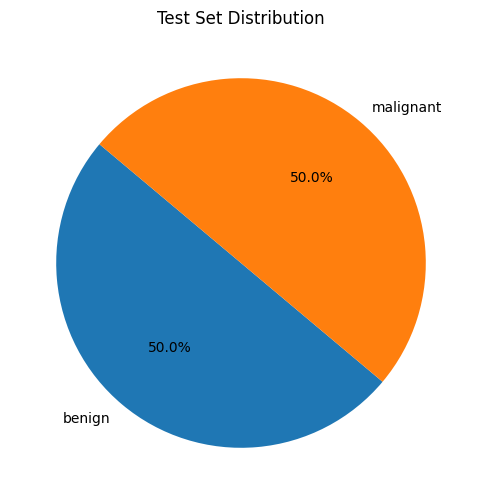

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:01<00:00, 200MB/s] 
<ipython-input-1-8cd3d416f9b1>:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # For mixed precision training


Epoch 1/25
----------


train:   0%|          | 0/360 [00:00<?, ?it/s]<ipython-input-1-8cd3d416f9b1>:144: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
train: 100%|██████████| 360/360 [00:45<00:00,  7.90it/s]


Train Loss: 0.5214 Acc: 0.7507


val: 100%|██████████| 90/90 [00:04<00:00, 20.42it/s]


Val Loss: 0.3741 Acc: 0.8236

Epoch 2/25
----------


train: 100%|██████████| 360/360 [00:44<00:00,  8.05it/s]


Train Loss: 0.4070 Acc: 0.8017


val: 100%|██████████| 90/90 [00:03<00:00, 28.13it/s]


Val Loss: 0.4124 Acc: 0.7958

Epoch 3/25
----------


train: 100%|██████████| 360/360 [00:45<00:00,  7.94it/s]


Train Loss: 0.3844 Acc: 0.8135


val: 100%|██████████| 90/90 [00:03<00:00, 27.72it/s]


Val Loss: 0.2939 Acc: 0.8611

Epoch 4/25
----------


train: 100%|██████████| 360/360 [00:45<00:00,  7.89it/s]


Train Loss: 0.3478 Acc: 0.8340


val: 100%|██████████| 90/90 [00:03<00:00, 27.68it/s]


Val Loss: 0.3186 Acc: 0.8528

Epoch 5/25
----------


train: 100%|██████████| 360/360 [00:45<00:00,  7.84it/s]


Train Loss: 0.3225 Acc: 0.8469


val: 100%|██████████| 90/90 [00:03<00:00, 27.42it/s]


Val Loss: 0.3240 Acc: 0.8597

Epoch 6/25
----------


train: 100%|██████████| 360/360 [00:45<00:00,  7.83it/s]


Train Loss: 0.3043 Acc: 0.8594


val: 100%|██████████| 90/90 [00:03<00:00, 27.30it/s]


Val Loss: 0.2922 Acc: 0.8806

Epoch 7/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.78it/s]


Train Loss: 0.3030 Acc: 0.8566


val: 100%|██████████| 90/90 [00:03<00:00, 27.17it/s]


Val Loss: 0.3341 Acc: 0.8528

Epoch 8/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.81it/s]


Train Loss: 0.2525 Acc: 0.8882


val: 100%|██████████| 90/90 [00:03<00:00, 27.17it/s]


Val Loss: 0.2698 Acc: 0.8847

Epoch 9/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.80it/s]


Train Loss: 0.2247 Acc: 0.8976


val: 100%|██████████| 90/90 [00:03<00:00, 27.09it/s]


Val Loss: 0.2739 Acc: 0.8819

Epoch 10/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.81it/s]


Train Loss: 0.2130 Acc: 0.9028


val: 100%|██████████| 90/90 [00:03<00:00, 26.94it/s]


Val Loss: 0.2665 Acc: 0.8861

Epoch 11/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.80it/s]


Train Loss: 0.2118 Acc: 0.9115


val: 100%|██████████| 90/90 [00:03<00:00, 27.06it/s]


Val Loss: 0.2702 Acc: 0.8833

Epoch 12/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.79it/s]


Train Loss: 0.1950 Acc: 0.9111


val: 100%|██████████| 90/90 [00:03<00:00, 27.03it/s]


Val Loss: 0.2707 Acc: 0.8819

Epoch 13/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.79it/s]


Train Loss: 0.1941 Acc: 0.9125


val: 100%|██████████| 90/90 [00:03<00:00, 26.77it/s]


Val Loss: 0.2759 Acc: 0.8917

Epoch 14/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.72it/s]


Train Loss: 0.1716 Acc: 0.9285


val: 100%|██████████| 90/90 [00:03<00:00, 26.87it/s]


Val Loss: 0.2880 Acc: 0.8833

Epoch 15/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.78it/s]


Train Loss: 0.1619 Acc: 0.9267


val: 100%|██████████| 90/90 [00:03<00:00, 26.89it/s]


Val Loss: 0.2928 Acc: 0.8806

Epoch 16/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.78it/s]


Train Loss: 0.1805 Acc: 0.9142


val: 100%|██████████| 90/90 [00:03<00:00, 27.01it/s]


Val Loss: 0.2914 Acc: 0.8833

Epoch 17/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.78it/s]


Train Loss: 0.1665 Acc: 0.9198


val: 100%|██████████| 90/90 [00:03<00:00, 26.10it/s]


Val Loss: 0.2913 Acc: 0.8861

Epoch 18/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.78it/s]


Train Loss: 0.1660 Acc: 0.9247


val: 100%|██████████| 90/90 [00:03<00:00, 26.96it/s]


Val Loss: 0.2919 Acc: 0.8875

Epoch 19/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.78it/s]


Train Loss: 0.1675 Acc: 0.9253


val: 100%|██████████| 90/90 [00:03<00:00, 27.06it/s]


Val Loss: 0.2896 Acc: 0.8889

Epoch 20/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.80it/s]


Train Loss: 0.1607 Acc: 0.9281


val: 100%|██████████| 90/90 [00:03<00:00, 27.01it/s]


Val Loss: 0.2931 Acc: 0.8861

Epoch 21/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.75it/s]


Train Loss: 0.1637 Acc: 0.9260


val: 100%|██████████| 90/90 [00:03<00:00, 26.98it/s]


Val Loss: 0.2942 Acc: 0.8889

Epoch 22/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.80it/s]


Train Loss: 0.1605 Acc: 0.9257


val: 100%|██████████| 90/90 [00:03<00:00, 27.27it/s]


Val Loss: 0.2942 Acc: 0.8889

Epoch 23/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.82it/s]


Train Loss: 0.1661 Acc: 0.9236


val: 100%|██████████| 90/90 [00:03<00:00, 27.11it/s]


Val Loss: 0.2941 Acc: 0.8903

Epoch 24/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.79it/s]


Train Loss: 0.1566 Acc: 0.9292


val: 100%|██████████| 90/90 [00:03<00:00, 26.98it/s]


Val Loss: 0.2945 Acc: 0.8903

Epoch 25/25
----------


train: 100%|██████████| 360/360 [00:46<00:00,  7.80it/s]


Train Loss: 0.1686 Acc: 0.9316


val: 100%|██████████| 90/90 [00:03<00:00, 27.08it/s]


Val Loss: 0.2945 Acc: 0.8903

Training complete in 20m 36s
Best Validation Acc: 0.8917


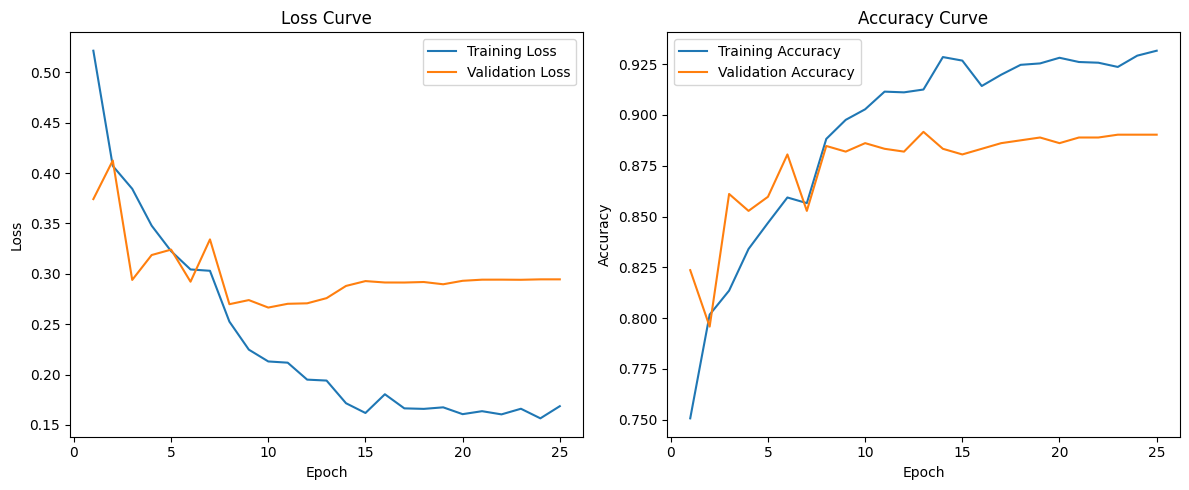

Testing: 100%|██████████| 90/90 [00:08<00:00, 10.12it/s]


Classification Report:
              precision    recall  f1-score   support

      benign       0.90      0.89      0.89       360
   malignant       0.89      0.90      0.89       360

    accuracy                           0.89       720
   macro avg       0.89      0.89      0.89       720
weighted avg       0.89      0.89      0.89       720



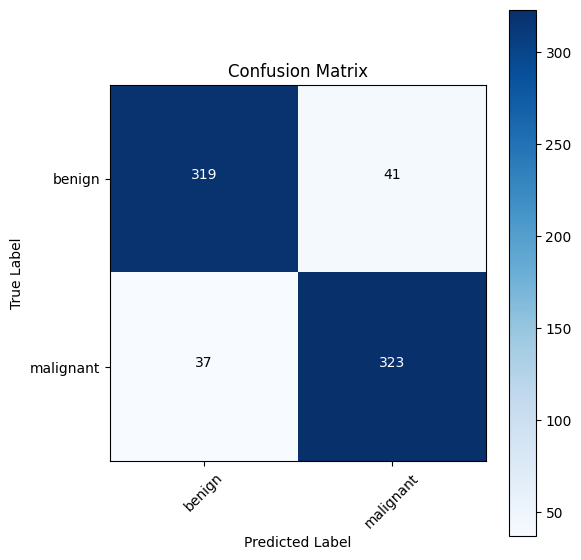

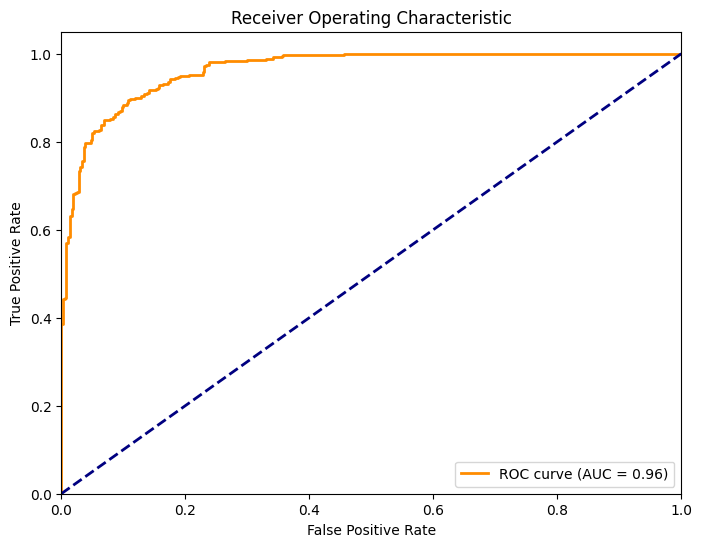

In [1]:
  # Set environment variable to help avoid fragmentation issues
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm

# Clear GPU cache before starting
torch.cuda.empty_cache()

########################################
# 1. Reproducibility & Device Setup
########################################
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

########################################
# 2. Data Preparation & Augmentation
########################################
data_dir = '/kaggle/input/k-means-cyclegan/k-means segmented_data(cycleGAN)'  # Update this path as needed
train_dir = os.path.join(data_dir, 'train')
test_dir  = os.path.join(data_dir, 'test')

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transforms)

########################################
# 3. Visualization 1: Dataset Class Distribution (Pie Chart)
########################################
def plot_class_distribution(dataset, title="Class Distribution"):
    class_names = dataset.classes
    class_counts = {name: 0 for name in class_names}
    for _, label in dataset.samples:
        class_counts[class_names[label]] += 1
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

print("Train Set Distribution:")
plot_class_distribution(train_dataset, "Train Set Distribution")
print("Test Set Distribution:")
plot_class_distribution(test_dataset, "Test Set Distribution")

########################################
# 4. DataLoaders
########################################
# To further conserve memory, we use a smaller batch size and fewer workers.
batch_size = 8  # Try reducing to 8 if 16/32 cause memory issues
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

########################################
# 5. Model Initialization & Fine-Tuning (ConvNeXt-Base)
########################################
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
weights = ConvNeXt_Base_Weights.IMAGENET1K_V1
model_convnext = convnext_base(weights=weights)
# The original classifier is a Sequential with (LayerNorm, Flatten, Linear)
# We rebuild it to flatten first, then apply LayerNorm, dropout, and a final Linear layer.
in_features = model_convnext.classifier[2].in_features
model_convnext.classifier = nn.Sequential(
    nn.Flatten(),
    nn.LayerNorm(in_features, eps=1e-6),
    nn.Dropout(p=0.5),
    nn.Linear(in_features, 2)
)
model_convnext = model_convnext.to(device)

########################################
# 6. Training Function with Mixed Precision (AMP)
########################################
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    scaler = torch.cuda.amp.GradScaler()  # For mixed precision training

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                total_samples += inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Validation Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    return model, history

########################################
# 7. Set Loss Function, Optimizer, and Scheduler
########################################
criterion = nn.CrossEntropyLoss()
optimizer_convnext = optim.Adam(model_convnext.parameters(), lr=1e-4)
scheduler_convnext = lr_scheduler.StepLR(optimizer_convnext, step_size=7, gamma=0.1)

########################################
# 8. Train the Model
########################################
num_epochs = 25
model_convnext, history = train_model(model_convnext, criterion, optimizer_convnext, scheduler_convnext, num_epochs=num_epochs)

########################################
# 9. Visualization 2: Training Curves (Accuracy & Loss)
########################################
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12,5))
    
    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

########################################
# 10. Model Evaluation on Test Set
########################################
model_convnext.eval()
all_preds = []
all_probs = []  # Probabilities for malignant (class index 1)
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_convnext(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Probability for class 1
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

########################################
# 11. Visualization 3: Classification Report
########################################
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

########################################
# 12. Visualization 4: Confusion Matrix
########################################
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.classes))
plt.xticks(tick_marks, train_dataset.classes, rotation=45)
plt.yticks(tick_marks, train_dataset.classes)
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

########################################
# 13. Visualization 5: ROC Curve & AUC
########################################
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**with k-fold & hyper-parameter**

Using device: cuda:0
Train Set Distribution:


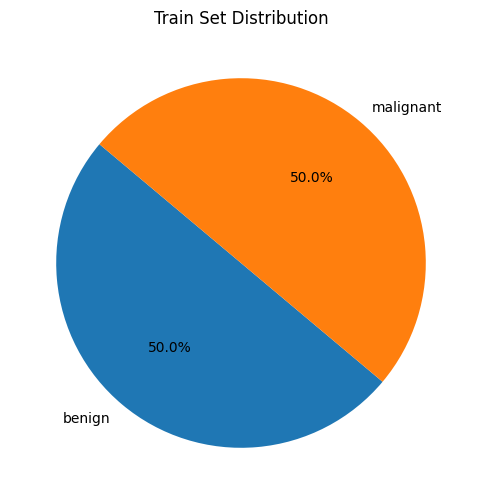

Test Set Distribution:


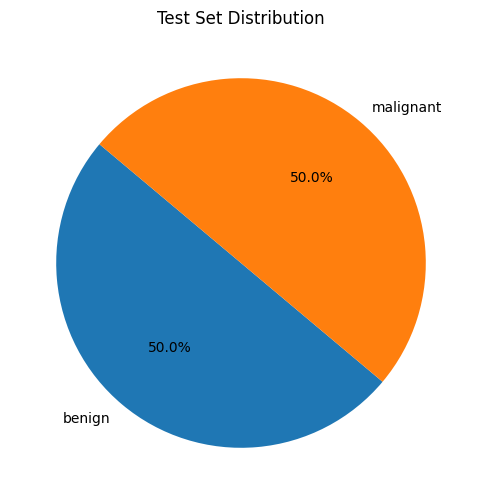


Evaluating hyperparameters: lr = 0.0001, dropout = 0.3

--- Fold 1/5 ---


Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:01<00:00, 193MB/s]  
<ipython-input-1-30989d096fdb>:139: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # For mixed precision training


Epoch 1/25
----------


Training:   0%|          | 0/288 [00:00<?, ?it/s]<ipython-input-1-30989d096fdb>:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.4829 Acc: 0.7635


Validation:   0%|          | 0/72 [00:00<?, ?it/s]<ipython-input-1-30989d096fdb>:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Val Loss: 0.4197 Acc: 0.7917

Epoch 2/25
----------


Train Loss: 0.3887 Acc: 0.8108


Val Loss: 0.3732 Acc: 0.8108

Epoch 3/25
----------


Train Loss: 0.3653 Acc: 0.8325


Val Loss: 0.4250 Acc: 0.7917

Epoch 4/25
----------


Train Loss: 0.3454 Acc: 0.8390


Val Loss: 0.3565 Acc: 0.8160

Epoch 5/25
----------


Train Loss: 0.3169 Acc: 0.8633


Val Loss: 0.3616 Acc: 0.8264

Epoch 6/25
----------


Train Loss: 0.3179 Acc: 0.8498


Val Loss: 0.3722 Acc: 0.8264

Epoch 7/25
----------


Train Loss: 0.2920 Acc: 0.8685


Val Loss: 0.3879 Acc: 0.8351

Epoch 8/25
----------


Train Loss: 0.2270 Acc: 0.8976


Val Loss: 0.3386 Acc: 0.8576

Epoch 9/25
----------


Train Loss: 0.2133 Acc: 0.9036


Val Loss: 0.3511 Acc: 0.8576

Epoch 10/25
----------


Train Loss: 0.1844 Acc: 0.9175


Val Loss: 0.3283 Acc: 0.8542

Epoch 11/25
----------


Train Loss: 0.1942 Acc: 0.9080


Val Loss: 0.3624 Acc: 0.8472

Epoch 12/25
----------


Train Loss: 0.1702 Acc: 0.9188


Val Loss: 0.3539 Acc: 0.8594

Epoch 13/25
----------


Train Loss: 0.1766 Acc: 0.9132


Val Loss: 0.4022 Acc: 0.8420

Epoch 14/25
----------


Train Loss: 0.1584 Acc: 0.9310


Val Loss: 0.4032 Acc: 0.8542

Epoch 15/25
----------


Train Loss: 0.1591 Acc: 0.9280


Val Loss: 0.3712 Acc: 0.8594

Epoch 16/25
----------


Train Loss: 0.1583 Acc: 0.9262


Val Loss: 0.3402 Acc: 0.8628

Epoch 17/25
----------


Training:  36%|███▋      | 105/288 [00:14<00:24,  7.46it/s]

In [ ]:
########################################
# 1. Environment Setup, Imports & Reproducibility
########################################
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import copy
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# Set environment variable to help avoid fragmentation issues
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Clear GPU cache before starting
torch.cuda.empty_cache()

# Set the random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Choose device (GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

########################################
# 2. Data Preparation & Augmentation
########################################
# Update the data_dir path as needed.
data_dir = '/kaggle/input/k-means-cyclegan/k-means segmented_data(cycleGAN)'
train_dir = os.path.join(data_dir, 'train')
test_dir  = os.path.join(data_dir, 'test')

# Define transforms (with augmentation for training)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transforms)

########################################
# 3. Visualization: Class Distribution (Pie Chart)
########################################
def plot_class_distribution(dataset, title="Class Distribution"):
    class_names = dataset.classes
    class_counts = {name: 0 for name in class_names}
    for _, label in dataset.samples:
        class_counts[class_names[label]] += 1
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

print("Train Set Distribution:")
plot_class_distribution(train_dataset, "Train Set Distribution")
print("Test Set Distribution:")
plot_class_distribution(test_dataset, "Test Set Distribution")

########################################
# 4. Hyperparameter Tuning with K-Fold Cross Validation Setup
########################################
# Hyperparameter grid (adjust these as needed)
param_grid = {
    "lr": [1e-4, 1e-3],
    "dropout": [0.3, 0.5]
}

# Define number of folds for cross validation
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# Set batch size and number of epochs for CV training
batch_size = 8
num_epochs = 25

########################################
# 5. Helper Functions: Model Builder & Training Function
########################################
def build_model(dropout, device):
    """
    Build a ConvNeXt-Base model with the specified dropout probability.
    """
    from torchvision.models import convnext_base, ConvNeXt_Base_Weights
    weights = ConvNeXt_Base_Weights.IMAGENET1K_V1
    model = convnext_base(weights=weights)
    in_features = model.classifier[2].in_features
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.LayerNorm(in_features, eps=1e-6),
        nn.Dropout(p=dropout),
        nn.Linear(in_features, 2)
    )
    return model.to(device)

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader=None, num_epochs=25):
    """
    Train the model using mixed precision with an optional validation phase.
    If val_loader is provided, the function will evaluate after each epoch and track the best validation accuracy.
    """
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    
    scaler = torch.cuda.amp.GradScaler()  # For mixed precision training

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        
        # ----- Training Phase -----
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            total_samples += inputs.size(0)
            
        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects / total_samples
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)
        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # ----- Validation Phase (if provided) -----
        if val_loader is not None:
            model.eval()
            val_running_loss = 0.0
            val_running_corrects = 0
            val_total = 0
            for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)
                with torch.no_grad():
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data).item()
                val_total += inputs.size(0)
            val_loss = val_running_loss / val_total
            val_acc = val_running_corrects / val_total
            val_loss_history.append(val_loss)
            val_acc_history.append(val_acc)
            print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
            
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        else:
            # If no validation loader is provided, use training metrics.
            best_acc = epoch_acc

        scheduler.step()
        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    if val_loader is not None:
        print(f"Best Val Acc: {best_acc:.4f}")
    else:
        print(f"Final Train Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    return model, best_acc, history

########################################
# 6. Hyperparameter Search with K-Fold Cross Validation
########################################
best_cv_acc = 0.0
best_params = {}

# Loop over each combination of hyperparameters in the grid
for lr in param_grid["lr"]:
    for dropout in param_grid["dropout"]:
        cv_scores = []
        print(f"\nEvaluating hyperparameters: lr = {lr}, dropout = {dropout}")
        # Use stratified splits based on dataset targets
        for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(train_dataset)), train_dataset.targets)):
            print(f"\n--- Fold {fold+1}/{num_folds} ---")
            # Create subsets for training and validation for this fold
            train_subset = Subset(train_dataset, train_idx)
            val_subset = Subset(train_dataset, val_idx)
            train_loader_cv = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
            val_loader_cv = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=1)
            
            # Build a new model instance for each fold with the current hyperparameters
            model_cv = build_model(dropout, device)
            criterion_cv = nn.CrossEntropyLoss()
            optimizer_cv = optim.Adam(model_cv.parameters(), lr=lr)
            scheduler_cv = lr_scheduler.StepLR(optimizer_cv, step_size=7, gamma=0.1)
            
            # Train the model on the current fold
            model_cv, best_val_acc, _ = train_model(model_cv, criterion_cv, optimizer_cv, scheduler_cv,
                                                      train_loader_cv, val_loader_cv, num_epochs=num_epochs)
            cv_scores.append(best_val_acc)
            print(f"Fold {fold+1} Val Acc: {best_val_acc:.4f}")
        
        avg_cv_acc = sum(cv_scores) / len(cv_scores)
        print(f"\nAverage CV Acc for lr = {lr}, dropout = {dropout}: {avg_cv_acc:.4f}")
        # Update best hyperparameters if this combination is superior
        if avg_cv_acc > best_cv_acc:
            best_cv_acc = avg_cv_acc
            best_params = {"lr": lr, "dropout": dropout}

print("\n======================================")
print("Hyperparameter Tuning Complete!")
print(f"Best CV Accuracy: {best_cv_acc:.4f}")
print(f"Best Hyperparameters: lr = {best_params['lr']}, dropout = {best_params['dropout']}")
print("======================================\n")

########################################
# 7. Final Training on Full Training Set with Best Hyperparameters
########################################
print("Training final model on full training set using best hyperparameters...")

# Build final model with the best dropout setting
final_model = build_model(best_params["dropout"], device)
criterion_final = nn.CrossEntropyLoss()
optimizer_final = optim.Adam(final_model.parameters(), lr=best_params["lr"])
scheduler_final = lr_scheduler.StepLR(optimizer_final, step_size=7, gamma=0.1)

# Create a DataLoader for the full training set
full_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# (Here we do not provide a validation loader so training metrics will be reported.)
final_model, _, full_history = train_model(final_model, criterion_final, optimizer_final, scheduler_final,
                                            full_train_loader, val_loader=None, num_epochs=num_epochs)

########################################
# 8. Evaluate the Final Model on the Test Set
########################################
final_model.eval()
all_preds = []
all_probs = []  # Probabilities for class index 1 (assumed positive/malignant)
all_labels = []

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing Final Model"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = final_model(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Probability for class 1
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

########################################
# 9. Final Visualizations: Training Curves, Classification Report, Confusion Matrix & ROC Curve
########################################
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12,5))
    
    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    if history['val_loss']:
        plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    if history['val_acc']:
        plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training curves from final training (if available)
plot_training_curves(full_history)

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.classes))
plt.xticks(tick_marks, train_dataset.classes, rotation=45)
plt.yticks(tick_marks, train_dataset.classes)
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ROC Curve & AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Grad-CAM++

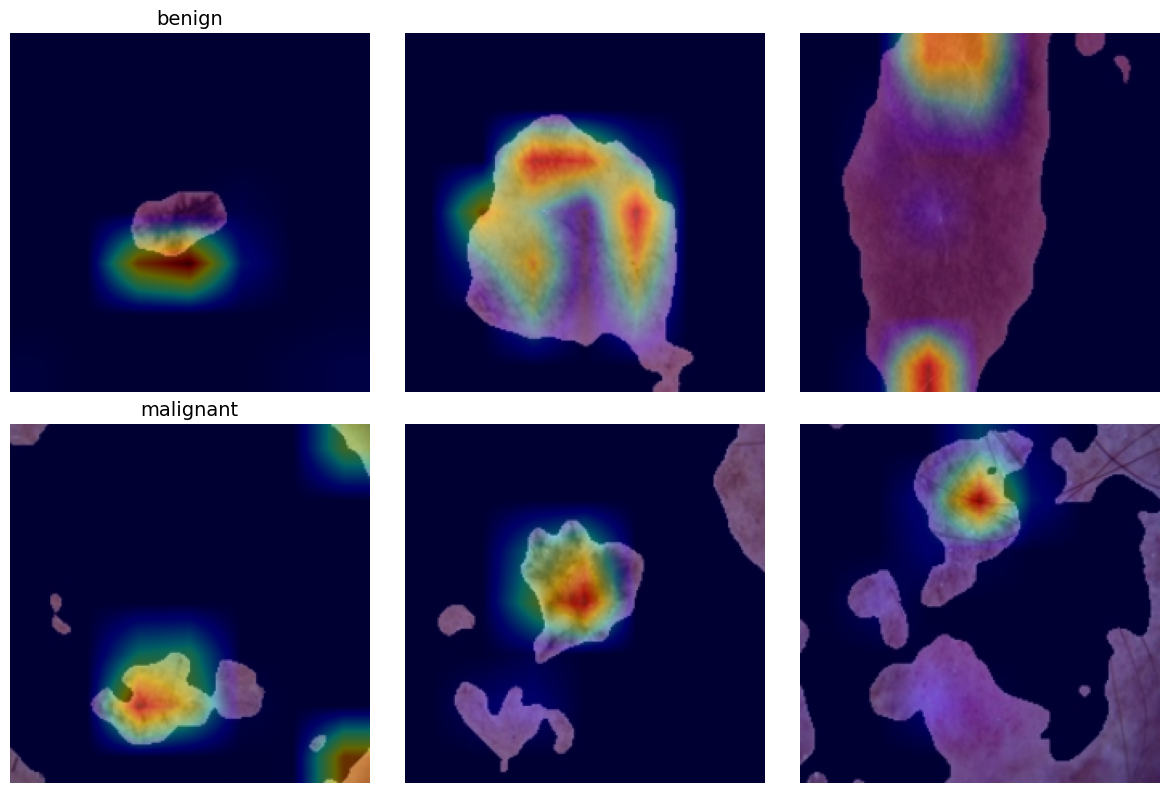

In [4]:
import torch
import torch.nn.functional as 
import numpy as np
import matplotlib.pyplot as plt

###############################################################################
# Grad-CAM++ Implementation
###############################################################################
class GradCAMPlusPlus:
    """
    Grad-CAM++ class for generating visual explanations using the Grad-CAM++ method.
    """
    def __init__(self, model: torch.nn.Module, target_layer: torch.nn.Module):
        """
        Initialize the GradCAMPlusPlus object.
        
        Args:
            model (torch.nn.Module): The model to inspect.
            target_layer (torch.nn.Module): The target convolutional layer to hook.
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()
        
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
            
        def backward_hook(module, grad_in, grad_out):
            # grad_out[0] corresponds to the gradients of the output
            self.gradients = grad_out[0].detach()
            
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))
        
    def remove_hooks(self):
        """
        Remove the forward and backward hooks.
        """
        for handle in self.hook_handles:
            handle.remove()
    
    def generate_cam(self, input_tensor: torch.Tensor, target_class: int) -> np.ndarray:
        """
        Generate Grad-CAM++ heatmap for the given input and target class.
        
        Args:
            input_tensor (torch.Tensor): Input image tensor of shape (1, C, H, W).
            target_class (int): Class index for which to generate the heatmap.
            
        Returns:
            np.ndarray: Upsampled heatmap (H x W) with values in [0, 1].
        """
        # Forward pass
        output = self.model(input_tensor)
        
        # Zero gradients and create a one-hot vector for the target class
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        
        # Backward pass to get gradients of target class score with respect to feature maps
        output.backward(gradient=one_hot, retain_graph=True)
        
        # Retrieve the saved gradients and activations
        gradients = self.gradients  # shape: (1, C, h, w)
        activations = self.activations  # shape: (1, C, h, w)
        eps = 1e-8
        
        # Compute the squared and cubed gradients
        grad_squared = gradients ** 2
        grad_cubed = gradients ** 3
        
        # Sum the squared gradients over spatial dimensions (i,j)
        global_sum_grad_squared = torch.sum(grad_squared, dim=(2, 3), keepdim=True)
        global_sum_activations_grad_cubed = torch.sum(activations * grad_cubed, dim=(2, 3), keepdim=True)
        
        # Compute denominator for alpha coefficients
        denominator = 2 * global_sum_grad_squared + global_sum_activations_grad_cubed
        
        # Calculate alpha coefficients for each pixel (channel-wise)
        alphas = grad_squared / (denominator + eps)
        
        # Compute weights by summing the product of alphas and ReLU of gradients over spatial locations
        weights = torch.sum(alphas * F.relu(gradients), dim=(2, 3), keepdim=True)
        
        # Weighted combination of forward activation maps
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = F.relu(cam)
        
        # Normalize the CAM to [0,1]
        cam_min = cam.view(cam.size(0), -1).min(dim=1, keepdim=True)[0].unsqueeze(-1).unsqueeze(-1)
        cam_max = cam.view(cam.size(0), -1).max(dim=1, keepdim=True)[0].unsqueeze(-1).unsqueeze(-1)
        cam = (cam - cam_min) / (cam_max - cam_min + eps)
        
        # Upsample to the input image size
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        
        return cam[0, 0].cpu().numpy()

###############################################################################
# Helper Functions for Visualization
###############################################################################
def denormalize(img_tensor: torch.Tensor, mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]) -> np.ndarray:
    """
    Denormalize an image tensor and convert to numpy array.
    
    Args:
        img_tensor (torch.Tensor): Tensor of shape (C, H, W).
        mean (list): Mean used for normalization.
        std (list): Standard deviation used for normalization.
        
    Returns:
        np.ndarray: Denormalized image in H x W x C format with values in [0,1].
    """
    img = img_tensor.clone().detach().cpu().numpy().transpose(1, 2, 0)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

def overlay_heatmap(image: np.ndarray, heatmap: np.ndarray, alpha: float = 0.4,
                    colormap: str = 'jet') -> np.ndarray:
    """
    Overlay a heatmap on an image.
    
    Args:
        image (np.ndarray): Original image array in [0,1].
        heatmap (np.ndarray): Heatmap array in [0,1].
        alpha (float): Transparency factor for heatmap overlay.
        colormap (str): Colormap to use.
        
    Returns:
        np.ndarray: Image with heatmap overlay.
    """
    cmap = plt.get_cmap(colormap)
    heatmap_color = cmap(heatmap)
    heatmap_color = heatmap_color[..., :3]  # discard alpha channel if present
    overlayed_img = heatmap_color * alpha + image * (1 - alpha)
    overlayed_img = np.clip(overlayed_img, 0, 1)
    return overlayed_img

def visualize_gradcam_per_class(model: torch.nn.Module, gradcam: GradCAMPlusPlus, 
                                dataset, num_samples: int = 3, device: str = 'cpu'):
    """
    Visualize Grad-CAM++ results row-wise, where each row corresponds to a class.
    
    For each class, `num_samples` images are selected from the dataset, the Grad-CAM++
    heatmap is computed, and the resulting overlay is displayed.
    
    Args:
        model (torch.nn.Module): The trained model.
        gradcam (GradCAMPlusPlus): Initialized GradCAM++ object.
        dataset: Dataset (e.g., torchvision.datasets.ImageFolder) with .classes attribute.
        num_samples (int): Number of images per class to visualize.
        device (str): Device to perform computations ('cpu' or 'cuda').
    """
    # Dictionary to hold overlays per class
    class_to_overlays = {cls_idx: [] for cls_idx in range(len(dataset.classes))}
    
    # Loop through dataset and collect overlays until reaching num_samples per class
    for idx in range(len(dataset)):
        img, label = dataset[idx]
        if len(class_to_overlays[label]) < num_samples:
            input_tensor = img.unsqueeze(0).to(device)
            # Compute Grad-CAM++ heatmap for the true class (can be adjusted to predicted class)
            heatmap = gradcam.generate_cam(input_tensor, target_class=label)
            orig_img = denormalize(img)
            overlay_img = overlay_heatmap(orig_img, heatmap)
            class_to_overlays[label].append(overlay_img)
        if all(len(v) >= num_samples for v in class_to_overlays.values()):
            break

    # Plot images row-wise (one row per class)
    num_classes = len(dataset.classes)
    fig, axes = plt.subplots(num_classes, num_samples, figsize=(num_samples * 4, num_classes * 4))
    for cls_idx, overlays in class_to_overlays.items():
        for j, overlay_img in enumerate(overlays):
            ax = axes[cls_idx, j] if num_classes > 1 else axes[j]
            ax.imshow(overlay_img)
            ax.axis('off')
            if j == 0:
                ax.set_title(dataset.classes[cls_idx], fontsize=14)
    plt.tight_layout()
    plt.show()

###############################################################################
# Integration and Visualization
###############################################################################
# Set the target layer for Grad-CAM++.
# Here, we choose the last layer in the features block of ConvNeXt-Base.
# (Adjust the layer selection if needed.)
target_layer = model_convnext.features[-1]
gradcam_pp = GradCAMPlusPlus(model_convnext, target_layer)

# Visualize Grad-CAM++ outputs for the test dataset.
# This will display rows of images (with heatmap overlays) per class.
visualize_gradcam_per_class(model_convnext, gradcam_pp, test_dataset, num_samples=3, device=device)

# Remove hooks if no longer needed.
gradcam_pp.remove_hooks()




# Swin Transformer‐B

Using device: cuda:0
Train Set Distribution:


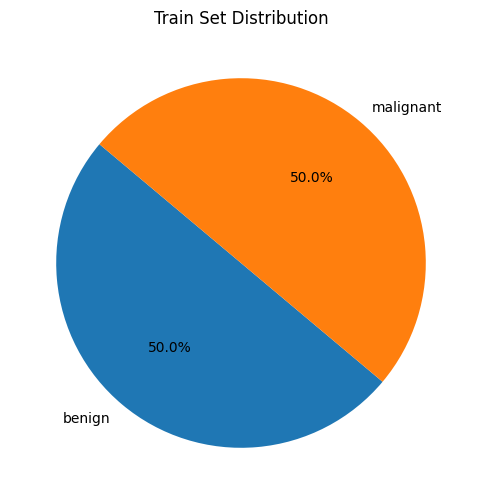

Test Set Distribution:


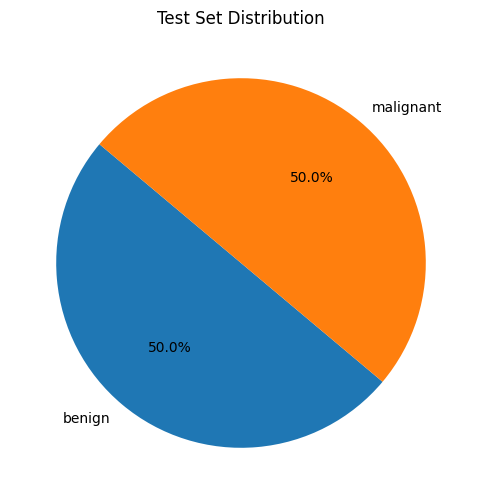

Downloading: "https://download.pytorch.org/models/swin_b-68c6b09e.pth" to /root/.cache/torch/hub/checkpoints/swin_b-68c6b09e.pth
100%|██████████| 335M/335M [00:01<00:00, 200MB/s] 
<ipython-input-1-04b50f1985b7>:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/25
----------


train:   0%|          | 0/180 [00:00<?, ?it/s]<ipython-input-1-04b50f1985b7>:152: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
train: 100%|██████████| 180/180 [00:46<00:00,  3.87it/s]


Train Loss: 0.4950 Acc: 0.7552


val: 100%|██████████| 45/45 [00:03<00:00, 11.27it/s]


Val Loss: 0.3439 Acc: 0.8431

Epoch 2/25
----------


train: 100%|██████████| 180/180 [00:47<00:00,  3.78it/s]


Train Loss: 0.4075 Acc: 0.8038


val: 100%|██████████| 45/45 [00:04<00:00, 10.41it/s]


Val Loss: 0.3758 Acc: 0.8194

Epoch 3/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.72it/s]


Train Loss: 0.3711 Acc: 0.8174


val: 100%|██████████| 45/45 [00:04<00:00, 10.74it/s]


Val Loss: 0.3142 Acc: 0.8444

Epoch 4/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.74it/s]


Train Loss: 0.3817 Acc: 0.8177


val: 100%|██████████| 45/45 [00:04<00:00, 10.71it/s]


Val Loss: 0.3643 Acc: 0.8250

Epoch 5/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.73it/s]


Train Loss: 0.3451 Acc: 0.8458


val: 100%|██████████| 45/45 [00:04<00:00, 10.79it/s]


Val Loss: 0.3096 Acc: 0.8500

Epoch 6/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.74it/s]


Train Loss: 0.3326 Acc: 0.8399


val: 100%|██████████| 45/45 [00:04<00:00, 10.63it/s]


Val Loss: 0.3057 Acc: 0.8444

Epoch 7/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.74it/s]


Train Loss: 0.3258 Acc: 0.8438


val: 100%|██████████| 45/45 [00:04<00:00, 10.74it/s]


Val Loss: 0.2833 Acc: 0.8597

Epoch 8/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.73it/s]


Train Loss: 0.2821 Acc: 0.8646


val: 100%|██████████| 45/45 [00:04<00:00, 10.76it/s]


Val Loss: 0.2672 Acc: 0.8736

Epoch 9/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.74it/s]


Train Loss: 0.2642 Acc: 0.8753


val: 100%|██████████| 45/45 [00:04<00:00, 10.78it/s]


Val Loss: 0.2714 Acc: 0.8681

Epoch 10/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.74it/s]


Train Loss: 0.2562 Acc: 0.8795


val: 100%|██████████| 45/45 [00:04<00:00, 10.74it/s]


Val Loss: 0.2591 Acc: 0.8750

Epoch 11/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.73it/s]


Train Loss: 0.2529 Acc: 0.8781


val: 100%|██████████| 45/45 [00:04<00:00, 10.73it/s]


Val Loss: 0.2663 Acc: 0.8736

Epoch 12/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.74it/s]


Train Loss: 0.2438 Acc: 0.8833


val: 100%|██████████| 45/45 [00:04<00:00, 10.72it/s]


Val Loss: 0.2656 Acc: 0.8792

Epoch 13/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.73it/s]


Train Loss: 0.2358 Acc: 0.8868


val: 100%|██████████| 45/45 [00:04<00:00, 10.70it/s]


Val Loss: 0.2519 Acc: 0.8806

Epoch 14/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.74it/s]


Train Loss: 0.2366 Acc: 0.8892


val: 100%|██████████| 45/45 [00:04<00:00, 10.78it/s]


Val Loss: 0.2583 Acc: 0.8792

Epoch 15/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.74it/s]


Train Loss: 0.2219 Acc: 0.8948


val: 100%|██████████| 45/45 [00:04<00:00, 10.72it/s]


Val Loss: 0.2588 Acc: 0.8778

Epoch 16/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.74it/s]


Train Loss: 0.2264 Acc: 0.9014


val: 100%|██████████| 45/45 [00:04<00:00, 10.76it/s]


Val Loss: 0.2579 Acc: 0.8736

Epoch 17/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.74it/s]


Train Loss: 0.2186 Acc: 0.8965


val: 100%|██████████| 45/45 [00:04<00:00, 10.71it/s]


Val Loss: 0.2605 Acc: 0.8750

Epoch 18/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.74it/s]


Train Loss: 0.2198 Acc: 0.8990


val: 100%|██████████| 45/45 [00:04<00:00, 10.72it/s]


Val Loss: 0.2636 Acc: 0.8736

Epoch 19/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.74it/s]


Train Loss: 0.2254 Acc: 0.8920


val: 100%|██████████| 45/45 [00:04<00:00, 10.73it/s]


Val Loss: 0.2617 Acc: 0.8708

Epoch 20/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.74it/s]


Train Loss: 0.2166 Acc: 0.8948


val: 100%|██████████| 45/45 [00:04<00:00, 10.77it/s]


Val Loss: 0.2631 Acc: 0.8736

Epoch 21/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.74it/s]


Train Loss: 0.2191 Acc: 0.9014


val: 100%|██████████| 45/45 [00:04<00:00, 10.79it/s]


Val Loss: 0.2641 Acc: 0.8750

Epoch 22/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.74it/s]


Train Loss: 0.2166 Acc: 0.9052


val: 100%|██████████| 45/45 [00:04<00:00, 10.75it/s]


Val Loss: 0.2641 Acc: 0.8750

Epoch 23/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.73it/s]


Train Loss: 0.2227 Acc: 0.8990


val: 100%|██████████| 45/45 [00:04<00:00, 10.63it/s]


Val Loss: 0.2640 Acc: 0.8764

Epoch 24/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.74it/s]


Train Loss: 0.2200 Acc: 0.8993


val: 100%|██████████| 45/45 [00:04<00:00, 10.72it/s]


Val Loss: 0.2637 Acc: 0.8764

Epoch 25/25
----------


train: 100%|██████████| 180/180 [00:48<00:00,  3.75it/s]


Train Loss: 0.2168 Acc: 0.8993


val: 100%|██████████| 45/45 [00:04<00:00, 10.80it/s]


Val Loss: 0.2640 Acc: 0.8764

Training complete in 21m 47s
Best Validation Acc: 0.8806


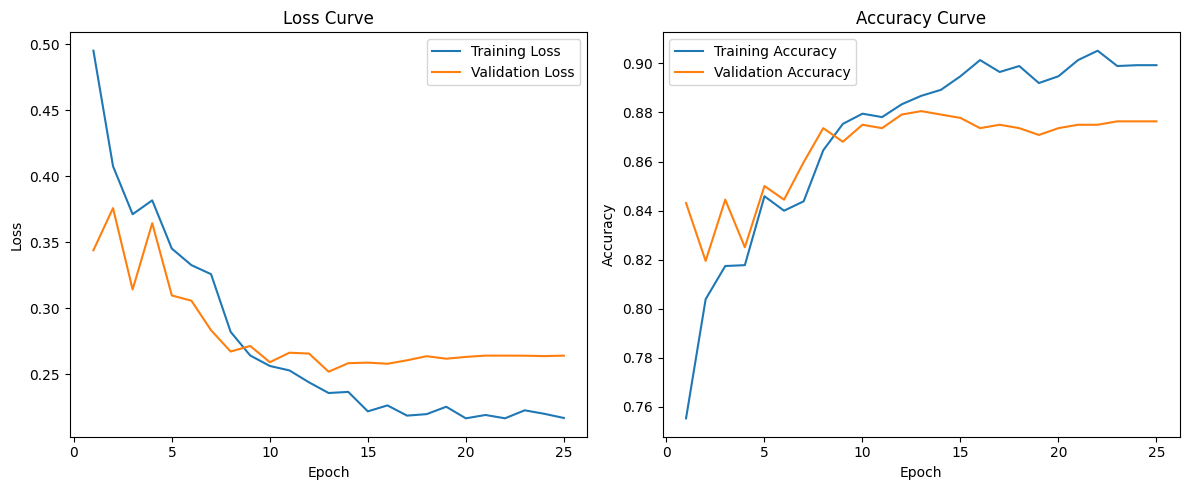

Testing: 100%|██████████| 45/45 [00:09<00:00,  4.67it/s]


Classification Report:
              precision    recall  f1-score   support

      benign       0.88      0.88      0.88       360
   malignant       0.88      0.88      0.88       360

    accuracy                           0.88       720
   macro avg       0.88      0.88      0.88       720
weighted avg       0.88      0.88      0.88       720



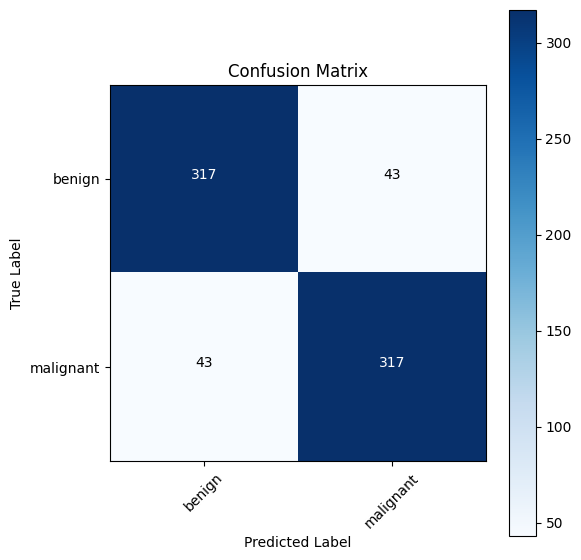

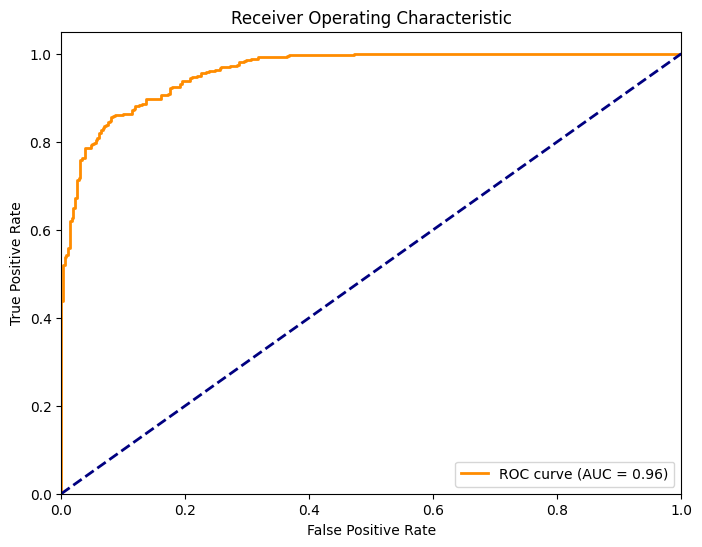

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm

########################################
# 1. Reproducibility & Device Setup
########################################
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

########################################
# 2. Data Preparation & Augmentation
########################################
# Dataset folder structure:
# data/
#   train/
#     benign/
#     malignant/
#   test/
#     benign/
#     malignant/

data_dir = '/kaggle/input/k-means-cyclegan/k-means segmented_data(cycleGAN)'  # Update this path as needed
train_dir = os.path.join(data_dir, 'train')
test_dir  = os.path.join(data_dir, 'test')

# Define strong augmentations for training and standard normalization for testing.
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transforms)

########################################
# 3. Visualization 1: Dataset Class Distribution (Pie Chart)
########################################
def plot_class_distribution(dataset, title="Class Distribution"):
    class_names = dataset.classes
    class_counts = {name: 0 for name in class_names}
    for _, label in dataset.samples:
        class_counts[class_names[label]] += 1
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

print("Train Set Distribution:")
plot_class_distribution(train_dataset, "Train Set Distribution")
print("Test Set Distribution:")
plot_class_distribution(test_dataset, "Test Set Distribution")

########################################
# 4. DataLoaders
########################################
# Create DataLoaders (adjust batch_size as needed)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

########################################
# 5. Model Initialization & Fine-Tuning (Swin Transformer-B)
########################################
# Use the pretrained Swin Transformer-B from torchvision.
from torchvision.models import swin_b, Swin_B_Weights
weights = Swin_B_Weights.IMAGENET1K_V1
model_swin = swin_b(weights=weights)

# Replace the classifier head with a dropout and a Linear layer for 2 classes.
# The Swin Transformer in torchvision uses 'model_swin.head' as its classifier.
num_features = model_swin.head.in_features
model_swin.head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_features, 2)
)
model_swin = model_swin.to(device)

########################################
# 6. Training Function
########################################
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    # Use mixed precision training to reduce memory and speed up computations.
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                total_samples += inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Validation Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    return model, history

########################################
# 7. Set Loss Function, Optimizer, and Scheduler
########################################
criterion = nn.CrossEntropyLoss()
optimizer_swin = optim.Adam(model_swin.parameters(), lr=1e-4)
scheduler_swin = lr_scheduler.StepLR(optimizer_swin, step_size=7, gamma=0.1)

########################################
# 8. Train the Model
########################################
num_epochs = 25
model_swin, history = train_model(model_swin, criterion, optimizer_swin, scheduler_swin, num_epochs=num_epochs)

########################################
# 9. Visualization 2: Training Curves (Accuracy & Loss)
########################################
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12,5))
    
    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

########################################
# 10. Model Evaluation on Test Set
########################################
model_swin.eval()
all_preds = []
all_probs = []  # Probabilities for the malignant class (index 1)
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_swin(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Class 1 probability
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

########################################
# 11. Visualization 3: Classification Report
########################################
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

########################################
# 12. Visualization 4: Confusion Matrix
########################################
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.classes))
plt.xticks(tick_marks, train_dataset.classes, rotation=45)
plt.yticks(tick_marks, train_dataset.classes)
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

########################################
# 13. Visualization 5: ROC Curve & AUC
########################################
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Vision Transformer ViT model (vit_base_patch16_224)

Using device: cuda:0
Train Set Distribution:


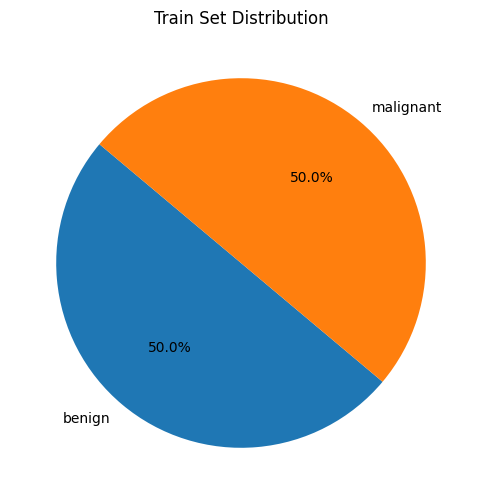

Test Set Distribution:


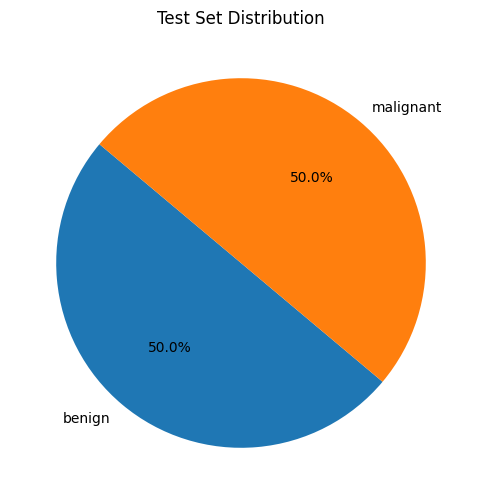

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

<ipython-input-7-6b0779b64c9e>:117: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/25
----------


train:   0%|          | 0/180 [00:00<?, ?it/s]<ipython-input-7-6b0779b64c9e>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
train: 100%|██████████| 180/180 [00:30<00:00,  5.96it/s]


Train Loss: 0.6272 Acc: 0.6573


val: 100%|██████████| 45/45 [00:02<00:00, 18.55it/s]


Val Loss: 0.4467 Acc: 0.8000

Epoch 2/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.27it/s]


Train Loss: 0.4559 Acc: 0.7840


val: 100%|██████████| 45/45 [00:02<00:00, 19.22it/s]


Val Loss: 0.4190 Acc: 0.8125

Epoch 3/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.27it/s]


Train Loss: 0.4364 Acc: 0.7816


val: 100%|██████████| 45/45 [00:02<00:00, 18.76it/s]


Val Loss: 0.3838 Acc: 0.8264

Epoch 4/25
----------


train: 100%|██████████| 180/180 [00:29<00:00,  6.15it/s]


Train Loss: 0.4063 Acc: 0.8073


val: 100%|██████████| 45/45 [00:02<00:00, 18.61it/s]


Val Loss: 0.4203 Acc: 0.8056

Epoch 5/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.23it/s]


Train Loss: 0.4094 Acc: 0.8017


val: 100%|██████████| 45/45 [00:02<00:00, 18.90it/s]


Val Loss: 0.3722 Acc: 0.8292

Epoch 6/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.25it/s]


Train Loss: 0.3949 Acc: 0.8125


val: 100%|██████████| 45/45 [00:02<00:00, 18.09it/s]


Val Loss: 0.4359 Acc: 0.7986

Epoch 7/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.21it/s]


Train Loss: 0.3973 Acc: 0.8063


val: 100%|██████████| 45/45 [00:02<00:00, 18.31it/s]


Val Loss: 0.4346 Acc: 0.8028

Epoch 8/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.22it/s]


Train Loss: 0.3397 Acc: 0.8337


val: 100%|██████████| 45/45 [00:02<00:00, 18.02it/s]


Val Loss: 0.3328 Acc: 0.8444

Epoch 9/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.24it/s]


Train Loss: 0.3228 Acc: 0.8479


val: 100%|██████████| 45/45 [00:02<00:00, 18.57it/s]


Val Loss: 0.3244 Acc: 0.8528

Epoch 10/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.25it/s]


Train Loss: 0.3070 Acc: 0.8514


val: 100%|██████████| 45/45 [00:02<00:00, 18.61it/s]


Val Loss: 0.2977 Acc: 0.8569

Epoch 11/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.25it/s]


Train Loss: 0.2983 Acc: 0.8608


val: 100%|██████████| 45/45 [00:02<00:00, 18.68it/s]


Val Loss: 0.2984 Acc: 0.8681

Epoch 12/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.23it/s]


Train Loss: 0.2948 Acc: 0.8601


val: 100%|██████████| 45/45 [00:02<00:00, 18.67it/s]


Val Loss: 0.2962 Acc: 0.8639

Epoch 13/25
----------


train: 100%|██████████| 180/180 [00:29<00:00,  6.20it/s]


Train Loss: 0.2952 Acc: 0.8667


val: 100%|██████████| 45/45 [00:02<00:00, 18.44it/s]


Val Loss: 0.3068 Acc: 0.8653

Epoch 14/25
----------


train: 100%|██████████| 180/180 [00:29<00:00,  6.19it/s]


Train Loss: 0.2944 Acc: 0.8608


val: 100%|██████████| 45/45 [00:02<00:00, 18.56it/s]


Val Loss: 0.3096 Acc: 0.8708

Epoch 15/25
----------


train: 100%|██████████| 180/180 [00:29<00:00,  6.20it/s]


Train Loss: 0.2651 Acc: 0.8747


val: 100%|██████████| 45/45 [00:02<00:00, 18.74it/s]


Val Loss: 0.3006 Acc: 0.8681

Epoch 16/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.21it/s]


Train Loss: 0.2738 Acc: 0.8747


val: 100%|██████████| 45/45 [00:02<00:00, 18.72it/s]


Val Loss: 0.2991 Acc: 0.8736

Epoch 17/25
----------


train: 100%|██████████| 180/180 [00:29<00:00,  6.21it/s]


Train Loss: 0.2693 Acc: 0.8747


val: 100%|██████████| 45/45 [00:02<00:00, 18.56it/s]


Val Loss: 0.2930 Acc: 0.8736

Epoch 18/25
----------


train: 100%|██████████| 180/180 [00:29<00:00,  6.20it/s]


Train Loss: 0.2726 Acc: 0.8750


val: 100%|██████████| 45/45 [00:02<00:00, 18.65it/s]


Val Loss: 0.2924 Acc: 0.8750

Epoch 19/25
----------


train: 100%|██████████| 180/180 [00:29<00:00,  6.20it/s]


Train Loss: 0.2683 Acc: 0.8757


val: 100%|██████████| 45/45 [00:02<00:00, 18.62it/s]


Val Loss: 0.2907 Acc: 0.8708

Epoch 20/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.21it/s]


Train Loss: 0.2593 Acc: 0.8816


val: 100%|██████████| 45/45 [00:02<00:00, 18.58it/s]


Val Loss: 0.2899 Acc: 0.8736

Epoch 21/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.21it/s]


Train Loss: 0.2623 Acc: 0.8733


val: 100%|██████████| 45/45 [00:02<00:00, 18.63it/s]


Val Loss: 0.2887 Acc: 0.8764

Epoch 22/25
----------


train: 100%|██████████| 180/180 [00:28<00:00,  6.22it/s]


Train Loss: 0.2565 Acc: 0.8809


val: 100%|██████████| 45/45 [00:02<00:00, 18.78it/s]


Val Loss: 0.2890 Acc: 0.8750

Epoch 23/25
----------


train: 100%|██████████| 180/180 [00:29<00:00,  6.21it/s]


Train Loss: 0.2623 Acc: 0.8733


val: 100%|██████████| 45/45 [00:02<00:00, 18.65it/s]


Val Loss: 0.2889 Acc: 0.8764

Epoch 24/25
----------


train: 100%|██████████| 180/180 [00:29<00:00,  6.20it/s]


Train Loss: 0.2657 Acc: 0.8760


val: 100%|██████████| 45/45 [00:02<00:00, 18.61it/s]


Val Loss: 0.2891 Acc: 0.8764

Epoch 25/25
----------


train: 100%|██████████| 180/180 [00:29<00:00,  6.19it/s]


Train Loss: 0.2573 Acc: 0.8799


val: 100%|██████████| 45/45 [00:02<00:00, 18.71it/s]


Val Loss: 0.2890 Acc: 0.8764

Training complete in 13m 6s
Best Validation Acc: 0.8764


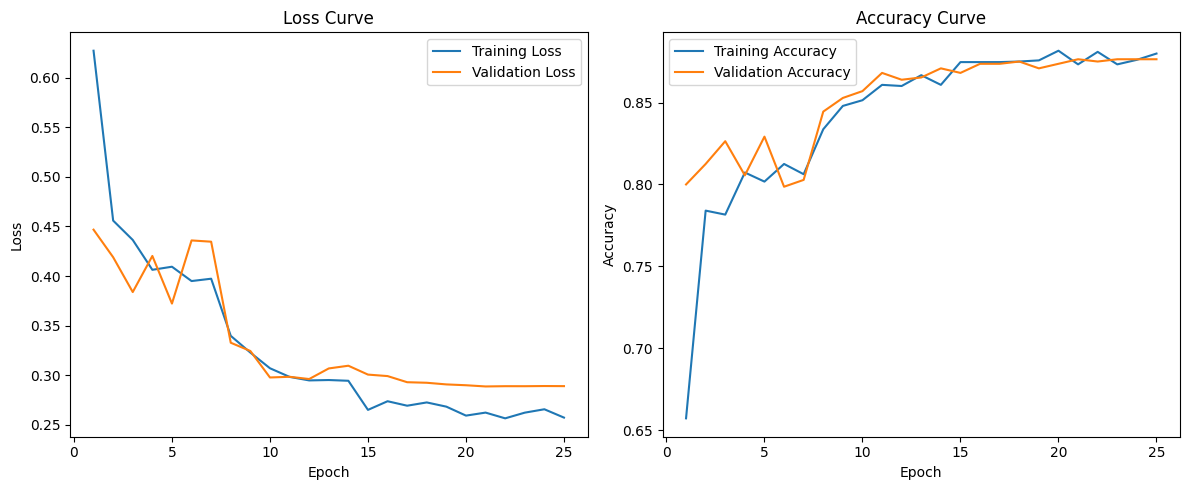

Testing: 100%|██████████| 45/45 [00:09<00:00,  4.89it/s]


Classification Report:
              precision    recall  f1-score   support

      benign       0.88      0.88      0.88       360
   malignant       0.88      0.88      0.88       360

    accuracy                           0.88       720
   macro avg       0.88      0.88      0.88       720
weighted avg       0.88      0.88      0.88       720



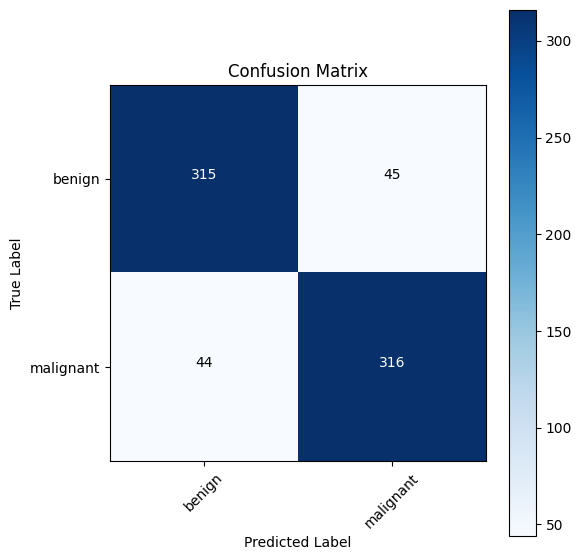

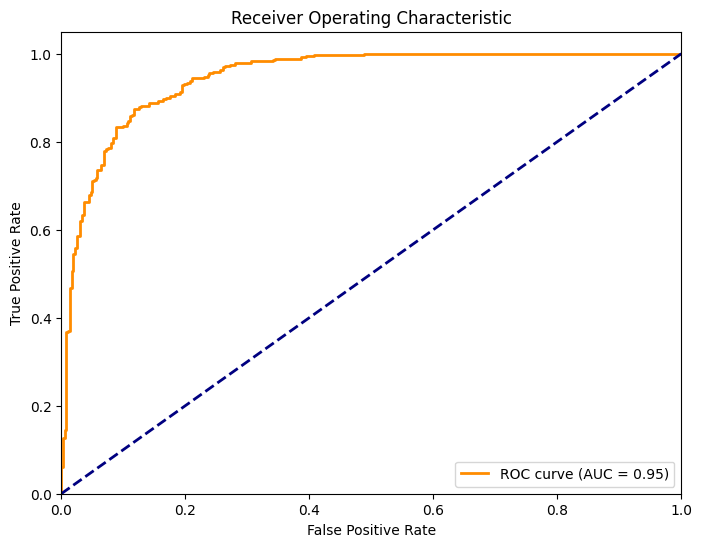

In [7]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm
import timm  # for Vision Transformer

########################################
# 1. Reproducibility & Device Setup
########################################
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

########################################
# 2. Data Preparation & Augmentation
########################################
# Dataset directory structure:
# data/
#   train/
#     benign/
#     malignant/
#   test/
#     benign/
#     malignant/
data_dir = '/kaggle/input/k-means-cyclegan/k-means segmented_data(cycleGAN)'  # Update path as needed
train_dir = os.path.join(data_dir, 'train')
test_dir  = os.path.join(data_dir, 'test')

# ViT typically uses 224x224 images.
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transforms)

########################################
# 3. Visualization 1: Dataset Class Distribution (Pie Chart)
########################################
def plot_class_distribution(dataset, title="Class Distribution"):
    class_names = dataset.classes
    class_counts = {name: 0 for name in class_names}
    for _, label in dataset.samples:
        class_counts[class_names[label]] += 1
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

print("Train Set Distribution:")
plot_class_distribution(train_dataset, "Train Set Distribution")
print("Test Set Distribution:")
plot_class_distribution(test_dataset, "Test Set Distribution")

########################################
# 4. DataLoaders
########################################
batch_size = 16  # Adjust based on GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

########################################
# 5. Model Initialization & Fine-Tuning (Vision Transformer)
########################################
# We use TIMM to create a ViT model (vit_base_patch16_224) pretrained on ImageNet.
model_vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2)
model_vit = model_vit.to(device)

########################################
# 6. Training Function
########################################
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store history
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    # Optionally, enable mixed precision training for memory and speed (if available)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = test_loader
            
            running_loss = 0.0
            running_corrects = 0
            total_samples = 0
            
            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                total_samples += inputs.size(0)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Validation Acc: {best_acc:.4f}")
    
    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    return model, history

########################################
# 7. Set Loss Function, Optimizer, and Scheduler
########################################
criterion = nn.CrossEntropyLoss()
optimizer_vit = optim.Adam(model_vit.parameters(), lr=1e-4)
scheduler_vit = lr_scheduler.StepLR(optimizer_vit, step_size=7, gamma=0.1)

########################################
# 8. Train the Model
########################################
num_epochs = 25
model_vit, history = train_model(model_vit, criterion, optimizer_vit, scheduler_vit, num_epochs=num_epochs)

########################################
# 9. Visualization 2: Training Curves (Accuracy & Loss)
########################################
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12,5))
    
    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

########################################
# 10. Model Evaluation on Test Set
########################################
model_vit.eval()
all_preds = []
all_probs = []  # Probabilities for malignant (class index 1)
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_vit(inputs)
        _, preds = torch.max(outputs, 1)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Class 1 probability
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

########################################
# 11. Visualization 3: Classification Report
########################################
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

########################################
# 12. Visualization 4: Confusion Matrix
########################################
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.classes))
plt.xticks(tick_marks, train_dataset.classes, rotation=45)
plt.yticks(tick_marks, train_dataset.classes)
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

########################################
# 13. Visualization 5: ROC Curve & AUC
########################################
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# A custom hybrid CNN–ViT model

Using device: cuda:0
Train Set Distribution:


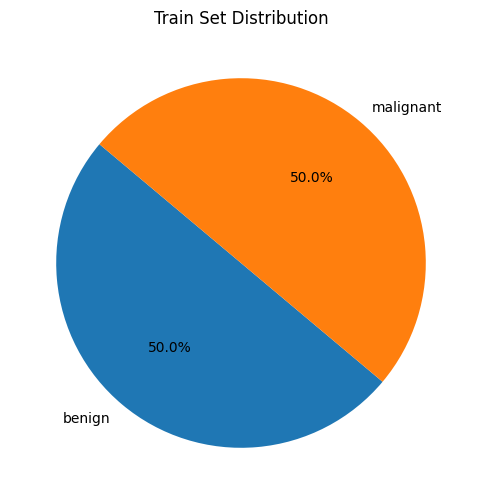

Test Set Distribution:


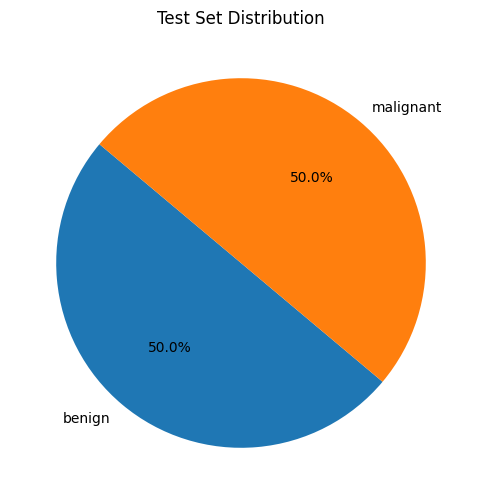

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s] 
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.bat

Epoch 1/25
----------


train:   0%|          | 0/180 [00:00<?, ?it/s]<ipython-input-1-a35db0ad61b9>:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
train: 100%|██████████| 180/180 [00:21<00:00,  8.51it/s]


Train Loss: 0.9370 Acc: 0.6090


val: 100%|██████████| 45/45 [00:02<00:00, 21.67it/s]


Val Loss: 0.4069 Acc: 0.8028

Epoch 2/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.19it/s]


Train Loss: 0.5269 Acc: 0.7528


val: 100%|██████████| 45/45 [00:01<00:00, 24.52it/s]


Val Loss: 0.4315 Acc: 0.7958

Epoch 3/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.21it/s]


Train Loss: 0.4862 Acc: 0.7639


val: 100%|██████████| 45/45 [00:01<00:00, 25.14it/s]


Val Loss: 0.3881 Acc: 0.8069

Epoch 4/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.08it/s]


Train Loss: 0.4769 Acc: 0.7646


val: 100%|██████████| 45/45 [00:01<00:00, 25.01it/s]


Val Loss: 0.4175 Acc: 0.8153

Epoch 5/25
----------


train: 100%|██████████| 180/180 [00:19<00:00,  9.01it/s]


Train Loss: 0.4729 Acc: 0.7726


val: 100%|██████████| 45/45 [00:01<00:00, 24.38it/s]


Val Loss: 0.4650 Acc: 0.8083

Epoch 6/25
----------


train: 100%|██████████| 180/180 [00:20<00:00,  8.98it/s]


Train Loss: 0.4396 Acc: 0.7937


val: 100%|██████████| 45/45 [00:01<00:00, 24.42it/s]


Val Loss: 0.4556 Acc: 0.8069

Epoch 7/25
----------


train: 100%|██████████| 180/180 [00:20<00:00,  8.82it/s]


Train Loss: 0.4239 Acc: 0.8063


val: 100%|██████████| 45/45 [00:01<00:00, 24.03it/s]


Val Loss: 0.4833 Acc: 0.7875

Epoch 8/25
----------


train: 100%|██████████| 180/180 [00:20<00:00,  8.73it/s]


Train Loss: 0.4054 Acc: 0.8090


val: 100%|██████████| 45/45 [00:01<00:00, 23.96it/s]


Val Loss: 0.3431 Acc: 0.8431

Epoch 9/25
----------


train: 100%|██████████| 180/180 [00:20<00:00,  8.80it/s]


Train Loss: 0.3523 Acc: 0.8361


val: 100%|██████████| 45/45 [00:01<00:00, 24.18it/s]


Val Loss: 0.3414 Acc: 0.8486

Epoch 10/25
----------


train: 100%|██████████| 180/180 [00:20<00:00,  8.84it/s]


Train Loss: 0.3560 Acc: 0.8351


val: 100%|██████████| 45/45 [00:01<00:00, 24.31it/s]


Val Loss: 0.3379 Acc: 0.8500

Epoch 11/25
----------


train: 100%|██████████| 180/180 [00:20<00:00,  8.80it/s]


Train Loss: 0.3517 Acc: 0.8299


val: 100%|██████████| 45/45 [00:01<00:00, 24.23it/s]


Val Loss: 0.3267 Acc: 0.8472

Epoch 12/25
----------


train: 100%|██████████| 180/180 [00:20<00:00,  8.81it/s]


Train Loss: 0.3445 Acc: 0.8406


val: 100%|██████████| 45/45 [00:01<00:00, 22.97it/s]


Val Loss: 0.3224 Acc: 0.8514

Epoch 13/25
----------


train: 100%|██████████| 180/180 [00:20<00:00,  8.86it/s]


Train Loss: 0.3537 Acc: 0.8354


val: 100%|██████████| 45/45 [00:01<00:00, 24.24it/s]


Val Loss: 0.3259 Acc: 0.8569

Epoch 14/25
----------


train: 100%|██████████| 180/180 [00:20<00:00,  8.82it/s]


Train Loss: 0.3474 Acc: 0.8462


val: 100%|██████████| 45/45 [00:01<00:00, 24.15it/s]


Val Loss: 0.3227 Acc: 0.8611

Epoch 15/25
----------


train: 100%|██████████| 180/180 [00:20<00:00,  8.83it/s]


Train Loss: 0.3172 Acc: 0.8556


val: 100%|██████████| 45/45 [00:01<00:00, 24.21it/s]


Val Loss: 0.3224 Acc: 0.8583

Epoch 16/25
----------


train: 100%|██████████| 180/180 [00:20<00:00,  8.82it/s]


Train Loss: 0.3200 Acc: 0.8670


val: 100%|██████████| 45/45 [00:01<00:00, 23.42it/s]


Val Loss: 0.3212 Acc: 0.8639

Epoch 17/25
----------


train: 100%|██████████| 180/180 [00:20<00:00,  8.79it/s]


Train Loss: 0.3155 Acc: 0.8545


val: 100%|██████████| 45/45 [00:01<00:00, 24.23it/s]


Val Loss: 0.3223 Acc: 0.8625

Epoch 18/25
----------


train: 100%|██████████| 180/180 [00:20<00:00,  8.83it/s]


Train Loss: 0.3224 Acc: 0.8500


val: 100%|██████████| 45/45 [00:01<00:00, 24.16it/s]


Val Loss: 0.3173 Acc: 0.8611

Epoch 19/25
----------


train: 100%|██████████| 180/180 [00:20<00:00,  8.85it/s]


Train Loss: 0.3114 Acc: 0.8573


val: 100%|██████████| 45/45 [00:01<00:00, 24.30it/s]


Val Loss: 0.3161 Acc: 0.8625

Epoch 20/25
----------


train: 100%|██████████| 180/180 [00:20<00:00,  8.82it/s]


Train Loss: 0.3200 Acc: 0.8521


val: 100%|██████████| 45/45 [00:01<00:00, 24.09it/s]


Val Loss: 0.3189 Acc: 0.8625

Epoch 21/25
----------


train: 100%|██████████| 180/180 [00:20<00:00,  8.86it/s]


Train Loss: 0.3096 Acc: 0.8576


val: 100%|██████████| 45/45 [00:01<00:00, 24.15it/s]


Val Loss: 0.3178 Acc: 0.8611

Epoch 22/25
----------


train: 100%|██████████| 180/180 [00:20<00:00,  8.84it/s]


Train Loss: 0.3276 Acc: 0.8562


val: 100%|██████████| 45/45 [00:01<00:00, 24.38it/s]


Val Loss: 0.3134 Acc: 0.8611

Epoch 23/25
----------


train: 100%|██████████| 180/180 [00:20<00:00,  8.79it/s]


Train Loss: 0.3168 Acc: 0.8604


val: 100%|██████████| 45/45 [00:01<00:00, 24.33it/s]


Val Loss: 0.3155 Acc: 0.8611

Epoch 24/25
----------


train: 100%|██████████| 180/180 [00:20<00:00,  8.86it/s]


Train Loss: 0.3115 Acc: 0.8552


val: 100%|██████████| 45/45 [00:01<00:00, 24.44it/s]


Val Loss: 0.3165 Acc: 0.8639

Epoch 25/25
----------


train: 100%|██████████| 180/180 [00:20<00:00,  8.88it/s]


Train Loss: 0.3242 Acc: 0.8493


val: 100%|██████████| 45/45 [00:01<00:00, 22.62it/s]


Val Loss: 0.3145 Acc: 0.8611

Training complete in 9m 15s
Best Validation Acc: 0.8639


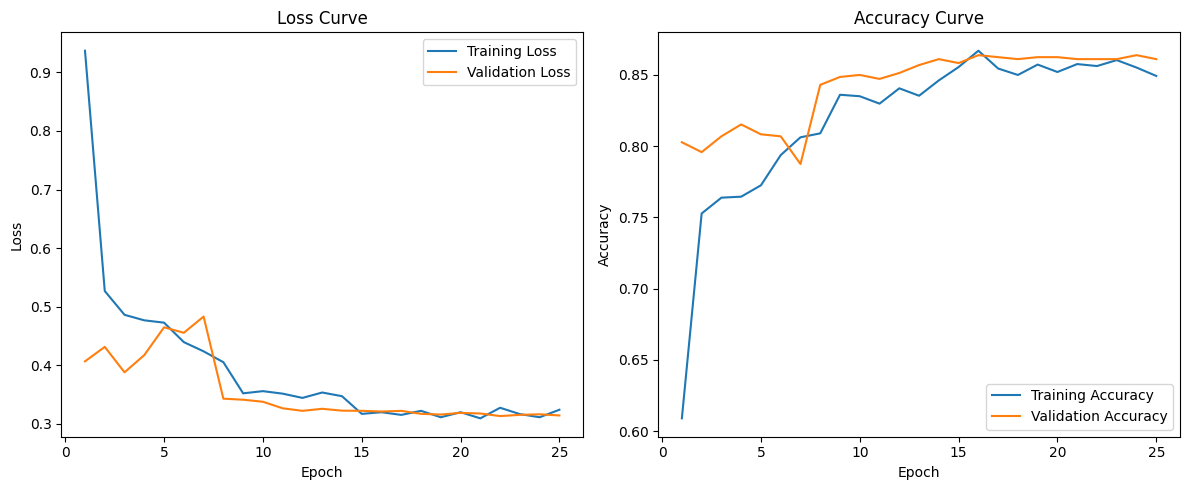

Testing: 100%|██████████| 45/45 [00:03<00:00, 11.85it/s]


Classification Report:
              precision    recall  f1-score   support

      benign       0.87      0.86      0.86       360
   malignant       0.86      0.87      0.86       360

    accuracy                           0.86       720
   macro avg       0.86      0.86      0.86       720
weighted avg       0.86      0.86      0.86       720



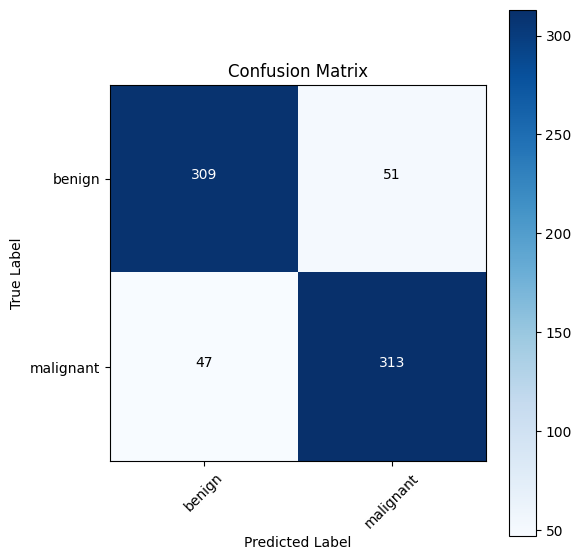

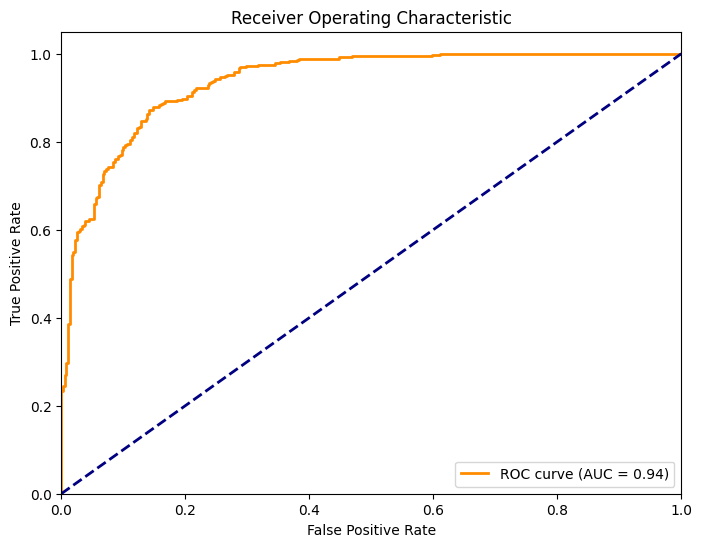

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm

# Optionally, set environment variable to reduce fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.empty_cache()

########################################
# 1. Reproducibility & Device Setup
########################################
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

########################################
# 2. Data Preparation & Augmentation
########################################
# Dataset folder structure:
# data/
#   train/
#     benign/
#     malignant/
#   test/
#     benign/
#     malignant/
data_dir = '/kaggle/input/k-means-cyclegan/k-means segmented_data(cycleGAN)'  # Adjust path as needed
train_dir = os.path.join(data_dir, 'train')
test_dir  = os.path.join(data_dir, 'test')

# We'll use strong augmentation for training.
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
# Testing transforms: resize and center crop.
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transforms)

########################################
# 3. Visualization 1: Dataset Class Distribution (Pie Chart)
########################################
def plot_class_distribution(dataset, title="Class Distribution"):
    class_names = dataset.classes
    class_counts = {name: 0 for name in class_names}
    for _, label in dataset.samples:
        class_counts[class_names[label]] += 1
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

print("Train Set Distribution:")
plot_class_distribution(train_dataset, "Train Set Distribution")
print("Test Set Distribution:")
plot_class_distribution(test_dataset, "Test Set Distribution")

########################################
# 4. DataLoaders
########################################
batch_size = 16  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

########################################
# 5. Hybrid CNN-ViT Model Definition
########################################
# This custom model uses a pretrained ResNet50 as a CNN backbone to extract spatial features.
# The feature map is flattened to a sequence of tokens, projected to a lower dimension,
# a learnable [CLS] token and positional embeddings are added,
# and the tokens are passed through a Transformer encoder.
# The [CLS] token output is then used for classification.
class HybridCNNViT(nn.Module):
    def __init__(self, num_classes=2, hidden_dim=768, num_transformer_layers=6, num_heads=8):
        super(HybridCNNViT, self).__init__()
        # Pretrained CNN Backbone (ResNet50 without avgpool and fc)
        cnn = models.resnet50(pretrained=True)
        self.cnn_backbone = nn.Sequential(*list(cnn.children())[:-2])
        # For 224x224 input, ResNet50 produces (batch, 2048, 7, 7)
        self.num_patches = 7 * 7  # 49 patches
        self.patch_dim = 2048
        # Project each patch to the hidden dimension expected by the transformer.
        self.linear_projection = nn.Linear(self.patch_dim, hidden_dim)
        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))
        # Positional embedding for patches + class token
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.num_patches + 1, hidden_dim))
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
        # Classification head
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.5)
        self._init_weights()
        
    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embedding, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, x):
        # x: (batch, 3, 224, 224)
        features = self.cnn_backbone(x)  # shape: (batch, 2048, 7, 7)
        batch_size = features.size(0)
        # Flatten spatial dimensions: (batch, 2048, 49) -> (batch, 49, 2048)
        features = features.flatten(2).transpose(1, 2)
        # Project to hidden dimension: (batch, 49, hidden_dim)
        tokens = self.linear_projection(features)
        # Prepare class token and concatenate: (batch, 1, hidden_dim)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        tokens = torch.cat((cls_tokens, tokens), dim=1)  # (batch, 50, hidden_dim)
        # Add positional embeddings
        tokens = tokens + self.pos_embedding
        # Permute for transformer: (sequence, batch, d_model)
        tokens = tokens.transpose(0, 1)
        # Transformer Encoder
        transformer_out = self.transformer_encoder(tokens)
        # Use the output of the class token (first token)
        cls_output = transformer_out[0]
        cls_output = self.dropout(cls_output)
        logits = self.fc(cls_output)
        return logits

# Initialize the model
model = HybridCNNViT(num_classes=2, hidden_dim=768, num_transformer_layers=6, num_heads=8)
model = model.to(device)

########################################
# 6. Training Function
########################################
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    # Mixed precision training (optional but helps with memory/speed)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                total_samples += inputs.size(0)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Validation Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    return model, history

########################################
# 7. Set Loss Function, Optimizer, and Scheduler
########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

########################################
# 8. Train the Model
########################################
num_epochs = 25
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)

########################################
# 9. Visualization 2: Training Curves (Accuracy & Loss)
########################################
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12,5))
    
    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

########################################
# 10. Model Evaluation on Test Set
########################################
model.eval()
all_preds = []
all_probs = []  # Probabilities for malignant (class index 1)
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Class 1 probability
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

########################################
# 11. Visualization 3: Classification Report
########################################
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

########################################
# 12. Visualization 4: Confusion Matrix
########################################
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.classes))
plt.xticks(tick_marks, train_dataset.classes, rotation=45)
plt.yticks(tick_marks, train_dataset.classes)
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

########################################
# 13. Visualization 5: ROC Curve & AUC
########################################
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
